In [2]:
link = 'D:/users/Marko/downloads/mirna/'

# Imports

In [3]:
%load_ext tensorboard

In [4]:
import sys
#sys.path.insert(0,'/content/drive/MyDrive/Marko/master')
sys.path.insert(0, link)
import numpy as np
import matplotlib.pyplot as plt

#import tensorflow as tf

import torch
import torch.optim as optim
import torch.nn as nn
import torch.distributions as dist

from torch.nn import functional as F
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm
from tqdm import trange

import datetime
from tensorboard import notebook


writer = SummaryWriter(f"{link}/saved_models/new/IMVAE8/tensorboard")

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
DEVICE

device(type='cuda')

# Model Classes

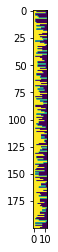

In [7]:
plt.imshow((torch.arange(13)[None, :] < torch.randint(2,14,(2,200))[:,:, None])[0])

In [8]:
stamp = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [1,0,0,0,0,0,0,0,0,0,0,0,0],
                   [1,1,0,0,0,0,0,0,0,0,0,0,0],
                   [1,1,1,0,0,0,0,0,0,0,0,0,0],
                   [1,1,1,1,0,0,0,0,0,0,0,0,0],
                   [1,1,1,1,1,0,0,0,0,0,0,0,0],
                   [1,1,1,1,1,1,0,0,0,0,0,0,0],
                   [1,1,1,1,1,1,1,0,0,0,0,0,0],
                   [1,1,1,1,1,1,1,1,0,0,0,0,0],
                   [1,1,1,1,1,1,1,1,1,0,0,0,0],
                   [1,1,1,1,1,1,1,1,1,1,0,0,0],
                   [1,1,1,1,1,1,1,1,1,1,1,0,0],
                   [1,1,1,1,1,1,1,1,1,1,1,1,0],
                   [1,1,1,1,1,1,1,1,1,1,1,1,1],
                 ])[None,:].to(DEVICE).float()

In [9]:
stamp.shape

torch.Size([1, 14, 13])

In [10]:
a = torch.arange(13)[None, :] < torch.randint(2,14,(64,200))[:,:, None]

In [11]:
torch.arange(13)[None, :].shape, torch.randint(2,14,(64,200))[:,:, None].shape

(torch.Size([1, 13]), torch.Size([64, 200, 1]))

In [12]:
tens1 = torch.tensor([[1.,0,0,0,0]])
tens2 = torch.tensor([[.9,0,0,0,0]])
tens3 = torch.tensor([[0.,0,0,0,0]])

In [13]:
print(F.cross_entropy(tens1, tens1, reduction='sum'))
print(F.cross_entropy(tens1, tens2, reduction='sum'))
print(F.cross_entropy(tens3, tens2, reduction='sum'))

tensor(0.9048)
tensor(0.8143)
tensor(1.4485)


In [14]:
a = a.reshape(-1,2,100,13)

In [15]:
b = a[:,0,:,:].flip(2)
c = torch.cat([b,a[:,1,:,:12]], 2).permute(0,2,1)[:,None].repeat(1,3,1,1)

In [16]:
d = torch.randint(0,2,(64,3,2,100))

In [17]:
e = d[:,:,0,None,:].repeat(1,1,13,1)
f = d[:,:,1,None,:].repeat(1,1,12,1)
g = torch.cat([e,f],2)

In [18]:
g.shape, c.shape

(torch.Size([64, 3, 25, 100]), torch.Size([64, 3, 25, 100]))

In [19]:
x = torch.tensor([[0.03,0.37,.1,0.4,0.1]])
y = torch.tensor([[0,0,0,0,0],
                 [1,0,0,0,0],
                 [1,1,0,0,0],
                 [1,1,1,0,0],
                 [1,1,1,1,1],
                 ])

In [20]:
x.shape, y.shape

(torch.Size([1, 5]), torch.Size([5, 5]))

In [21]:
x_test = F.one_hot(torch.randint(0,13,(64,200)), num_classes=13)
x_test.shape

torch.Size([64, 200, 13])

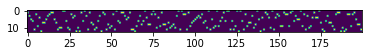

In [22]:
plt.imshow(x_test[0].T)

In [23]:
y_test = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0],
                       [1,0,0,0,0,0,0,0,0,0,0,0,0],
                       [1,1,0,0,0,0,0,0,0,0,0,0,0],
                       [1,1,1,0,0,0,0,0,0,0,0,0,0],
                       [1,1,1,1,1,0,0,0,0,0,0,0,0],
                       [1,1,1,1,1,1,0,0,0,0,0,0,0],
                       [1,1,1,1,1,1,1,0,0,0,0,0,0],
                       [1,1,1,1,1,1,1,1,0,0,0,0,0],
                       [1,1,1,1,1,1,1,1,1,0,0,0,0],
                       [1,1,1,1,1,1,1,1,1,1,0,0,0],
                       [1,1,1,1,1,1,1,1,1,1,1,0,0],
                       [1,1,1,1,1,1,1,1,1,1,1,1,0],
                       [1,1,1,1,1,1,1,1,1,1,1,1,1],
                 ])[None,:].repeat(64,1,1)
y_test.shape

torch.Size([64, 13, 13])

In [24]:
tst = torch.bmm(x_test,y_test)
tst.shape

torch.Size([64, 200, 13])

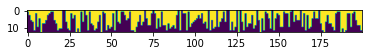

In [25]:
plt.imshow(tst[0].T)

In [26]:
x2 = torch.randint(0,2,(64,200,13))
y2 = torch.ones((64,13,13))

In [27]:
x2.T.shape

D:\Users\Marko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2318.)
  """Entry point for launching an IPython kernel.


torch.Size([13, 200, 64])

In [28]:
#torch.bmm(x2,y2).shape

In [29]:
im = c*g+(~c)

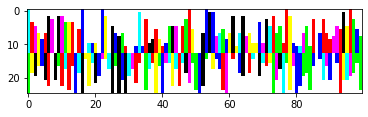

In [30]:
plt.imshow((im[0].permute(1,2,0)*255))

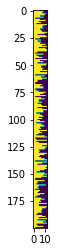

In [31]:
plt.imshow((torch.arange(13)[None, :] < torch.randint(2,14,(2,200))[:,:, None])[1])

In [32]:
torch.arange(13)[None, :].shape , torch.randint(2,14,(64,200))[:, :, None].shape

(torch.Size([1, 13]), torch.Size([64, 200, 1]))

In [33]:
class diva_args:

    def __init__(self, z_dim=128, d_dim=45, x_dim=7500, y_dim=2,
                 beta=1, rec = 1,
                 warmup = 1, prewarmup = 1):

        self.z_dim = z_dim
        self.d_dim = d_dim
        self.x_dim = x_dim
        self.y_dim = y_dim
        
        self.beta = beta
        self.rec = rec
        self.warmup = warmup
        self.prewarmup = prewarmup


## Dataset Class

In [34]:
class MicroRNADataset(Dataset):

    def __init__(self, ds='train', create_encodings=False, use_subset=False):
        
        # loading images
        self.images = np.load(f'{link}/data/modmirbase_{ds}_images.npz')['arr_0']/255
        
        
        if create_encodings:
            x_cat = self.get_encoded_values(self.images, ds)
        else:
            x_cat = np.load(f'{link}/data/modmirbase_{ds}_images_cattt.npz')['arr_0']
        #self.images_cat = np.load(f'{link}/data/modmirbase_{ds}_images_cat_new.npz')
        
        self.images_cat = x_cat
        
        # loading labels
        print('Loading Labels! (~10s)')     
        ohe = OneHotEncoder(categories='auto', sparse=False)
        labels = np.load(f'{link}/data/modmirbase_{ds}_labels.npz')['arr_0']
        self.labels = ohe.fit_transform(labels)
        
        
        self.mountain = np.load(f'{link}/data/modmirbase_{ds}_mountain.npy')
        
        
        # loading names
        print('Loading Names! (~5s)')
        names =  np.load(f'{link}/data/modmirbase_{ds}_names.npz')['arr_0']
        names = [i.decode('utf-8') for i in names]
        self.species = ['mmu', 'prd', 'hsa', 'ptr', 'efu', 'cbn', 'gma', 'pma',
                        'cel', 'gga', 'ipu', 'ptc', 'mdo', 'cgr', 'bta', 'cin', 
                        'ppy', 'ssc', 'ath', 'cfa', 'osa', 'mtr', 'gra', 'mml',
                        'stu', 'bdi', 'rno', 'oan', 'dre', 'aca', 'eca', 'chi',
                        'bmo', 'ggo', 'aly', 'dps', 'mdm', 'ame', 'ppc', 'ssa',
                        'ppt', 'tca', 'dme', 'sbi']
        # assigning a species label to each observation from species
        # with more than 200 observations from past research
        self.names = []
        for i in names:
            append = False
            for j in self.species:
                if j in i.lower():
                    self.names.append(j)
                    append = True
                    break
            if not append:
                if 'random' in i.lower() or i.isdigit():
                    self.names.append('hsa')
                else:
                    self.names.append('notfound')
        
        # performing one hot encoding
        ohe = OneHotEncoder(categories='auto', sparse=False)
        
       
        
        self.names_ohe = ohe.fit_transform(np.array(self.names).reshape(-1,1))
            
    def __len__(self):
        return(self.images.shape[0])

    def __getitem__(self, idx):
        d = self.names_ohe[idx]
        y = self.labels[idx]
        x = self.images[idx]
        x = np.transpose(x, (2,0,1))
        x_cat = self.images_cat[idx]
        return (x_cat, y, d, x)


    def get_encoded_values(self, x, ds):
        """
        given an image or batch of images
        returns length of strand, length of bars and colors of bars
        """
        n = x.shape[0]
        x = np.transpose(x, (0,3,1,2))
        x_cat = np.zeros((n, 5, 25, 100), dtype=np.uint8)
        
        for i in range(n):
            if i % 100 == 0:
                print(f'at {i} out of {n}')
            for j in range(100):
                if (x[i,:,12,j] == np.array([1,1,1])).all():
                    break
                else:
                    # loop through all pixels of the bar
                    for k in range(25):
                        if (x[i,:,k,j] == np.array([1,1,1])).all():
                            continue
                        else:
                            x_cat[i,self.get_color(x[i,:,k,j]),k,j] = 1

        np.savez_compressed(f'{link}/data/modmirbase_{ds}_images_cattt.npz', x_cat)
        #with open(f'{link}/data/modmirbase_{ds}_images_cattt.npz', 'wb') as f:
        #    np.save(f, out_len)
        

        return x_cat

        
    
    def get_color(self, pixel):
        """
        returns the encoded value for a pixel
        """
        if (pixel == np.array([0,0,0])).all():  
            return 0 # black
        elif (pixel == np.array([1,0,0])).all():  
            return 1 # red
        elif (pixel == np.array([0,0,1])).all():  
            return 2 # blue
        elif (pixel == np.array([0,1,0])).all():  
            return 3 # green
        elif (pixel == np.array([1,1,0])).all():  
            return 4 # yellow
        else:
            print("Something wrong!")


## Decoder classes

In [35]:
# Decoders
class px(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, z_dim, dim1=256, dim2=512):
        super(px, self).__init__()

        self.fc = nn.Sequential(nn.Linear(z_dim, dim1),  
                                nn.ReLU(),
                                nn.Dropout(.2),
                                nn.Linear(dim1, dim2),
                                nn.ReLU(),
                                nn.Dropout(.3),
                                nn.Linear(dim2, dim2),
                                nn.ReLU(),
                                nn.Dropout(.4)
                                )
        
        # Predicting length and color of each bar
        
        self.color = nn.Sequential(nn.Linear(dim2, 1000))
        
        
        self.length_bar = nn.Sequential(nn.Linear(dim2,2800))
        
        # monster
        self.stamp = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0],
                                   [1,0,0,0,0,0,0,0,0,0,0,0,0],
                                   [1,1,0,0,0,0,0,0,0,0,0,0,0],
                                   [1,1,1,0,0,0,0,0,0,0,0,0,0],
                                   [1,1,1,1,0,0,0,0,0,0,0,0,0],
                                   [1,1,1,1,1,0,0,0,0,0,0,0,0],
                                   [1,1,1,1,1,1,0,0,0,0,0,0,0],
                                   [1,1,1,1,1,1,1,0,0,0,0,0,0],
                                   [1,1,1,1,1,1,1,1,0,0,0,0,0],
                                   [1,1,1,1,1,1,1,1,1,0,0,0,0],
                                   [1,1,1,1,1,1,1,1,1,1,0,0,0],
                                   [1,1,1,1,1,1,1,1,1,1,1,0,0],
                                   [1,1,1,1,1,1,1,1,1,1,1,1,0],
                                   [1,1,1,1,1,1,1,1,1,1,1,1,1],
                                 ])[None,:].to(DEVICE).float()
        
        
        
    def forward(self, z):
        
        h = self.fc(z)
        
        
        len_bar = self.length_bar(h).reshape(-1,14,200)
        len_bar_ = nn.Softmax(dim=1)(len_bar)
        len_bar = len_bar_.permute(0,2,1)
        len_bar = torch.bmm(len_bar, self.stamp.repeat(len_bar.shape[0],1,1))
        #len_bar = len_bar.reshape(-1,2,100,13)
        msk2 = len_bar[:,:100,:12]
        msk1 = len_bar[:,100:,:].flip(2)
        bars = torch.cat([msk1,msk2], 2).permute(0,2,1)[:,None]
        bars2 = bars.repeat(1,5,1,1)
        
        col = nn.Softmax(dim=1)(self.color(h).reshape(-1,5,2,100))
        col_top = col[:,:,0,None,:].repeat(1,1,13,1)
        col_bot = col[:,:,1,None,:].repeat(1,1,12,1)
        color = torch.cat([col_top,col_bot],2)
        
        rna = color*bars2
        
        return rna, col, len_bar_
    
    def sample(self, color, len_bar, mean=True):
        
        if mean:
            bars = torch.argmax(len_bar, dim=1)
            bars = torch.where(bars>0, bars+1, bars)
            col = torch.argmax(color, dim=1)
        else:
            bars = dist.Categorical(len_bar).sample()
            bars = torch.where(bars>0, bars+1, bars)
            col = dist.Categorical(color).sample()
        out = torch.ones((color.shape[0], 25, 100 ,3))
        for i in range(color.shape[0]):
            for j in range(100):
                out[i, 13-bars[i, 100+j]:13, j] = self.get_color(col[i,0,j])
                out[i, 13: 13+bars[i,j], j] = self.get_color(col[i,1,j])
                
        return out
                
                

                
    def get_color(self, color):
        if color == 0:
            return torch.tensor([0,0,0])
        elif color == 1:
            return torch.tensor([1,0,0])
        elif color == 2:
            return torch.tensor([0,0,1])
        elif color == 3:
            return torch.tensor([0,1,0])
        elif color == 4:
            return torch.tensor([1,1,0])
        

In [36]:
int(np.round(3.7, 0))
int(3.7)

3

In [37]:
# pzy_ = pzy(45, 7500, 2, 32,32,32)
# summary(pzy_, (1,2))
pzy_ = px(45, 7500, 2, 512)
summary(pzy_, (1,512))

Layer (type:depth-idx)                   Output Shape              Param #
px                                       --                        --
├─Sequential: 1-1                        [1, 512]                  --
│    └─Linear: 2-1                       [1, 256]                  131,328
│    └─ReLU: 2-2                         [1, 256]                  --
│    └─Dropout: 2-3                      [1, 256]                  --
│    └─Linear: 2-4                       [1, 512]                  131,584
│    └─ReLU: 2-5                         [1, 512]                  --
│    └─Dropout: 2-6                      [1, 512]                  --
│    └─Linear: 2-7                       [1, 512]                  262,656
│    └─ReLU: 2-8                         [1, 512]                  --
│    └─Dropout: 2-9                      [1, 512]                  --
├─Sequential: 1-2                        [1, 2800]                 --
│    └─Linear: 2-10                      [1, 2800]                 1,4

## Endcoder Classes

In [38]:
#pzy_.reconstruct_image(torch.zeros((1,100)), torch.zeros((1,13,200)), torch.zeros(1,5,200)).shape

In [39]:
class qz(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, z_dim, h_dim=3072):
        super(qz, self).__init__()
        self.h_dim = h_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 128, kernel_size=15, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(), 
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(), 
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),
        )

        self.fc11 = nn.Sequential(nn.Linear(self.h_dim, z_dim))
        self.fc12 = nn.Sequential(nn.Linear(self.h_dim, z_dim), nn.Softplus())


    def forward(self, x):
        h = self.encoder(x)
        h = h.view(-1, self.h_dim)
        z_loc = self.fc11(h)
        z_scale = self.fc12(h) + 1e-7

        return z_loc, z_scale




In [40]:
enc = qz(128,10,10,512)
summary(enc, (1,5,25,100))

Layer (type:depth-idx)                   Output Shape              Param #
qz                                       --                        --
├─Sequential: 1-1                        [1, 512, 1, 6]            --
│    └─Conv2d: 2-1                       [1, 128, 25, 100]         144,128
│    └─ReLU: 2-2                         [1, 128, 25, 100]         --
│    └─Conv2d: 2-3                       [1, 128, 25, 100]         409,728
│    └─ReLU: 2-4                         [1, 128, 25, 100]         --
│    └─MaxPool2d: 2-5                    [1, 128, 12, 50]          --
│    └─Conv2d: 2-6                       [1, 128, 12, 50]          147,584
│    └─ReLU: 2-7                         [1, 128, 12, 50]          --
│    └─Conv2d: 2-8                       [1, 256, 12, 50]          295,168
│    └─ReLU: 2-9                         [1, 256, 12, 50]          --
│    └─MaxPool2d: 2-10                   [1, 256, 6, 25]           --
│    └─Conv2d: 2-11                      [1, 256, 6, 25]         

## Full model class

In [41]:
class StampDIVA(nn.Module):
    def __init__(self, args):
        super(StampDIVA, self).__init__()
        self.z_dim = args.z_dim
        self.d_dim = args.d_dim
        self.x_dim = args.x_dim
        self.y_dim = args.y_dim

        self.px = px(self.d_dim, self.x_dim, self.y_dim, self.z_dim)
        
        self.qz = qz(self.d_dim, self.x_dim, self.y_dim, self.z_dim)
        

        self.beta = args.beta
        
        self.rec = args.rec
        self.warmup = args.warmup
        self.prewarmup = args.prewarmup

        self.cuda()

    def forward(self, d, x, y):
        # Encode
        zd_q_loc, zd_q_scale = self.qz(x)
        
        # Reparameterization trick
        qz = dist.Normal(zd_q_loc, zd_q_scale)
        z_q = qz.rsample()
        
        
        # Decode
        x_hat, color, bars = self.px(z_q)
        z_p_loc, z_p_scale = torch.zeros(z_q.size()[0], self.z_dim).cuda(),\
                        torch.ones(z_q.size()[0], self.z_dim).cuda()
        
        pz = dist.Normal(z_p_loc, z_p_scale)
        
        return x_hat, qz, pz, z_q, color ,bars

    def loss_function(self, d, x, y):
        
        x_hat, qz, pz, z_q, _, _ = self.forward(d, x, y)
       
        rec_loss = F.mse_loss(x_hat, x, reduction='sum')
        
        KL_z = torch.sum(pz.log_prob(z_q) - qz.log_prob(z_q))
          
        return self.rec * rec_loss - self.beta * KL_z, rec_loss

In [42]:
default_args = diva_args(z_dim=256, rec = 10, 
                         beta=1, warmup=1, prewarmup=0)
enc = StampDIVA(default_args)
summary(enc,[ (1,1),(1,5,25,100),(1,1)])

Layer (type:depth-idx)                   Output Shape              Param #
StampDIVA                                --                        --
├─qz: 1-1                                [1, 256]                  --
│    └─Sequential: 2-1                   [1, 512, 1, 6]            --
│    │    └─Conv2d: 3-1                  [1, 128, 25, 100]         144,128
│    │    └─ReLU: 3-2                    [1, 128, 25, 100]         --
│    │    └─Conv2d: 3-3                  [1, 128, 25, 100]         409,728
│    │    └─ReLU: 3-4                    [1, 128, 25, 100]         --
│    │    └─MaxPool2d: 3-5               [1, 128, 12, 50]          --
│    │    └─Conv2d: 3-6                  [1, 128, 12, 50]          147,584
│    │    └─ReLU: 3-7                    [1, 128, 12, 50]          --
│    │    └─Conv2d: 3-8                  [1, 256, 12, 50]          295,168
│    │    └─ReLU: 3-9                    [1, 256, 12, 50]          --
│    │    └─MaxPool2d: 3-10              [1, 256, 6, 25]         

# Training the model

## Loading dataset

In [43]:
RNA_dataset = MicroRNADataset(create_encodings=False)

Loading Labels! (~10s)
Loading Names! (~5s)


In [44]:
RNA_dataset_test = MicroRNADataset('test', create_encodings=False)

Loading Labels! (~10s)
Loading Names! (~5s)


In [45]:
len(RNA_dataset)

34721

In [46]:
def train_single_epoch(train_loader, model, optimizer, epoch):
    model.train()
    train_loss = 0
    no_batches = 0
    mse_t = 0
    pbar = tqdm(enumerate(train_loader), unit="batch", 
                                     desc=f'Epoch {epoch}')
    for batch_idx, (x, y, d, _) in pbar:
        # To device
        x, y, d = x.to(DEVICE), y.to(DEVICE), d.to(DEVICE)

        optimizer.zero_grad()
        loss, mse = model.loss_function(d.float(), x.float(), y.float())
      
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item()/x.shape[0])
        train_loss += loss
        mse_t += mse
        no_batches += 1

    train_loss /= len(train_loader.dataset)
    mse_t /= len(train_loader.dataset)
    
    return train_loss, mse_t

In [47]:
def test_single_epoch(test_loader, model, epoch):
    model.eval()
    test_loss = 0
    mse_t = 0
    with torch.no_grad():
        for batch_idx, (x,y,d,_) in enumerate(test_loader):
            x, y, d= x.to(DEVICE), y.to(DEVICE), d.to(DEVICE)
            loss , mse = model.loss_function(d.float(), x.float(), y.float())
            test_loss += loss
            mse_t += mse
            
    test_loss /= len(test_loader.dataset)
    mse_t /= len(test_loader.dataset)
    
    return test_loss, mse_t
  

In [48]:
def train(args, train_loader, test_loader, diva, optimizer, end_epoch, start_epoch=0, save_folder='sd_1.0.0',save_interval=5):
    
    epoch_loss_sup = []
    test_loss = []
    
    for epoch in range(start_epoch+1, end_epoch+1):
        #idx1, idx2 = choose_index(epoch)
        diva.beta = min([args.beta, args.beta * (epoch - args.prewarmup * 1.) / (args.warmup)])
        if epoch< args.prewarmup:
            diva.beta = args.beta/args.prewarmup
        train_loss , mtr = train_single_epoch(train_loader, diva, optimizer, epoch)
        str_loss_sup = train_loss
        epoch_loss_sup.append(train_loss)
        str_print = "epoch {}: avg train loss {:.2f}".format(epoch, str_loss_sup)
        str_print += ", ce {:.3f}".format(mtr)
        print(str_print)

        rec_loss_train = diva.rec * mtr
        dis_loss_train = train_loss - rec_loss_train

        test_lss, mte = test_single_epoch(test_loader, diva, epoch)
        test_loss.append(test_lss)
       
        str_print = "epoch {}: avg test  loss {:.2f}".format(epoch, test_lss)
        str_print += ", ce {:.3f}".format(mte)
        print(str_print)

        rec_loss_test = diva.rec* mte
        dis_loss_test = test_lss - rec_loss_test

        if writer is not None:
            
            writer.add_scalars("Total_Loss", {'train': train_loss, 'test': test_lss} ,epoch)
            writer.add_scalars("Reconstruction_vs_Disentanglement",{'rec':rec_loss_train, 'dis':dis_loss_train}, epoch)
            writer.add_scalars("bar_mse",{'train': mtr, 'test':mte}, epoch)
           
        if epoch % save_interval == 0:
            save_reconstructions(epoch, test_loader, diva, name=save_folder)
            save_reconstructions(epoch, train_loader, diva, name=save_folder, estr='tr')
        
        
        if epoch % 50 == 0:
            torch.save(diva.state_dict(), f'{link}/saved_models/{save_folder}/checkpoints/{epoch}.pth')

    if writer is not None:
        writer.flush()

    epoch_loss_sup = [i.detach().cpu().numpy() for i in epoch_loss_sup]
    test_loss = [i.detach().cpu().numpy() for i in test_loss]
    return epoch_loss_sup, test_loss

In [49]:
def save_reconstructions(epoch, test_loader, diva, name='diva', estr=''):
    a = next(enumerate(test_loader))
    with torch.no_grad():
        diva.eval()
        d = a[1][2][:10].to(DEVICE).float()
        x = a[1][0][:10].to(DEVICE).float()
        y = a[1][1][:10].to(DEVICE).float()
        x_org = a[1][-1][:10]
        x_hat ,qz, pz, z_q, color, bar = diva(d,x,y)
        
        rec = diva.px.sample(color, bar)
        
        
        #out = x_hat.round().permute(0,2,3,1)

    plt.figure(figsize=(80,20))
    fig, ax = plt.subplots(nrows=10, ncols=2)

    ax[0,0].set_title("Original")
    ax[0,1].set_title("Reconstructed")

    for i in range(10):
        ax[i, 1].imshow(rec[i].cpu())
        ax[i, 0].imshow(x_org[i].cpu().permute(1,2,0))
        ax[i, 0].xaxis.set_visible(False)
        ax[i, 0].yaxis.set_visible(False)
        ax[i, 1].xaxis.set_visible(False)
        ax[i, 1].yaxis.set_visible(False)
    fig.tight_layout(pad=0.1)
    plt.savefig(f'{link}/saved_models/{name}/reconstructions/e{epoch}{estr}.png')
    plt.close('all')

In [50]:
DEVICE

device(type='cuda')

## Model Training

In [51]:
default_args = diva_args(z_dim=1024, rec = 1, 
                         beta=1, warmup=1, prewarmup=0)

In [52]:
diva = StampDIVA(default_args).to(DEVICE)

In [53]:
#diva.load_state_dict(torch.load(f'{link}/saved_models/VAE10/checkpoints/905.pth'))

In [54]:
train_loader = DataLoader(RNA_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(RNA_dataset_test, batch_size=128)

In [55]:
#optimizer = optim.SGD(diva.parameters(), lr=0.00001, momentum=0.1, nesterov=True)
optimizer = optim.Adam(diva.parameters(), lr=0.0001)

In [56]:
#RNA_dataset.x_len.min(), RNA_dataset.x_len.max()

In [57]:
writer.flush()

In [58]:
notebook.start("--logdir D:/users/Marko/downloads/mirna/saved_models/new/ --host localhost")
#%tensorboard --logdir="D:/users/Marko/downloads/mirna/saved_models/new/IMVAE8/tensorboard/" --host localhost

Reusing TensorBoard on port 6006 (pid 8320), started 2:03:53 ago. (Use '!kill 8320' to kill it.)

In [59]:
lss, lss_t = train(default_args, train_loader, test_loader, diva, optimizer, 1000, 0, save_folder="new/IMVAE8",save_interval=25)

Epoch 1: 272batch [01:10,  3.83batch/s, loss=504]


epoch 1: avg train loss 475.53, ce 469.711
epoch 1: avg test  loss 455.77, ce 454.656


Epoch 2: 272batch [01:07,  4.02batch/s, loss=432]


epoch 2: avg train loss 456.51, ce 455.734


Epoch 3: 0batch [00:00, ?batch/s]

epoch 2: avg test  loss 455.49, ce 454.354


Epoch 3: 272batch [01:07,  4.00batch/s, loss=409]


epoch 3: avg train loss 455.62, ce 454.866


Epoch 4: 0batch [00:00, ?batch/s]

epoch 3: avg test  loss 454.82, ce 453.844


Epoch 4: 272batch [01:08,  3.99batch/s, loss=492]


epoch 4: avg train loss 454.21, ce 452.784


Epoch 5: 0batch [00:00, ?batch/s]

epoch 4: avg test  loss 453.02, ce 451.603


Epoch 5: 272batch [01:07,  4.03batch/s, loss=407]


epoch 5: avg train loss 453.36, ce 451.797


Epoch 6: 0batch [00:00, ?batch/s]

epoch 5: avg test  loss 452.82, ce 451.232


Epoch 6: 272batch [01:07,  4.01batch/s, loss=480]


epoch 6: avg train loss 452.88, ce 451.278


Epoch 7: 0batch [00:00, ?batch/s]

epoch 6: avg test  loss 452.79, ce 451.082


Epoch 7: 272batch [01:07,  4.01batch/s, loss=439]


epoch 7: avg train loss 452.33, ce 450.649


Epoch 8: 0batch [00:00, ?batch/s]

epoch 7: avg test  loss 452.25, ce 450.578


Epoch 8: 272batch [01:07,  4.02batch/s, loss=412]


epoch 8: avg train loss 451.88, ce 450.129


Epoch 9: 0batch [00:00, ?batch/s]

epoch 8: avg test  loss 451.50, ce 449.721


Epoch 9: 272batch [01:10,  3.86batch/s, loss=486]


epoch 9: avg train loss 451.60, ce 449.753


Epoch 10: 0batch [00:00, ?batch/s]

epoch 9: avg test  loss 451.62, ce 449.683


Epoch 10: 272batch [01:10,  3.88batch/s, loss=430]


epoch 10: avg train loss 451.35, ce 449.433


Epoch 11: 0batch [00:00, ?batch/s]

epoch 10: avg test  loss 451.10, ce 449.199


Epoch 11: 272batch [01:10,  3.88batch/s, loss=419]


epoch 11: avg train loss 451.05, ce 448.953


Epoch 12: 0batch [00:00, ?batch/s]

epoch 11: avg test  loss 450.40, ce 447.933


Epoch 12: 272batch [01:10,  3.88batch/s, loss=457]


epoch 12: avg train loss 449.83, ce 447.026


Epoch 13: 0batch [00:00, ?batch/s]

epoch 12: avg test  loss 448.71, ce 445.856


Epoch 13: 272batch [01:10,  3.88batch/s, loss=417]


epoch 13: avg train loss 448.97, ce 445.962


Epoch 14: 0batch [00:00, ?batch/s]

epoch 13: avg test  loss 448.24, ce 445.269


Epoch 14: 272batch [01:10,  3.88batch/s, loss=468]


epoch 14: avg train loss 448.48, ce 445.373


Epoch 15: 0batch [00:00, ?batch/s]

epoch 14: avg test  loss 447.61, ce 444.433


Epoch 15: 272batch [01:09,  3.89batch/s, loss=446]


epoch 15: avg train loss 448.09, ce 444.868


Epoch 16: 0batch [00:00, ?batch/s]

epoch 15: avg test  loss 447.63, ce 444.587


Epoch 16: 272batch [01:09,  3.89batch/s, loss=424]


epoch 16: avg train loss 447.82, ce 444.492


Epoch 17: 0batch [00:00, ?batch/s]

epoch 16: avg test  loss 447.38, ce 444.201


Epoch 17: 272batch [01:09,  3.89batch/s, loss=491]


epoch 17: avg train loss 447.62, ce 444.199


Epoch 18: 0batch [00:00, ?batch/s]

epoch 17: avg test  loss 447.01, ce 443.454


Epoch 18: 272batch [01:09,  3.89batch/s, loss=418]


epoch 18: avg train loss 447.41, ce 443.903


Epoch 19: 0batch [00:00, ?batch/s]

epoch 18: avg test  loss 446.86, ce 443.125


Epoch 19: 272batch [01:09,  3.89batch/s, loss=473]


epoch 19: avg train loss 447.20, ce 443.627


Epoch 20: 0batch [00:00, ?batch/s]

epoch 19: avg test  loss 446.71, ce 443.155


Epoch 20: 272batch [01:09,  3.90batch/s, loss=438]


epoch 20: avg train loss 447.06, ce 443.422


Epoch 21: 0batch [00:00, ?batch/s]

epoch 20: avg test  loss 446.67, ce 442.920


Epoch 21: 272batch [01:09,  3.89batch/s, loss=406]


epoch 21: avg train loss 446.87, ce 443.115


Epoch 22: 0batch [00:00, ?batch/s]

epoch 21: avg test  loss 446.68, ce 442.488


Epoch 22: 272batch [01:09,  3.90batch/s, loss=453]


epoch 22: avg train loss 446.55, ce 442.661


Epoch 23: 0batch [00:00, ?batch/s]

epoch 22: avg test  loss 446.02, ce 442.111


Epoch 23: 272batch [01:09,  3.90batch/s, loss=409]


epoch 23: avg train loss 446.26, ce 442.252


Epoch 24: 0batch [00:00, ?batch/s]

epoch 23: avg test  loss 446.00, ce 442.031


Epoch 24: 272batch [01:09,  3.90batch/s, loss=456]


epoch 24: avg train loss 446.03, ce 441.946


Epoch 25: 0batch [00:00, ?batch/s]

epoch 24: avg test  loss 445.35, ce 441.299


Epoch 25: 272batch [01:10,  3.88batch/s, loss=454]


epoch 25: avg train loss 445.85, ce 441.676
epoch 25: avg test  loss 445.16, ce 440.993


Epoch 26: 272batch [01:09,  3.90batch/s, loss=505]


epoch 26: avg train loss 445.50, ce 441.181


Epoch 27: 0batch [00:00, ?batch/s]

epoch 26: avg test  loss 444.82, ce 439.742


Epoch 27: 272batch [01:09,  3.90batch/s, loss=472]


epoch 27: avg train loss 444.88, ce 440.263


Epoch 28: 0batch [00:00, ?batch/s]

epoch 27: avg test  loss 443.98, ce 439.064


Epoch 28: 272batch [01:09,  3.90batch/s, loss=395]


epoch 28: avg train loss 444.26, ce 439.418


Epoch 29: 0batch [00:00, ?batch/s]

epoch 28: avg test  loss 443.38, ce 438.563


Epoch 29: 272batch [01:09,  3.90batch/s, loss=460]


epoch 29: avg train loss 443.82, ce 438.800


Epoch 30: 0batch [00:00, ?batch/s]

epoch 29: avg test  loss 443.13, ce 438.063


Epoch 30: 272batch [01:09,  3.90batch/s, loss=449]


epoch 30: avg train loss 443.57, ce 438.430


Epoch 31: 0batch [00:00, ?batch/s]

epoch 30: avg test  loss 442.78, ce 437.451


Epoch 31: 272batch [01:09,  3.90batch/s, loss=467]


epoch 31: avg train loss 443.30, ce 438.072


Epoch 32: 0batch [00:00, ?batch/s]

epoch 31: avg test  loss 442.50, ce 437.169


Epoch 32: 272batch [01:09,  3.90batch/s, loss=415]


epoch 32: avg train loss 443.08, ce 437.716


Epoch 33: 0batch [00:00, ?batch/s]

epoch 32: avg test  loss 442.47, ce 437.131


Epoch 33: 272batch [01:09,  3.90batch/s, loss=408]


epoch 33: avg train loss 442.90, ce 437.489


Epoch 34: 0batch [00:00, ?batch/s]

epoch 33: avg test  loss 442.15, ce 436.686


Epoch 34: 272batch [01:09,  3.90batch/s, loss=423]


epoch 34: avg train loss 442.76, ce 437.250


Epoch 35: 0batch [00:00, ?batch/s]

epoch 34: avg test  loss 442.03, ce 436.233


Epoch 35: 272batch [01:09,  3.91batch/s, loss=429]


epoch 35: avg train loss 442.48, ce 436.833


Epoch 36: 0batch [00:00, ?batch/s]

epoch 35: avg test  loss 441.68, ce 435.878


Epoch 36: 272batch [01:09,  3.91batch/s, loss=438]


epoch 36: avg train loss 442.16, ce 436.314


Epoch 37: 0batch [00:00, ?batch/s]

epoch 36: avg test  loss 441.14, ce 435.071


Epoch 37: 272batch [01:09,  3.90batch/s, loss=436]


epoch 37: avg train loss 441.65, ce 435.526


Epoch 38: 0batch [00:00, ?batch/s]

epoch 37: avg test  loss 440.50, ce 434.149


Epoch 38: 272batch [01:09,  3.91batch/s, loss=447]


epoch 38: avg train loss 441.00, ce 434.619


Epoch 39: 0batch [00:00, ?batch/s]

epoch 38: avg test  loss 439.88, ce 433.564


Epoch 39: 272batch [01:08,  3.95batch/s, loss=441]


epoch 39: avg train loss 440.56, ce 434.049


Epoch 40: 0batch [00:00, ?batch/s]

epoch 39: avg test  loss 439.52, ce 432.761


Epoch 40: 272batch [01:09,  3.90batch/s, loss=458]


epoch 40: avg train loss 440.20, ce 433.535


Epoch 41: 0batch [00:00, ?batch/s]

epoch 40: avg test  loss 439.05, ce 432.057


Epoch 41: 272batch [01:09,  3.89batch/s, loss=400]


epoch 41: avg train loss 439.87, ce 433.050


Epoch 42: 0batch [00:00, ?batch/s]

epoch 41: avg test  loss 439.05, ce 433.072


Epoch 42: 272batch [01:06,  4.08batch/s, loss=392]


epoch 42: avg train loss 439.51, ce 432.643


Epoch 43: 0batch [00:00, ?batch/s]

epoch 42: avg test  loss 438.64, ce 431.492


Epoch 43: 272batch [01:06,  4.12batch/s, loss=444]


epoch 43: avg train loss 439.24, ce 432.275


Epoch 44: 0batch [00:00, ?batch/s]

epoch 43: avg test  loss 438.28, ce 431.180


Epoch 44: 272batch [01:05,  4.12batch/s, loss=450]


epoch 44: avg train loss 438.99, ce 431.927


Epoch 45: 0batch [00:00, ?batch/s]

epoch 44: avg test  loss 438.18, ce 431.191


Epoch 45: 272batch [01:06,  4.12batch/s, loss=446]


epoch 45: avg train loss 438.78, ce 431.607


Epoch 46: 0batch [00:00, ?batch/s]

epoch 45: avg test  loss 437.80, ce 430.823


Epoch 46: 272batch [01:06,  4.12batch/s, loss=432]


epoch 46: avg train loss 438.58, ce 431.277


Epoch 47: 0batch [00:00, ?batch/s]

epoch 46: avg test  loss 437.63, ce 430.624


Epoch 47: 272batch [01:05,  4.12batch/s, loss=420]


epoch 47: avg train loss 438.25, ce 430.765


Epoch 48: 0batch [00:00, ?batch/s]

epoch 47: avg test  loss 437.15, ce 430.131


Epoch 48: 272batch [01:17,  3.53batch/s, loss=435]


epoch 48: avg train loss 437.92, ce 430.295


Epoch 49: 0batch [00:00, ?batch/s]

epoch 48: avg test  loss 436.48, ce 429.032


Epoch 49: 272batch [01:27,  3.12batch/s, loss=418]


epoch 49: avg train loss 437.54, ce 429.772


Epoch 50: 0batch [00:00, ?batch/s]

epoch 49: avg test  loss 436.23, ce 428.862


Epoch 50: 272batch [01:29,  3.05batch/s, loss=479]


epoch 50: avg train loss 437.21, ce 429.336
epoch 50: avg test  loss 435.99, ce 428.250


Epoch 51: 272batch [01:24,  3.20batch/s, loss=440]


epoch 51: avg train loss 436.83, ce 428.860


Epoch 52: 0batch [00:00, ?batch/s]

epoch 51: avg test  loss 435.68, ce 427.177


Epoch 52: 272batch [01:27,  3.11batch/s, loss=457]


epoch 52: avg train loss 436.49, ce 428.386


Epoch 53: 0batch [00:00, ?batch/s]

epoch 52: avg test  loss 435.15, ce 427.064


Epoch 53: 272batch [01:25,  3.18batch/s, loss=441]


epoch 53: avg train loss 436.28, ce 428.029


Epoch 54: 0batch [00:00, ?batch/s]

epoch 53: avg test  loss 434.99, ce 426.468


Epoch 54: 272batch [01:11,  3.78batch/s, loss=422]


epoch 54: avg train loss 436.02, ce 427.696


Epoch 55: 0batch [00:00, ?batch/s]

epoch 54: avg test  loss 434.83, ce 426.777


Epoch 55: 272batch [01:05,  4.14batch/s, loss=487]


epoch 55: avg train loss 435.76, ce 427.382


Epoch 56: 0batch [00:00, ?batch/s]

epoch 55: avg test  loss 434.53, ce 426.523


Epoch 56: 272batch [01:26,  3.14batch/s, loss=449]


epoch 56: avg train loss 435.64, ce 427.160


Epoch 57: 0batch [00:00, ?batch/s]

epoch 56: avg test  loss 434.45, ce 426.172


Epoch 57: 272batch [01:23,  3.25batch/s, loss=452]


epoch 57: avg train loss 435.43, ce 426.833


Epoch 58: 0batch [00:00, ?batch/s]

epoch 57: avg test  loss 434.00, ce 425.655


Epoch 58: 272batch [01:25,  3.16batch/s, loss=414]


epoch 58: avg train loss 435.09, ce 426.401


Epoch 59: 0batch [00:00, ?batch/s]

epoch 58: avg test  loss 433.81, ce 424.908


Epoch 59: 272batch [01:30,  3.00batch/s, loss=422]


epoch 59: avg train loss 434.89, ce 426.141


Epoch 60: 0batch [00:00, ?batch/s]

epoch 59: avg test  loss 433.51, ce 424.478


Epoch 60: 272batch [01:27,  3.10batch/s, loss=431]


epoch 60: avg train loss 434.67, ce 425.813


Epoch 61: 0batch [00:00, ?batch/s]

epoch 60: avg test  loss 433.75, ce 425.666


Epoch 61: 272batch [01:29,  3.04batch/s, loss=428]


epoch 61: avg train loss 434.52, ce 425.574


Epoch 62: 0batch [00:00, ?batch/s]

epoch 61: avg test  loss 433.23, ce 424.000


Epoch 62: 272batch [01:27,  3.11batch/s, loss=417]


epoch 62: avg train loss 434.18, ce 425.155


Epoch 63: 0batch [00:00, ?batch/s]

epoch 62: avg test  loss 432.80, ce 423.341


Epoch 63: 272batch [01:30,  2.99batch/s, loss=450]


epoch 63: avg train loss 434.01, ce 424.815


Epoch 64: 0batch [00:00, ?batch/s]

epoch 63: avg test  loss 432.64, ce 423.675


Epoch 64: 272batch [01:24,  3.21batch/s, loss=448]


epoch 64: avg train loss 433.84, ce 424.605


Epoch 65: 0batch [00:00, ?batch/s]

epoch 64: avg test  loss 432.46, ce 423.691


Epoch 65: 272batch [01:31,  2.98batch/s, loss=435]


epoch 65: avg train loss 433.53, ce 424.214


Epoch 66: 0batch [00:00, ?batch/s]

epoch 65: avg test  loss 431.98, ce 422.517


Epoch 66: 272batch [01:34,  2.88batch/s, loss=430]


epoch 66: avg train loss 433.25, ce 423.811


Epoch 67: 0batch [00:00, ?batch/s]

epoch 66: avg test  loss 431.76, ce 422.363


Epoch 67: 272batch [01:29,  3.03batch/s, loss=429]


epoch 67: avg train loss 433.15, ce 423.659


Epoch 68: 0batch [00:00, ?batch/s]

epoch 67: avg test  loss 431.62, ce 422.248


Epoch 68: 272batch [01:29,  3.05batch/s, loss=426]


epoch 68: avg train loss 432.94, ce 423.328


Epoch 69: 0batch [00:00, ?batch/s]

epoch 68: avg test  loss 431.30, ce 421.402


Epoch 69: 272batch [01:26,  3.14batch/s, loss=464]


epoch 69: avg train loss 432.66, ce 422.988


Epoch 70: 0batch [00:00, ?batch/s]

epoch 69: avg test  loss 431.16, ce 421.426


Epoch 70: 272batch [01:26,  3.13batch/s, loss=421]


epoch 70: avg train loss 432.40, ce 422.638


Epoch 71: 0batch [00:00, ?batch/s]

epoch 70: avg test  loss 431.25, ce 422.066


Epoch 71: 272batch [01:21,  3.34batch/s, loss=464]


epoch 71: avg train loss 432.37, ce 422.561


Epoch 72: 0batch [00:00, ?batch/s]

epoch 71: avg test  loss 430.90, ce 421.191


Epoch 72: 272batch [01:22,  3.29batch/s, loss=394]


epoch 72: avg train loss 432.09, ce 422.188


Epoch 73: 0batch [00:00, ?batch/s]

epoch 72: avg test  loss 430.64, ce 420.765


Epoch 73: 272batch [01:24,  3.23batch/s, loss=457]


epoch 73: avg train loss 432.01, ce 421.963


Epoch 74: 0batch [00:00, ?batch/s]

epoch 73: avg test  loss 430.73, ce 420.829


Epoch 74: 272batch [01:28,  3.06batch/s, loss=449]


epoch 74: avg train loss 431.88, ce 421.808


Epoch 75: 0batch [00:00, ?batch/s]

epoch 74: avg test  loss 430.20, ce 419.890


Epoch 75: 272batch [01:32,  2.94batch/s, loss=422]


epoch 75: avg train loss 431.60, ce 421.453
epoch 75: avg test  loss 430.02, ce 419.907


Epoch 76: 272batch [01:29,  3.03batch/s, loss=377]


epoch 76: avg train loss 431.47, ce 421.276


Epoch 77: 0batch [00:00, ?batch/s]

epoch 76: avg test  loss 429.92, ce 419.957


Epoch 77: 272batch [01:28,  3.07batch/s, loss=431]


epoch 77: avg train loss 431.30, ce 421.067


Epoch 78: 0batch [00:00, ?batch/s]

epoch 77: avg test  loss 429.65, ce 419.790


Epoch 78: 272batch [01:28,  3.07batch/s, loss=447]


epoch 78: avg train loss 431.10, ce 420.814


Epoch 79: 0batch [00:00, ?batch/s]

epoch 78: avg test  loss 429.68, ce 419.321


Epoch 79: 272batch [01:31,  2.98batch/s, loss=454]


epoch 79: avg train loss 430.87, ce 420.535


Epoch 80: 0batch [00:00, ?batch/s]

epoch 79: avg test  loss 429.39, ce 418.524


Epoch 80: 272batch [01:31,  2.98batch/s, loss=389]


epoch 80: avg train loss 430.69, ce 420.272


Epoch 81: 0batch [00:00, ?batch/s]

epoch 80: avg test  loss 429.17, ce 419.031


Epoch 81: 272batch [01:31,  2.98batch/s, loss=436]


epoch 81: avg train loss 430.49, ce 420.022


Epoch 82: 0batch [00:00, ?batch/s]

epoch 81: avg test  loss 428.80, ce 418.345


Epoch 82: 272batch [01:31,  2.96batch/s, loss=462]


epoch 82: avg train loss 430.31, ce 419.767


Epoch 83: 0batch [00:00, ?batch/s]

epoch 82: avg test  loss 428.84, ce 418.676


Epoch 83: 272batch [01:33,  2.91batch/s, loss=401]


epoch 83: avg train loss 430.11, ce 419.536


Epoch 84: 0batch [00:00, ?batch/s]

epoch 83: avg test  loss 428.43, ce 417.822


Epoch 84: 272batch [01:30,  3.02batch/s, loss=470]


epoch 84: avg train loss 429.77, ce 419.182


Epoch 85: 0batch [00:00, ?batch/s]

epoch 84: avg test  loss 428.21, ce 417.869


Epoch 85: 272batch [01:29,  3.04batch/s, loss=413]


epoch 85: avg train loss 429.49, ce 418.850


Epoch 86: 0batch [00:00, ?batch/s]

epoch 85: avg test  loss 428.05, ce 418.031


Epoch 86: 272batch [01:30,  3.01batch/s, loss=418]


epoch 86: avg train loss 429.31, ce 418.653


Epoch 87: 0batch [00:00, ?batch/s]

epoch 86: avg test  loss 427.51, ce 416.970


Epoch 87: 272batch [01:18,  3.46batch/s, loss=407]


epoch 87: avg train loss 429.02, ce 418.357


Epoch 88: 0batch [00:00, ?batch/s]

epoch 87: avg test  loss 427.24, ce 416.627


Epoch 88: 272batch [01:27,  3.11batch/s, loss=413]


epoch 88: avg train loss 428.69, ce 418.042


Epoch 89: 0batch [00:00, ?batch/s]

epoch 88: avg test  loss 426.86, ce 415.924


Epoch 89: 272batch [01:30,  3.01batch/s, loss=395]


epoch 89: avg train loss 428.56, ce 417.811


Epoch 90: 0batch [00:00, ?batch/s]

epoch 89: avg test  loss 426.81, ce 416.293


Epoch 90: 272batch [01:28,  3.09batch/s, loss=466]


epoch 90: avg train loss 428.17, ce 417.427


Epoch 91: 0batch [00:00, ?batch/s]

epoch 90: avg test  loss 426.56, ce 415.877


Epoch 91: 272batch [01:34,  2.87batch/s, loss=420]


epoch 91: avg train loss 428.06, ce 417.255


Epoch 92: 0batch [00:00, ?batch/s]

epoch 91: avg test  loss 426.37, ce 415.534


Epoch 92: 272batch [01:29,  3.03batch/s, loss=449]


epoch 92: avg train loss 427.85, ce 416.998


Epoch 93: 0batch [00:00, ?batch/s]

epoch 92: avg test  loss 426.15, ce 415.675


Epoch 93: 272batch [01:29,  3.04batch/s, loss=443]


epoch 93: avg train loss 427.55, ce 416.659


Epoch 94: 0batch [00:00, ?batch/s]

epoch 93: avg test  loss 425.86, ce 415.003


Epoch 94: 272batch [01:26,  3.13batch/s, loss=434]


epoch 94: avg train loss 427.41, ce 416.511


Epoch 95: 0batch [00:00, ?batch/s]

epoch 94: avg test  loss 425.59, ce 414.532


Epoch 95: 272batch [01:28,  3.07batch/s, loss=404]


epoch 95: avg train loss 427.15, ce 416.189


Epoch 96: 0batch [00:00, ?batch/s]

epoch 95: avg test  loss 425.35, ce 414.649


Epoch 96: 272batch [01:26,  3.15batch/s, loss=434]


epoch 96: avg train loss 426.89, ce 415.902


Epoch 97: 0batch [00:00, ?batch/s]

epoch 96: avg test  loss 425.05, ce 414.505


Epoch 97: 272batch [01:25,  3.20batch/s, loss=474]


epoch 97: avg train loss 426.61, ce 415.580


Epoch 98: 0batch [00:00, ?batch/s]

epoch 97: avg test  loss 424.87, ce 413.763


Epoch 98: 272batch [01:23,  3.24batch/s, loss=480]


epoch 98: avg train loss 426.38, ce 415.283


Epoch 99: 0batch [00:00, ?batch/s]

epoch 98: avg test  loss 424.31, ce 413.062


Epoch 99: 272batch [01:27,  3.11batch/s, loss=379]


epoch 99: avg train loss 426.04, ce 414.929


Epoch 100: 0batch [00:00, ?batch/s]

epoch 99: avg test  loss 424.20, ce 412.378


Epoch 100: 272batch [01:26,  3.15batch/s, loss=454]


epoch 100: avg train loss 425.77, ce 414.616
epoch 100: avg test  loss 423.81, ce 411.936


Epoch 101: 272batch [01:32,  2.92batch/s, loss=410]


epoch 101: avg train loss 425.33, ce 414.096


Epoch 102: 0batch [00:00, ?batch/s]

epoch 101: avg test  loss 423.32, ce 412.276


Epoch 102: 272batch [01:27,  3.11batch/s, loss=425]


epoch 102: avg train loss 425.10, ce 413.842


Epoch 103: 0batch [00:00, ?batch/s]

epoch 102: avg test  loss 423.09, ce 412.245


Epoch 103: 272batch [01:15,  3.61batch/s, loss=471]


epoch 103: avg train loss 424.85, ce 413.614


Epoch 104: 0batch [00:00, ?batch/s]

epoch 103: avg test  loss 422.91, ce 411.663


Epoch 104: 272batch [01:09,  3.90batch/s, loss=421]


epoch 104: avg train loss 424.63, ce 413.345


Epoch 105: 0batch [00:00, ?batch/s]

epoch 104: avg test  loss 422.57, ce 411.089


Epoch 105: 272batch [01:09,  3.92batch/s, loss=398]


epoch 105: avg train loss 424.36, ce 413.017


Epoch 106: 0batch [00:00, ?batch/s]

epoch 105: avg test  loss 422.32, ce 410.789


Epoch 106: 272batch [01:09,  3.91batch/s, loss=404]


epoch 106: avg train loss 424.21, ce 412.786


Epoch 107: 0batch [00:00, ?batch/s]

epoch 106: avg test  loss 422.19, ce 411.066


Epoch 107: 272batch [01:09,  3.89batch/s, loss=444]


epoch 107: avg train loss 423.95, ce 412.510


Epoch 108: 0batch [00:00, ?batch/s]

epoch 107: avg test  loss 421.82, ce 410.360


Epoch 108: 272batch [01:09,  3.89batch/s, loss=406]


epoch 108: avg train loss 423.75, ce 412.251


Epoch 109: 0batch [00:00, ?batch/s]

epoch 108: avg test  loss 421.64, ce 410.005


Epoch 109: 272batch [01:09,  3.89batch/s, loss=434]


epoch 109: avg train loss 423.57, ce 412.018


Epoch 110: 0batch [00:00, ?batch/s]

epoch 109: avg test  loss 421.48, ce 410.126


Epoch 110: 272batch [01:09,  3.90batch/s, loss=462]


epoch 110: avg train loss 423.31, ce 411.748


Epoch 111: 0batch [00:00, ?batch/s]

epoch 110: avg test  loss 421.22, ce 409.570


Epoch 111: 272batch [01:09,  3.90batch/s, loss=478]


epoch 111: avg train loss 423.08, ce 411.476


Epoch 112: 0batch [00:00, ?batch/s]

epoch 111: avg test  loss 420.89, ce 409.098


Epoch 112: 272batch [01:09,  3.89batch/s, loss=408]


epoch 112: avg train loss 422.95, ce 411.284


Epoch 113: 0batch [00:00, ?batch/s]

epoch 112: avg test  loss 420.84, ce 408.906


Epoch 113: 272batch [01:09,  3.89batch/s, loss=439]


epoch 113: avg train loss 422.76, ce 411.027


Epoch 114: 0batch [00:00, ?batch/s]

epoch 113: avg test  loss 420.66, ce 409.331


Epoch 114: 272batch [01:09,  3.89batch/s, loss=442]


epoch 114: avg train loss 422.46, ce 410.703


Epoch 115: 0batch [00:00, ?batch/s]

epoch 114: avg test  loss 420.47, ce 409.129


Epoch 115: 272batch [01:09,  3.90batch/s, loss=441]


epoch 115: avg train loss 422.27, ce 410.508


Epoch 116: 0batch [00:00, ?batch/s]

epoch 115: avg test  loss 420.35, ce 408.484


Epoch 116: 272batch [01:09,  3.89batch/s, loss=390]


epoch 116: avg train loss 422.04, ce 410.270


Epoch 117: 0batch [00:00, ?batch/s]

epoch 116: avg test  loss 419.90, ce 408.181


Epoch 117: 272batch [01:10,  3.88batch/s, loss=482]


epoch 117: avg train loss 421.78, ce 409.939


Epoch 118: 0batch [00:00, ?batch/s]

epoch 117: avg test  loss 419.86, ce 408.072


Epoch 118: 272batch [01:10,  3.88batch/s, loss=397]


epoch 118: avg train loss 421.64, ce 409.796


Epoch 119: 0batch [00:00, ?batch/s]

epoch 118: avg test  loss 419.52, ce 407.724


Epoch 119: 272batch [01:15,  3.60batch/s, loss=462]


epoch 119: avg train loss 421.33, ce 409.448


Epoch 120: 0batch [00:00, ?batch/s]

epoch 119: avg test  loss 419.11, ce 407.213


Epoch 120: 272batch [01:27,  3.11batch/s, loss=403]


epoch 120: avg train loss 421.13, ce 409.179


Epoch 121: 0batch [00:00, ?batch/s]

epoch 120: avg test  loss 418.95, ce 407.032


Epoch 121: 272batch [01:34,  2.87batch/s, loss=407]


epoch 121: avg train loss 420.85, ce 408.882


Epoch 122: 0batch [00:00, ?batch/s]

epoch 121: avg test  loss 418.69, ce 406.644


Epoch 122: 272batch [01:33,  2.91batch/s, loss=413]


epoch 122: avg train loss 420.61, ce 408.598


Epoch 123: 0batch [00:00, ?batch/s]

epoch 122: avg test  loss 418.55, ce 407.045


Epoch 123: 272batch [01:32,  2.96batch/s, loss=404]


epoch 123: avg train loss 420.53, ce 408.478


Epoch 124: 0batch [00:00, ?batch/s]

epoch 123: avg test  loss 418.33, ce 406.566


Epoch 124: 272batch [01:28,  3.06batch/s, loss=451]


epoch 124: avg train loss 420.23, ce 408.214


Epoch 125: 0batch [00:00, ?batch/s]

epoch 124: avg test  loss 418.17, ce 406.399


Epoch 125: 272batch [01:26,  3.13batch/s, loss=416]


epoch 125: avg train loss 419.99, ce 407.942
epoch 125: avg test  loss 417.84, ce 405.947


Epoch 126: 272batch [01:25,  3.18batch/s, loss=424]


epoch 126: avg train loss 419.80, ce 407.740


Epoch 127: 0batch [00:00, ?batch/s]

epoch 126: avg test  loss 417.65, ce 405.716


Epoch 127: 272batch [01:31,  2.98batch/s, loss=419]


epoch 127: avg train loss 419.53, ce 407.426


Epoch 128: 0batch [00:00, ?batch/s]

epoch 127: avg test  loss 417.38, ce 405.056


Epoch 128: 272batch [01:31,  2.97batch/s, loss=410]


epoch 128: avg train loss 419.48, ce 407.320


Epoch 129: 0batch [00:00, ?batch/s]

epoch 128: avg test  loss 417.24, ce 404.982


Epoch 129: 272batch [01:08,  4.00batch/s, loss=430]


epoch 129: avg train loss 419.28, ce 407.121


Epoch 130: 0batch [00:00, ?batch/s]

epoch 129: avg test  loss 417.23, ce 405.135


Epoch 130: 272batch [01:07,  4.04batch/s, loss=426]


epoch 130: avg train loss 419.06, ce 406.887


Epoch 131: 0batch [00:00, ?batch/s]

epoch 130: avg test  loss 416.88, ce 404.845


Epoch 131: 272batch [01:09,  3.93batch/s, loss=399]


epoch 131: avg train loss 418.79, ce 406.567


Epoch 132: 0batch [00:00, ?batch/s]

epoch 131: avg test  loss 416.74, ce 404.645


Epoch 132: 272batch [01:05,  4.16batch/s, loss=388]


epoch 132: avg train loss 418.70, ce 406.488


Epoch 133: 0batch [00:00, ?batch/s]

epoch 132: avg test  loss 416.58, ce 404.265


Epoch 133: 272batch [01:05,  4.15batch/s, loss=389]


epoch 133: avg train loss 418.58, ce 406.310


Epoch 134: 0batch [00:00, ?batch/s]

epoch 133: avg test  loss 416.43, ce 403.949


Epoch 134: 272batch [01:05,  4.16batch/s, loss=425]


epoch 134: avg train loss 418.46, ce 406.163


Epoch 135: 0batch [00:00, ?batch/s]

epoch 134: avg test  loss 416.41, ce 404.272


Epoch 135: 272batch [01:05,  4.13batch/s, loss=413]


epoch 135: avg train loss 418.46, ce 406.087


Epoch 136: 0batch [00:00, ?batch/s]

epoch 135: avg test  loss 416.26, ce 403.759


Epoch 136: 272batch [01:05,  4.16batch/s, loss=426]


epoch 136: avg train loss 418.24, ce 405.856


Epoch 137: 0batch [00:00, ?batch/s]

epoch 136: avg test  loss 416.08, ce 403.762


Epoch 137: 272batch [01:05,  4.14batch/s, loss=430]


epoch 137: avg train loss 418.24, ce 405.762


Epoch 138: 0batch [00:00, ?batch/s]

epoch 137: avg test  loss 416.12, ce 403.881


Epoch 138: 272batch [01:04,  4.21batch/s, loss=398]


epoch 138: avg train loss 418.01, ce 405.586


Epoch 139: 0batch [00:00, ?batch/s]

epoch 138: avg test  loss 416.06, ce 403.888


Epoch 139: 272batch [01:04,  4.20batch/s, loss=430]


epoch 139: avg train loss 417.96, ce 405.431


Epoch 140: 0batch [00:00, ?batch/s]

epoch 139: avg test  loss 415.74, ce 403.315


Epoch 140: 272batch [01:04,  4.21batch/s, loss=417]


epoch 140: avg train loss 417.82, ce 405.291


Epoch 141: 0batch [00:00, ?batch/s]

epoch 140: avg test  loss 415.49, ce 402.898


Epoch 141: 272batch [01:06,  4.11batch/s, loss=370]


epoch 141: avg train loss 417.71, ce 405.185


Epoch 142: 0batch [00:00, ?batch/s]

epoch 141: avg test  loss 415.53, ce 403.170


Epoch 142: 272batch [01:05,  4.15batch/s, loss=413]


epoch 142: avg train loss 417.64, ce 405.101


Epoch 143: 0batch [00:00, ?batch/s]

epoch 142: avg test  loss 415.44, ce 402.921


Epoch 143: 272batch [01:05,  4.16batch/s, loss=366]


epoch 143: avg train loss 417.47, ce 404.886


Epoch 144: 0batch [00:00, ?batch/s]

epoch 143: avg test  loss 415.17, ce 402.757


Epoch 144: 272batch [01:05,  4.14batch/s, loss=409]


epoch 144: avg train loss 417.45, ce 404.844


Epoch 145: 0batch [00:00, ?batch/s]

epoch 144: avg test  loss 415.41, ce 402.525


Epoch 145: 272batch [01:05,  4.15batch/s, loss=465]


epoch 145: avg train loss 417.19, ce 404.536


Epoch 146: 0batch [00:00, ?batch/s]

epoch 145: avg test  loss 415.26, ce 402.554


Epoch 146: 272batch [01:05,  4.15batch/s, loss=422]


epoch 146: avg train loss 417.16, ce 404.416


Epoch 147: 0batch [00:00, ?batch/s]

epoch 146: avg test  loss 414.90, ce 402.142


Epoch 147: 272batch [01:05,  4.15batch/s, loss=392]


epoch 147: avg train loss 417.14, ce 404.439


Epoch 148: 0batch [00:00, ?batch/s]

epoch 147: avg test  loss 415.03, ce 402.562


Epoch 148: 272batch [01:05,  4.15batch/s, loss=422]


epoch 148: avg train loss 417.05, ce 404.332


Epoch 149: 0batch [00:00, ?batch/s]

epoch 148: avg test  loss 415.02, ce 402.406


Epoch 149: 272batch [01:05,  4.15batch/s, loss=379]


epoch 149: avg train loss 416.81, ce 404.043


Epoch 150: 0batch [00:00, ?batch/s]

epoch 149: avg test  loss 414.70, ce 402.069


Epoch 150: 272batch [01:05,  4.15batch/s, loss=414]


epoch 150: avg train loss 416.75, ce 403.955
epoch 150: avg test  loss 414.63, ce 401.789


Epoch 151: 272batch [01:05,  4.15batch/s, loss=392]


epoch 151: avg train loss 416.70, ce 403.892


Epoch 152: 0batch [00:00, ?batch/s]

epoch 151: avg test  loss 414.63, ce 402.176


Epoch 152: 272batch [01:05,  4.15batch/s, loss=418]


epoch 152: avg train loss 416.58, ce 403.749


Epoch 153: 0batch [00:00, ?batch/s]

epoch 152: avg test  loss 414.36, ce 401.693


Epoch 153: 272batch [01:05,  4.15batch/s, loss=421]


epoch 153: avg train loss 416.53, ce 403.677


Epoch 154: 0batch [00:00, ?batch/s]

epoch 153: avg test  loss 414.36, ce 401.396


Epoch 154: 272batch [01:05,  4.15batch/s, loss=415]


epoch 154: avg train loss 416.50, ce 403.611


Epoch 155: 0batch [00:00, ?batch/s]

epoch 154: avg test  loss 414.23, ce 401.404


Epoch 155: 272batch [01:05,  4.16batch/s, loss=425]


epoch 155: avg train loss 416.38, ce 403.465


Epoch 156: 0batch [00:00, ?batch/s]

epoch 155: avg test  loss 414.15, ce 401.364


Epoch 156: 272batch [01:05,  4.15batch/s, loss=447]


epoch 156: avg train loss 416.33, ce 403.394


Epoch 157: 0batch [00:00, ?batch/s]

epoch 156: avg test  loss 413.98, ce 401.091


Epoch 157: 272batch [01:05,  4.15batch/s, loss=428]


epoch 157: avg train loss 416.15, ce 403.201


Epoch 158: 0batch [00:00, ?batch/s]

epoch 157: avg test  loss 414.04, ce 401.339


Epoch 158: 272batch [01:05,  4.15batch/s, loss=371]


epoch 158: avg train loss 416.11, ce 403.132


Epoch 159: 0batch [00:00, ?batch/s]

epoch 158: avg test  loss 414.09, ce 401.189


Epoch 159: 272batch [01:05,  4.15batch/s, loss=391]


epoch 159: avg train loss 415.94, ce 402.900


Epoch 160: 0batch [00:00, ?batch/s]

epoch 159: avg test  loss 413.83, ce 400.958


Epoch 160: 272batch [01:05,  4.15batch/s, loss=432]


epoch 160: avg train loss 415.93, ce 402.916


Epoch 161: 0batch [00:00, ?batch/s]

epoch 160: avg test  loss 413.77, ce 401.118


Epoch 161: 272batch [01:05,  4.13batch/s, loss=433]


epoch 161: avg train loss 415.83, ce 402.810


Epoch 162: 0batch [00:00, ?batch/s]

epoch 161: avg test  loss 413.87, ce 400.908


Epoch 162: 272batch [01:05,  4.15batch/s, loss=421]


epoch 162: avg train loss 415.82, ce 402.766


Epoch 163: 0batch [00:00, ?batch/s]

epoch 162: avg test  loss 413.63, ce 400.629


Epoch 163: 272batch [01:05,  4.15batch/s, loss=426]


epoch 163: avg train loss 415.65, ce 402.548


Epoch 164: 0batch [00:00, ?batch/s]

epoch 163: avg test  loss 413.69, ce 400.413


Epoch 164: 272batch [01:05,  4.15batch/s, loss=398]


epoch 164: avg train loss 415.58, ce 402.473


Epoch 165: 0batch [00:00, ?batch/s]

epoch 164: avg test  loss 413.65, ce 400.458


Epoch 165: 272batch [01:05,  4.15batch/s, loss=417]


epoch 165: avg train loss 415.44, ce 402.274


Epoch 166: 0batch [00:00, ?batch/s]

epoch 165: avg test  loss 413.40, ce 400.263


Epoch 166: 272batch [01:05,  4.15batch/s, loss=397]


epoch 166: avg train loss 415.35, ce 402.173


Epoch 167: 0batch [00:00, ?batch/s]

epoch 166: avg test  loss 413.39, ce 400.114


Epoch 167: 272batch [01:05,  4.15batch/s, loss=390]


epoch 167: avg train loss 415.46, ce 402.235


Epoch 168: 0batch [00:00, ?batch/s]

epoch 167: avg test  loss 413.21, ce 399.978


Epoch 168: 272batch [01:05,  4.15batch/s, loss=401]


epoch 168: avg train loss 415.25, ce 402.027


Epoch 169: 0batch [00:00, ?batch/s]

epoch 168: avg test  loss 413.29, ce 400.319


Epoch 169: 272batch [01:05,  4.15batch/s, loss=402]


epoch 169: avg train loss 415.18, ce 401.950


Epoch 170: 0batch [00:00, ?batch/s]

epoch 169: avg test  loss 413.24, ce 400.402


Epoch 170: 272batch [01:05,  4.15batch/s, loss=441]


epoch 170: avg train loss 415.13, ce 401.909


Epoch 171: 0batch [00:00, ?batch/s]

epoch 170: avg test  loss 413.09, ce 400.072


Epoch 171: 272batch [01:05,  4.15batch/s, loss=431]


epoch 171: avg train loss 414.91, ce 401.721


Epoch 172: 0batch [00:00, ?batch/s]

epoch 171: avg test  loss 412.86, ce 399.793


Epoch 172: 272batch [01:05,  4.15batch/s, loss=399]


epoch 172: avg train loss 414.97, ce 401.663


Epoch 173: 0batch [00:00, ?batch/s]

epoch 172: avg test  loss 413.03, ce 399.752


Epoch 173: 272batch [01:05,  4.15batch/s, loss=431]


epoch 173: avg train loss 414.91, ce 401.586


Epoch 174: 0batch [00:00, ?batch/s]

epoch 173: avg test  loss 412.89, ce 399.669


Epoch 174: 272batch [01:05,  4.15batch/s, loss=409]


epoch 174: avg train loss 414.81, ce 401.472


Epoch 175: 0batch [00:00, ?batch/s]

epoch 174: avg test  loss 412.93, ce 399.905


Epoch 175: 272batch [01:05,  4.16batch/s, loss=419]


epoch 175: avg train loss 414.73, ce 401.390
epoch 175: avg test  loss 412.93, ce 400.079


Epoch 176: 272batch [01:05,  4.15batch/s, loss=379]


epoch 176: avg train loss 414.67, ce 401.306


Epoch 177: 0batch [00:00, ?batch/s]

epoch 176: avg test  loss 412.83, ce 399.663


Epoch 177: 272batch [01:05,  4.15batch/s, loss=398]


epoch 177: avg train loss 414.53, ce 401.127


Epoch 178: 0batch [00:00, ?batch/s]

epoch 177: avg test  loss 412.69, ce 399.790


Epoch 178: 272batch [01:05,  4.16batch/s, loss=405]


epoch 178: avg train loss 414.47, ce 401.027


Epoch 179: 0batch [00:00, ?batch/s]

epoch 178: avg test  loss 412.48, ce 399.094


Epoch 179: 272batch [01:05,  4.15batch/s, loss=399]


epoch 179: avg train loss 414.45, ce 401.015


Epoch 180: 0batch [00:00, ?batch/s]

epoch 179: avg test  loss 412.50, ce 398.979


Epoch 180: 272batch [01:05,  4.15batch/s, loss=410]


epoch 180: avg train loss 414.43, ce 400.949


Epoch 181: 0batch [00:00, ?batch/s]

epoch 180: avg test  loss 412.31, ce 399.071


Epoch 181: 272batch [01:05,  4.16batch/s, loss=417]


epoch 181: avg train loss 414.41, ce 400.892


Epoch 182: 0batch [00:00, ?batch/s]

epoch 181: avg test  loss 412.33, ce 398.923


Epoch 182: 272batch [01:05,  4.15batch/s, loss=452]


epoch 182: avg train loss 414.16, ce 400.647


Epoch 183: 0batch [00:00, ?batch/s]

epoch 182: avg test  loss 412.28, ce 399.098


Epoch 183: 272batch [01:05,  4.15batch/s, loss=371]


epoch 183: avg train loss 414.17, ce 400.653


Epoch 184: 0batch [00:00, ?batch/s]

epoch 183: avg test  loss 411.97, ce 398.640


Epoch 184: 272batch [01:05,  4.16batch/s, loss=421]


epoch 184: avg train loss 414.18, ce 400.629


Epoch 185: 0batch [00:00, ?batch/s]

epoch 184: avg test  loss 412.30, ce 398.852


Epoch 185: 272batch [01:05,  4.15batch/s, loss=411]


epoch 185: avg train loss 414.05, ce 400.497


Epoch 186: 0batch [00:00, ?batch/s]

epoch 185: avg test  loss 412.00, ce 398.576


Epoch 186: 272batch [01:05,  4.16batch/s, loss=446]


epoch 186: avg train loss 413.98, ce 400.439


Epoch 187: 0batch [00:00, ?batch/s]

epoch 186: avg test  loss 412.15, ce 398.421


Epoch 187: 272batch [01:05,  4.15batch/s, loss=423]


epoch 187: avg train loss 413.87, ce 400.286


Epoch 188: 0batch [00:00, ?batch/s]

epoch 187: avg test  loss 411.87, ce 398.136


Epoch 188: 272batch [01:05,  4.15batch/s, loss=423]


epoch 188: avg train loss 413.67, ce 400.109


Epoch 189: 0batch [00:00, ?batch/s]

epoch 188: avg test  loss 411.93, ce 398.531


Epoch 189: 272batch [01:05,  4.16batch/s, loss=401]


epoch 189: avg train loss 413.77, ce 400.128


Epoch 190: 0batch [00:00, ?batch/s]

epoch 189: avg test  loss 411.85, ce 398.368


Epoch 190: 272batch [01:05,  4.15batch/s, loss=416]


epoch 190: avg train loss 413.76, ce 400.066


Epoch 191: 0batch [00:00, ?batch/s]

epoch 190: avg test  loss 411.75, ce 398.546


Epoch 191: 272batch [01:05,  4.15batch/s, loss=406]


epoch 191: avg train loss 413.62, ce 399.963


Epoch 192: 0batch [00:00, ?batch/s]

epoch 191: avg test  loss 411.66, ce 397.856


Epoch 192: 272batch [01:05,  4.15batch/s, loss=414]


epoch 192: avg train loss 413.55, ce 399.854


Epoch 193: 0batch [00:00, ?batch/s]

epoch 192: avg test  loss 411.76, ce 398.117


Epoch 193: 272batch [01:05,  4.15batch/s, loss=384]


epoch 193: avg train loss 413.39, ce 399.677


Epoch 194: 0batch [00:00, ?batch/s]

epoch 193: avg test  loss 411.56, ce 398.026


Epoch 194: 272batch [01:05,  4.15batch/s, loss=431]


epoch 194: avg train loss 413.34, ce 399.618


Epoch 195: 0batch [00:00, ?batch/s]

epoch 194: avg test  loss 411.76, ce 398.255


Epoch 195: 272batch [01:05,  4.14batch/s, loss=399]


epoch 195: avg train loss 413.32, ce 399.588


Epoch 196: 0batch [00:00, ?batch/s]

epoch 195: avg test  loss 411.40, ce 397.864


Epoch 196: 272batch [01:05,  4.15batch/s, loss=409]


epoch 196: avg train loss 413.36, ce 399.582


Epoch 197: 0batch [00:00, ?batch/s]

epoch 196: avg test  loss 411.41, ce 397.851


Epoch 197: 272batch [01:05,  4.15batch/s, loss=419]


epoch 197: avg train loss 413.30, ce 399.495


Epoch 198: 0batch [00:00, ?batch/s]

epoch 197: avg test  loss 411.31, ce 397.423


Epoch 198: 272batch [01:05,  4.15batch/s, loss=398]


epoch 198: avg train loss 413.18, ce 399.334


Epoch 199: 0batch [00:00, ?batch/s]

epoch 198: avg test  loss 411.21, ce 397.440


Epoch 199: 272batch [01:05,  4.15batch/s, loss=394]


epoch 199: avg train loss 413.13, ce 399.264


Epoch 200: 0batch [00:00, ?batch/s]

epoch 199: avg test  loss 411.19, ce 397.399


Epoch 200: 272batch [01:05,  4.15batch/s, loss=388]


epoch 200: avg train loss 413.09, ce 399.254
epoch 200: avg test  loss 411.19, ce 397.383


Epoch 201: 272batch [01:05,  4.15batch/s, loss=406]


epoch 201: avg train loss 412.93, ce 399.054


Epoch 202: 0batch [00:00, ?batch/s]

epoch 201: avg test  loss 411.13, ce 397.627


Epoch 202: 272batch [01:05,  4.15batch/s, loss=384]


epoch 202: avg train loss 412.95, ce 399.037


Epoch 203: 0batch [00:00, ?batch/s]

epoch 202: avg test  loss 411.04, ce 397.218


Epoch 203: 272batch [01:05,  4.15batch/s, loss=392]


epoch 203: avg train loss 412.84, ce 398.936


Epoch 204: 0batch [00:00, ?batch/s]

epoch 203: avg test  loss 411.10, ce 397.325


Epoch 204: 272batch [01:05,  4.15batch/s, loss=426]


epoch 204: avg train loss 412.76, ce 398.817


Epoch 205: 0batch [00:00, ?batch/s]

epoch 204: avg test  loss 410.91, ce 397.269


Epoch 205: 272batch [01:05,  4.15batch/s, loss=405]


epoch 205: avg train loss 412.77, ce 398.852


Epoch 206: 0batch [00:00, ?batch/s]

epoch 205: avg test  loss 410.71, ce 396.821


Epoch 206: 272batch [01:05,  4.15batch/s, loss=381]


epoch 206: avg train loss 412.51, ce 398.547


Epoch 207: 0batch [00:00, ?batch/s]

epoch 206: avg test  loss 410.69, ce 396.502


Epoch 207: 272batch [01:05,  4.15batch/s, loss=373]


epoch 207: avg train loss 412.50, ce 398.492


Epoch 208: 0batch [00:00, ?batch/s]

epoch 207: avg test  loss 410.62, ce 396.619


Epoch 208: 272batch [01:05,  4.15batch/s, loss=369]


epoch 208: avg train loss 412.49, ce 398.451


Epoch 209: 0batch [00:00, ?batch/s]

epoch 208: avg test  loss 410.67, ce 396.813


Epoch 209: 272batch [01:05,  4.15batch/s, loss=421]


epoch 209: avg train loss 412.49, ce 398.443


Epoch 210: 0batch [00:00, ?batch/s]

epoch 209: avg test  loss 410.70, ce 396.716


Epoch 210: 272batch [01:05,  4.15batch/s, loss=419]


epoch 210: avg train loss 412.29, ce 398.260


Epoch 211: 0batch [00:00, ?batch/s]

epoch 210: avg test  loss 410.51, ce 396.472


Epoch 211: 272batch [01:05,  4.15batch/s, loss=403]


epoch 211: avg train loss 412.37, ce 398.309


Epoch 212: 0batch [00:00, ?batch/s]

epoch 211: avg test  loss 410.59, ce 396.363


Epoch 212: 272batch [01:05,  4.15batch/s, loss=435]


epoch 212: avg train loss 412.21, ce 398.118


Epoch 213: 0batch [00:00, ?batch/s]

epoch 212: avg test  loss 410.31, ce 396.200


Epoch 213: 272batch [01:05,  4.14batch/s, loss=390]


epoch 213: avg train loss 412.19, ce 398.053


Epoch 214: 0batch [00:00, ?batch/s]

epoch 213: avg test  loss 410.34, ce 396.139


Epoch 214: 272batch [01:05,  4.15batch/s, loss=425]


epoch 214: avg train loss 412.12, ce 398.031


Epoch 215: 0batch [00:00, ?batch/s]

epoch 214: avg test  loss 410.24, ce 396.250


Epoch 215: 272batch [01:05,  4.15batch/s, loss=435]


epoch 215: avg train loss 412.01, ce 397.848


Epoch 216: 0batch [00:00, ?batch/s]

epoch 215: avg test  loss 410.05, ce 395.901


Epoch 216: 272batch [01:05,  4.15batch/s, loss=422]


epoch 216: avg train loss 411.77, ce 397.629


Epoch 217: 0batch [00:00, ?batch/s]

epoch 216: avg test  loss 410.01, ce 395.665


Epoch 217: 272batch [01:05,  4.15batch/s, loss=401]


epoch 217: avg train loss 411.82, ce 397.664


Epoch 218: 0batch [00:00, ?batch/s]

epoch 217: avg test  loss 410.00, ce 396.119


Epoch 218: 272batch [01:05,  4.14batch/s, loss=413]


epoch 218: avg train loss 411.71, ce 397.548


Epoch 219: 0batch [00:00, ?batch/s]

epoch 218: avg test  loss 409.88, ce 395.927


Epoch 219: 272batch [01:05,  4.15batch/s, loss=386]


epoch 219: avg train loss 411.59, ce 397.385


Epoch 220: 0batch [00:00, ?batch/s]

epoch 219: avg test  loss 409.70, ce 395.529


Epoch 220: 272batch [01:05,  4.15batch/s, loss=406]


epoch 220: avg train loss 411.55, ce 397.296


Epoch 221: 0batch [00:00, ?batch/s]

epoch 220: avg test  loss 409.67, ce 395.685


Epoch 221: 272batch [01:05,  4.15batch/s, loss=393]


epoch 221: avg train loss 411.51, ce 397.230


Epoch 222: 0batch [00:00, ?batch/s]

epoch 221: avg test  loss 409.54, ce 395.177


Epoch 222: 272batch [01:05,  4.15batch/s, loss=419]


epoch 222: avg train loss 411.27, ce 396.970


Epoch 223: 0batch [00:00, ?batch/s]

epoch 222: avg test  loss 409.51, ce 395.617


Epoch 223: 272batch [01:05,  4.14batch/s, loss=418]


epoch 223: avg train loss 411.39, ce 397.098


Epoch 224: 0batch [00:00, ?batch/s]

epoch 223: avg test  loss 409.44, ce 395.063


Epoch 224: 272batch [01:05,  4.14batch/s, loss=429]


epoch 224: avg train loss 411.19, ce 396.839


Epoch 225: 0batch [00:00, ?batch/s]

epoch 224: avg test  loss 409.37, ce 395.513


Epoch 225: 272batch [01:05,  4.15batch/s, loss=368]


epoch 225: avg train loss 411.04, ce 396.768
epoch 225: avg test  loss 409.20, ce 395.091


Epoch 226: 272batch [01:05,  4.15batch/s, loss=396]


epoch 226: avg train loss 410.91, ce 396.524


Epoch 227: 0batch [00:00, ?batch/s]

epoch 226: avg test  loss 408.97, ce 394.580


Epoch 227: 272batch [01:05,  4.15batch/s, loss=386]


epoch 227: avg train loss 410.74, ce 396.404


Epoch 228: 0batch [00:00, ?batch/s]

epoch 227: avg test  loss 409.03, ce 395.010


Epoch 228: 272batch [01:05,  4.15batch/s, loss=416]


epoch 228: avg train loss 410.64, ce 396.302


Epoch 229: 0batch [00:00, ?batch/s]

epoch 228: avg test  loss 408.79, ce 394.625


Epoch 229: 272batch [01:05,  4.15batch/s, loss=436]


epoch 229: avg train loss 410.52, ce 396.158


Epoch 230: 0batch [00:00, ?batch/s]

epoch 229: avg test  loss 408.66, ce 394.349


Epoch 230: 272batch [01:05,  4.15batch/s, loss=397]


epoch 230: avg train loss 410.48, ce 396.060


Epoch 231: 0batch [00:00, ?batch/s]

epoch 230: avg test  loss 408.81, ce 394.643


Epoch 231: 272batch [01:05,  4.14batch/s, loss=448]


epoch 231: avg train loss 410.30, ce 395.848


Epoch 232: 0batch [00:00, ?batch/s]

epoch 231: avg test  loss 408.53, ce 394.269


Epoch 232: 272batch [01:05,  4.15batch/s, loss=395]


epoch 232: avg train loss 410.24, ce 395.818


Epoch 233: 0batch [00:00, ?batch/s]

epoch 232: avg test  loss 408.51, ce 394.263


Epoch 233: 272batch [01:05,  4.14batch/s, loss=408]


epoch 233: avg train loss 410.09, ce 395.622


Epoch 234: 0batch [00:00, ?batch/s]

epoch 233: avg test  loss 408.37, ce 394.080


Epoch 234: 272batch [01:05,  4.15batch/s, loss=399]


epoch 234: avg train loss 410.09, ce 395.621


Epoch 235: 0batch [00:00, ?batch/s]

epoch 234: avg test  loss 408.27, ce 393.881


Epoch 235: 272batch [01:05,  4.14batch/s, loss=398]


epoch 235: avg train loss 410.05, ce 395.562


Epoch 236: 0batch [00:00, ?batch/s]

epoch 235: avg test  loss 408.16, ce 393.970


Epoch 236: 272batch [01:05,  4.15batch/s, loss=425]


epoch 236: avg train loss 409.78, ce 395.264


Epoch 237: 0batch [00:00, ?batch/s]

epoch 236: avg test  loss 408.07, ce 393.953


Epoch 237: 272batch [01:05,  4.15batch/s, loss=396]


epoch 237: avg train loss 409.74, ce 395.261


Epoch 238: 0batch [00:00, ?batch/s]

epoch 237: avg test  loss 408.02, ce 393.897


Epoch 238: 272batch [01:05,  4.15batch/s, loss=418]


epoch 238: avg train loss 409.61, ce 395.142


Epoch 239: 0batch [00:00, ?batch/s]

epoch 238: avg test  loss 407.94, ce 393.651


Epoch 239: 272batch [01:05,  4.15batch/s, loss=389]


epoch 239: avg train loss 409.53, ce 394.987


Epoch 240: 0batch [00:00, ?batch/s]

epoch 239: avg test  loss 407.77, ce 393.291


Epoch 240: 272batch [01:05,  4.14batch/s, loss=394]


epoch 240: avg train loss 409.42, ce 394.885


Epoch 241: 0batch [00:00, ?batch/s]

epoch 240: avg test  loss 407.65, ce 393.278


Epoch 241: 272batch [01:05,  4.14batch/s, loss=420]


epoch 241: avg train loss 409.37, ce 394.785


Epoch 242: 0batch [00:00, ?batch/s]

epoch 241: avg test  loss 407.69, ce 393.190


Epoch 242: 272batch [01:05,  4.15batch/s, loss=409]


epoch 242: avg train loss 409.30, ce 394.668


Epoch 243: 0batch [00:00, ?batch/s]

epoch 242: avg test  loss 407.50, ce 393.009


Epoch 243: 272batch [01:05,  4.15batch/s, loss=402]


epoch 243: avg train loss 409.06, ce 394.454


Epoch 244: 0batch [00:00, ?batch/s]

epoch 243: avg test  loss 407.45, ce 392.990


Epoch 244: 272batch [01:05,  4.15batch/s, loss=397]


epoch 244: avg train loss 408.99, ce 394.354


Epoch 245: 0batch [00:00, ?batch/s]

epoch 244: avg test  loss 407.42, ce 392.806


Epoch 245: 272batch [01:05,  4.15batch/s, loss=403]


epoch 245: avg train loss 408.87, ce 394.189


Epoch 246: 0batch [00:00, ?batch/s]

epoch 245: avg test  loss 407.13, ce 392.723


Epoch 246: 272batch [01:05,  4.15batch/s, loss=400]


epoch 246: avg train loss 408.77, ce 394.105


Epoch 247: 0batch [00:00, ?batch/s]

epoch 246: avg test  loss 407.06, ce 392.477


Epoch 247: 272batch [01:05,  4.15batch/s, loss=415]


epoch 247: avg train loss 408.64, ce 393.968


Epoch 248: 0batch [00:00, ?batch/s]

epoch 247: avg test  loss 406.92, ce 392.534


Epoch 248: 272batch [01:05,  4.14batch/s, loss=375]


epoch 248: avg train loss 408.54, ce 393.854


Epoch 249: 0batch [00:00, ?batch/s]

epoch 248: avg test  loss 406.84, ce 392.438


Epoch 249: 272batch [01:05,  4.14batch/s, loss=420]


epoch 249: avg train loss 408.40, ce 393.662


Epoch 250: 0batch [00:00, ?batch/s]

epoch 249: avg test  loss 406.64, ce 392.123


Epoch 250: 272batch [01:05,  4.15batch/s, loss=364]


epoch 250: avg train loss 408.30, ce 393.529
epoch 250: avg test  loss 406.58, ce 392.044


Epoch 251: 272batch [01:05,  4.15batch/s, loss=393]


epoch 251: avg train loss 408.21, ce 393.490


Epoch 252: 0batch [00:00, ?batch/s]

epoch 251: avg test  loss 406.37, ce 391.706


Epoch 252: 272batch [01:05,  4.15batch/s, loss=437]


epoch 252: avg train loss 408.11, ce 393.354


Epoch 253: 0batch [00:00, ?batch/s]

epoch 252: avg test  loss 406.27, ce 391.315


Epoch 253: 272batch [01:05,  4.14batch/s, loss=368]


epoch 253: avg train loss 407.96, ce 393.176


Epoch 254: 0batch [00:00, ?batch/s]

epoch 253: avg test  loss 406.36, ce 391.860


Epoch 254: 272batch [01:05,  4.15batch/s, loss=407]


epoch 254: avg train loss 407.87, ce 393.068


Epoch 255: 0batch [00:00, ?batch/s]

epoch 254: avg test  loss 406.06, ce 391.526


Epoch 255: 272batch [01:05,  4.15batch/s, loss=381]


epoch 255: avg train loss 407.75, ce 392.940


Epoch 256: 0batch [00:00, ?batch/s]

epoch 255: avg test  loss 405.98, ce 391.033


Epoch 256: 272batch [01:05,  4.15batch/s, loss=406]


epoch 256: avg train loss 407.64, ce 392.789


Epoch 257: 0batch [00:00, ?batch/s]

epoch 256: avg test  loss 406.15, ce 391.551


Epoch 257: 272batch [01:05,  4.15batch/s, loss=381]


epoch 257: avg train loss 407.52, ce 392.700


Epoch 258: 0batch [00:00, ?batch/s]

epoch 257: avg test  loss 405.85, ce 391.369


Epoch 258: 272batch [01:05,  4.16batch/s, loss=393]


epoch 258: avg train loss 407.52, ce 392.695


Epoch 259: 0batch [00:00, ?batch/s]

epoch 258: avg test  loss 405.88, ce 391.163


Epoch 259: 272batch [01:04,  4.20batch/s, loss=401]


epoch 259: avg train loss 407.35, ce 392.487


Epoch 260: 0batch [00:00, ?batch/s]

epoch 259: avg test  loss 405.83, ce 391.141


Epoch 260: 272batch [01:04,  4.21batch/s, loss=433]


epoch 260: avg train loss 407.39, ce 392.558


Epoch 261: 0batch [00:00, ?batch/s]

epoch 260: avg test  loss 405.68, ce 390.832


Epoch 261: 272batch [01:04,  4.20batch/s, loss=428]


epoch 261: avg train loss 407.26, ce 392.326


Epoch 262: 0batch [00:00, ?batch/s]

epoch 261: avg test  loss 405.58, ce 391.134


Epoch 262: 272batch [01:04,  4.20batch/s, loss=411]


epoch 262: avg train loss 407.21, ce 392.265


Epoch 263: 0batch [00:00, ?batch/s]

epoch 262: avg test  loss 405.54, ce 390.674


Epoch 263: 272batch [01:04,  4.21batch/s, loss=415]


epoch 263: avg train loss 407.05, ce 392.111


Epoch 264: 0batch [00:00, ?batch/s]

epoch 263: avg test  loss 405.55, ce 390.830


Epoch 264: 272batch [01:04,  4.21batch/s, loss=418]


epoch 264: avg train loss 407.02, ce 392.069


Epoch 265: 0batch [00:00, ?batch/s]

epoch 264: avg test  loss 405.21, ce 390.370


Epoch 265: 272batch [01:04,  4.21batch/s, loss=419]


epoch 265: avg train loss 406.92, ce 391.940


Epoch 266: 0batch [00:00, ?batch/s]

epoch 265: avg test  loss 405.28, ce 390.654


Epoch 266: 272batch [01:04,  4.20batch/s, loss=415]


epoch 266: avg train loss 406.68, ce 391.686


Epoch 267: 0batch [00:00, ?batch/s]

epoch 266: avg test  loss 405.40, ce 390.486


Epoch 267: 272batch [01:04,  4.20batch/s, loss=386]


epoch 267: avg train loss 406.75, ce 391.722


Epoch 268: 0batch [00:00, ?batch/s]

epoch 267: avg test  loss 405.32, ce 390.646


Epoch 268: 272batch [01:04,  4.21batch/s, loss=410]


epoch 268: avg train loss 406.76, ce 391.726


Epoch 269: 0batch [00:00, ?batch/s]

epoch 268: avg test  loss 405.17, ce 390.372


Epoch 269: 272batch [01:04,  4.20batch/s, loss=401]


epoch 269: avg train loss 406.60, ce 391.551


Epoch 270: 0batch [00:00, ?batch/s]

epoch 269: avg test  loss 405.25, ce 390.217


Epoch 270: 272batch [01:04,  4.20batch/s, loss=415]


epoch 270: avg train loss 406.67, ce 391.651


Epoch 271: 0batch [00:00, ?batch/s]

epoch 270: avg test  loss 405.02, ce 389.954


Epoch 271: 272batch [01:05,  4.17batch/s, loss=390]


epoch 271: avg train loss 406.61, ce 391.566


Epoch 272: 0batch [00:00, ?batch/s]

epoch 271: avg test  loss 405.02, ce 390.225


Epoch 272: 272batch [01:05,  4.15batch/s, loss=400]


epoch 272: avg train loss 406.47, ce 391.360


Epoch 273: 0batch [00:00, ?batch/s]

epoch 272: avg test  loss 404.91, ce 390.029


Epoch 273: 272batch [01:05,  4.15batch/s, loss=393]


epoch 273: avg train loss 406.32, ce 391.256


Epoch 274: 0batch [00:00, ?batch/s]

epoch 273: avg test  loss 404.92, ce 389.895


Epoch 274: 272batch [01:05,  4.15batch/s, loss=403]


epoch 274: avg train loss 406.28, ce 391.171


Epoch 275: 0batch [00:00, ?batch/s]

epoch 274: avg test  loss 404.81, ce 389.644


Epoch 275: 272batch [01:05,  4.14batch/s, loss=411]


epoch 275: avg train loss 406.22, ce 391.117
epoch 275: avg test  loss 404.56, ce 389.617


Epoch 276: 272batch [01:05,  4.15batch/s, loss=380]


epoch 276: avg train loss 406.11, ce 390.965


Epoch 277: 0batch [00:00, ?batch/s]

epoch 276: avg test  loss 404.74, ce 389.876


Epoch 277: 272batch [01:05,  4.14batch/s, loss=449]


epoch 277: avg train loss 406.15, ce 390.942


Epoch 278: 0batch [00:00, ?batch/s]

epoch 277: avg test  loss 404.50, ce 389.750


Epoch 278: 272batch [01:05,  4.15batch/s, loss=429]


epoch 278: avg train loss 406.08, ce 390.923


Epoch 279: 0batch [00:00, ?batch/s]

epoch 278: avg test  loss 404.49, ce 389.718


Epoch 279: 272batch [01:05,  4.15batch/s, loss=386]


epoch 279: avg train loss 405.90, ce 390.684


Epoch 280: 0batch [00:00, ?batch/s]

epoch 279: avg test  loss 404.44, ce 389.401


Epoch 280: 272batch [01:05,  4.15batch/s, loss=401]


epoch 280: avg train loss 405.98, ce 390.742


Epoch 281: 0batch [00:00, ?batch/s]

epoch 280: avg test  loss 404.36, ce 389.263


Epoch 281: 272batch [01:05,  4.14batch/s, loss=427]


epoch 281: avg train loss 405.82, ce 390.584


Epoch 282: 0batch [00:00, ?batch/s]

epoch 281: avg test  loss 404.38, ce 389.289


Epoch 282: 272batch [01:05,  4.15batch/s, loss=425]


epoch 282: avg train loss 405.70, ce 390.452


Epoch 283: 0batch [00:00, ?batch/s]

epoch 282: avg test  loss 404.33, ce 389.189


Epoch 283: 272batch [01:05,  4.14batch/s, loss=412]


epoch 283: avg train loss 405.72, ce 390.418


Epoch 284: 0batch [00:00, ?batch/s]

epoch 283: avg test  loss 404.32, ce 389.125


Epoch 284: 272batch [01:05,  4.15batch/s, loss=410]


epoch 284: avg train loss 405.57, ce 390.312


Epoch 285: 0batch [00:00, ?batch/s]

epoch 284: avg test  loss 404.07, ce 388.981


Epoch 285: 272batch [01:05,  4.14batch/s, loss=407]


epoch 285: avg train loss 405.64, ce 390.359


Epoch 286: 0batch [00:00, ?batch/s]

epoch 285: avg test  loss 404.00, ce 388.980


Epoch 286: 272batch [01:05,  4.15batch/s, loss=416]


epoch 286: avg train loss 405.46, ce 390.160


Epoch 287: 0batch [00:00, ?batch/s]

epoch 286: avg test  loss 404.07, ce 389.101


Epoch 287: 272batch [01:05,  4.15batch/s, loss=404]


epoch 287: avg train loss 405.34, ce 390.027


Epoch 288: 0batch [00:00, ?batch/s]

epoch 287: avg test  loss 404.01, ce 388.609


Epoch 288: 272batch [01:05,  4.14batch/s, loss=412]


epoch 288: avg train loss 405.30, ce 389.997


Epoch 289: 0batch [00:00, ?batch/s]

epoch 288: avg test  loss 403.79, ce 388.863


Epoch 289: 272batch [01:05,  4.14batch/s, loss=423]


epoch 289: avg train loss 405.19, ce 389.880


Epoch 290: 0batch [00:00, ?batch/s]

epoch 289: avg test  loss 403.84, ce 388.960


Epoch 290: 272batch [01:05,  4.15batch/s, loss=424]


epoch 290: avg train loss 405.33, ce 389.964


Epoch 291: 0batch [00:00, ?batch/s]

epoch 290: avg test  loss 403.82, ce 388.654


Epoch 291: 272batch [01:05,  4.14batch/s, loss=421]


epoch 291: avg train loss 405.11, ce 389.730


Epoch 292: 0batch [00:00, ?batch/s]

epoch 291: avg test  loss 403.71, ce 388.585


Epoch 292: 272batch [01:05,  4.15batch/s, loss=392]


epoch 292: avg train loss 405.02, ce 389.619


Epoch 293: 0batch [00:00, ?batch/s]

epoch 292: avg test  loss 403.49, ce 388.367


Epoch 293: 272batch [01:05,  4.15batch/s, loss=422]


epoch 293: avg train loss 404.93, ce 389.514


Epoch 294: 0batch [00:00, ?batch/s]

epoch 293: avg test  loss 403.47, ce 388.251


Epoch 294: 272batch [01:05,  4.15batch/s, loss=383]


epoch 294: avg train loss 404.81, ce 389.411


Epoch 295: 0batch [00:00, ?batch/s]

epoch 294: avg test  loss 403.67, ce 388.589


Epoch 295: 272batch [01:05,  4.14batch/s, loss=413]


epoch 295: avg train loss 404.73, ce 389.343


Epoch 296: 0batch [00:00, ?batch/s]

epoch 295: avg test  loss 403.43, ce 388.206


Epoch 296: 272batch [01:05,  4.14batch/s, loss=420]


epoch 296: avg train loss 404.69, ce 389.242


Epoch 297: 0batch [00:00, ?batch/s]

epoch 296: avg test  loss 403.43, ce 388.051


Epoch 297: 272batch [01:05,  4.15batch/s, loss=430]


epoch 297: avg train loss 404.79, ce 389.332


Epoch 298: 0batch [00:00, ?batch/s]

epoch 297: avg test  loss 403.37, ce 388.132


Epoch 298: 272batch [01:05,  4.15batch/s, loss=392]


epoch 298: avg train loss 404.48, ce 389.061


Epoch 299: 0batch [00:00, ?batch/s]

epoch 298: avg test  loss 403.32, ce 388.095


Epoch 299: 272batch [01:05,  4.14batch/s, loss=440]


epoch 299: avg train loss 404.59, ce 389.080


Epoch 300: 0batch [00:00, ?batch/s]

epoch 299: avg test  loss 403.11, ce 387.844


Epoch 300: 272batch [01:05,  4.13batch/s, loss=435]


epoch 300: avg train loss 404.52, ce 389.046
epoch 300: avg test  loss 403.09, ce 387.824


Epoch 301: 272batch [01:05,  4.15batch/s, loss=405]


epoch 301: avg train loss 404.37, ce 388.852


Epoch 302: 0batch [00:00, ?batch/s]

epoch 301: avg test  loss 403.07, ce 387.704


Epoch 302: 272batch [01:05,  4.15batch/s, loss=420]


epoch 302: avg train loss 404.42, ce 388.887


Epoch 303: 0batch [00:00, ?batch/s]

epoch 302: avg test  loss 403.09, ce 387.886


Epoch 303: 272batch [01:05,  4.15batch/s, loss=374]


epoch 303: avg train loss 404.22, ce 388.684


Epoch 304: 0batch [00:00, ?batch/s]

epoch 303: avg test  loss 403.03, ce 387.471


Epoch 304: 272batch [01:05,  4.15batch/s, loss=392]


epoch 304: avg train loss 404.12, ce 388.546


Epoch 305: 0batch [00:00, ?batch/s]

epoch 304: avg test  loss 402.96, ce 387.715


Epoch 305: 272batch [01:05,  4.15batch/s, loss=384]


epoch 305: avg train loss 403.98, ce 388.392


Epoch 306: 0batch [00:00, ?batch/s]

epoch 305: avg test  loss 402.77, ce 387.149


Epoch 306: 272batch [01:05,  4.15batch/s, loss=420]


epoch 306: avg train loss 404.09, ce 388.508


Epoch 307: 0batch [00:00, ?batch/s]

epoch 306: avg test  loss 402.73, ce 387.268


Epoch 307: 272batch [01:05,  4.15batch/s, loss=367]


epoch 307: avg train loss 403.97, ce 388.368


Epoch 308: 0batch [00:00, ?batch/s]

epoch 307: avg test  loss 402.63, ce 387.263


Epoch 308: 272batch [01:05,  4.15batch/s, loss=367]


epoch 308: avg train loss 403.87, ce 388.306


Epoch 309: 0batch [00:00, ?batch/s]

epoch 308: avg test  loss 402.55, ce 387.006


Epoch 309: 272batch [01:05,  4.15batch/s, loss=416]


epoch 309: avg train loss 403.74, ce 388.082


Epoch 310: 0batch [00:00, ?batch/s]

epoch 309: avg test  loss 402.56, ce 387.355


Epoch 310: 272batch [01:05,  4.15batch/s, loss=409]


epoch 310: avg train loss 403.69, ce 388.033


Epoch 311: 0batch [00:00, ?batch/s]

epoch 310: avg test  loss 402.37, ce 386.795


Epoch 311: 272batch [01:05,  4.15batch/s, loss=416]


epoch 311: avg train loss 403.62, ce 387.986


Epoch 312: 0batch [00:00, ?batch/s]

epoch 311: avg test  loss 402.44, ce 387.221


Epoch 312: 272batch [01:05,  4.15batch/s, loss=412]


epoch 312: avg train loss 403.53, ce 387.891


Epoch 313: 0batch [00:00, ?batch/s]

epoch 312: avg test  loss 402.27, ce 386.763


Epoch 313: 272batch [01:05,  4.15batch/s, loss=403]


epoch 313: avg train loss 403.50, ce 387.802


Epoch 314: 0batch [00:00, ?batch/s]

epoch 313: avg test  loss 402.29, ce 386.873


Epoch 314: 272batch [01:05,  4.15batch/s, loss=376]


epoch 314: avg train loss 403.38, ce 387.691


Epoch 315: 0batch [00:00, ?batch/s]

epoch 314: avg test  loss 402.17, ce 386.589


Epoch 315: 272batch [01:05,  4.15batch/s, loss=408]


epoch 315: avg train loss 403.41, ce 387.672


Epoch 316: 0batch [00:00, ?batch/s]

epoch 315: avg test  loss 402.03, ce 386.413


Epoch 316: 272batch [01:05,  4.15batch/s, loss=388]


epoch 316: avg train loss 403.22, ce 387.510


Epoch 317: 0batch [00:00, ?batch/s]

epoch 316: avg test  loss 402.07, ce 386.553


Epoch 317: 272batch [01:05,  4.16batch/s, loss=420]


epoch 317: avg train loss 403.08, ce 387.342


Epoch 318: 0batch [00:00, ?batch/s]

epoch 317: avg test  loss 401.98, ce 386.435


Epoch 318: 272batch [01:05,  4.15batch/s, loss=392]


epoch 318: avg train loss 403.06, ce 387.343


Epoch 319: 0batch [00:00, ?batch/s]

epoch 318: avg test  loss 401.70, ce 386.011


Epoch 319: 272batch [01:05,  4.15batch/s, loss=382]


epoch 319: avg train loss 403.05, ce 387.238


Epoch 320: 0batch [00:00, ?batch/s]

epoch 319: avg test  loss 401.80, ce 386.058


Epoch 320: 272batch [01:05,  4.15batch/s, loss=401]


epoch 320: avg train loss 402.80, ce 387.010


Epoch 321: 0batch [00:00, ?batch/s]

epoch 320: avg test  loss 401.78, ce 386.004


Epoch 321: 272batch [01:05,  4.15batch/s, loss=407]


epoch 321: avg train loss 402.87, ce 387.081


Epoch 322: 0batch [00:00, ?batch/s]

epoch 321: avg test  loss 401.65, ce 386.017


Epoch 322: 272batch [01:05,  4.15batch/s, loss=414]


epoch 322: avg train loss 402.67, ce 386.892


Epoch 323: 0batch [00:00, ?batch/s]

epoch 322: avg test  loss 401.52, ce 385.977


Epoch 323: 272batch [01:05,  4.15batch/s, loss=375]


epoch 323: avg train loss 402.73, ce 386.896


Epoch 324: 0batch [00:00, ?batch/s]

epoch 323: avg test  loss 401.52, ce 385.669


Epoch 324: 272batch [01:05,  4.15batch/s, loss=443]


epoch 324: avg train loss 402.49, ce 386.662


Epoch 325: 0batch [00:00, ?batch/s]

epoch 324: avg test  loss 401.32, ce 385.728


Epoch 325: 272batch [01:05,  4.15batch/s, loss=419]


epoch 325: avg train loss 402.44, ce 386.640
epoch 325: avg test  loss 401.21, ce 385.599


Epoch 326: 272batch [01:05,  4.15batch/s, loss=444]


epoch 326: avg train loss 402.28, ce 386.451


Epoch 327: 0batch [00:00, ?batch/s]

epoch 326: avg test  loss 401.24, ce 385.625


Epoch 327: 272batch [01:05,  4.15batch/s, loss=385]


epoch 327: avg train loss 402.18, ce 386.335


Epoch 328: 0batch [00:00, ?batch/s]

epoch 327: avg test  loss 401.21, ce 385.553


Epoch 328: 272batch [01:05,  4.15batch/s, loss=384]


epoch 328: avg train loss 402.22, ce 386.377


Epoch 329: 0batch [00:00, ?batch/s]

epoch 328: avg test  loss 401.21, ce 385.541


Epoch 329: 272batch [01:05,  4.15batch/s, loss=427]


epoch 329: avg train loss 402.07, ce 386.223


Epoch 330: 0batch [00:00, ?batch/s]

epoch 329: avg test  loss 401.00, ce 385.410


Epoch 330: 272batch [01:05,  4.15batch/s, loss=384]


epoch 330: avg train loss 401.94, ce 386.068


Epoch 331: 0batch [00:00, ?batch/s]

epoch 330: avg test  loss 400.96, ce 385.009


Epoch 331: 272batch [01:05,  4.15batch/s, loss=411]


epoch 331: avg train loss 401.88, ce 385.981


Epoch 332: 0batch [00:00, ?batch/s]

epoch 331: avg test  loss 400.83, ce 385.106


Epoch 332: 272batch [01:05,  4.15batch/s, loss=391]


epoch 332: avg train loss 401.74, ce 385.846


Epoch 333: 0batch [00:00, ?batch/s]

epoch 332: avg test  loss 400.76, ce 385.021


Epoch 333: 272batch [01:05,  4.15batch/s, loss=421]


epoch 333: avg train loss 401.76, ce 385.886


Epoch 334: 0batch [00:00, ?batch/s]

epoch 333: avg test  loss 400.70, ce 385.207


Epoch 334: 272batch [01:05,  4.15batch/s, loss=412]


epoch 334: avg train loss 401.71, ce 385.824


Epoch 335: 0batch [00:00, ?batch/s]

epoch 334: avg test  loss 400.80, ce 385.112


Epoch 335: 272batch [01:05,  4.15batch/s, loss=448]


epoch 335: avg train loss 401.75, ce 385.825


Epoch 336: 0batch [00:00, ?batch/s]

epoch 335: avg test  loss 400.75, ce 385.130


Epoch 336: 272batch [01:05,  4.15batch/s, loss=412]


epoch 336: avg train loss 401.56, ce 385.634


Epoch 337: 0batch [00:00, ?batch/s]

epoch 336: avg test  loss 400.57, ce 384.962


Epoch 337: 272batch [01:05,  4.15batch/s, loss=451]


epoch 337: avg train loss 401.43, ce 385.483


Epoch 338: 0batch [00:00, ?batch/s]

epoch 337: avg test  loss 400.39, ce 384.781


Epoch 338: 272batch [01:05,  4.15batch/s, loss=381]


epoch 338: avg train loss 401.31, ce 385.383


Epoch 339: 0batch [00:00, ?batch/s]

epoch 338: avg test  loss 400.38, ce 384.467


Epoch 339: 272batch [01:05,  4.15batch/s, loss=396]


epoch 339: avg train loss 401.27, ce 385.297


Epoch 340: 0batch [00:00, ?batch/s]

epoch 339: avg test  loss 400.34, ce 384.723


Epoch 340: 272batch [01:05,  4.15batch/s, loss=387]


epoch 340: avg train loss 401.30, ce 385.341


Epoch 341: 0batch [00:00, ?batch/s]

epoch 340: avg test  loss 400.39, ce 384.602


Epoch 341: 272batch [01:05,  4.15batch/s, loss=369]


epoch 341: avg train loss 401.18, ce 385.165


Epoch 342: 0batch [00:00, ?batch/s]

epoch 341: avg test  loss 400.23, ce 384.356


Epoch 342: 272batch [01:05,  4.15batch/s, loss=404]


epoch 342: avg train loss 401.11, ce 385.107


Epoch 343: 0batch [00:00, ?batch/s]

epoch 342: avg test  loss 400.18, ce 384.458


Epoch 343: 272batch [01:05,  4.15batch/s, loss=428]


epoch 343: avg train loss 401.05, ce 385.038


Epoch 344: 0batch [00:00, ?batch/s]

epoch 343: avg test  loss 400.21, ce 384.595


Epoch 344: 272batch [01:05,  4.15batch/s, loss=415]


epoch 344: avg train loss 401.08, ce 385.050


Epoch 345: 0batch [00:00, ?batch/s]

epoch 344: avg test  loss 400.10, ce 384.526


Epoch 345: 272batch [01:05,  4.15batch/s, loss=368]


epoch 345: avg train loss 401.04, ce 384.990


Epoch 346: 0batch [00:00, ?batch/s]

epoch 345: avg test  loss 399.99, ce 384.331


Epoch 346: 272batch [01:05,  4.15batch/s, loss=349]


epoch 346: avg train loss 400.98, ce 384.952


Epoch 347: 0batch [00:00, ?batch/s]

epoch 346: avg test  loss 400.05, ce 384.331


Epoch 347: 272batch [01:05,  4.15batch/s, loss=411]


epoch 347: avg train loss 400.82, ce 384.774


Epoch 348: 0batch [00:00, ?batch/s]

epoch 347: avg test  loss 400.06, ce 384.345


Epoch 348: 272batch [01:05,  4.15batch/s, loss=411]


epoch 348: avg train loss 400.83, ce 384.758


Epoch 349: 0batch [00:00, ?batch/s]

epoch 348: avg test  loss 400.07, ce 384.428


Epoch 349: 272batch [01:05,  4.15batch/s, loss=416]


epoch 349: avg train loss 400.74, ce 384.641


Epoch 350: 0batch [00:00, ?batch/s]

epoch 349: avg test  loss 399.85, ce 384.034


Epoch 350: 272batch [01:05,  4.15batch/s, loss=413]


epoch 350: avg train loss 400.77, ce 384.673
epoch 350: avg test  loss 400.05, ce 384.226


Epoch 351: 272batch [01:05,  4.15batch/s, loss=442]


epoch 351: avg train loss 400.65, ce 384.570


Epoch 352: 0batch [00:00, ?batch/s]

epoch 351: avg test  loss 399.80, ce 383.976


Epoch 352: 272batch [01:05,  4.15batch/s, loss=404]


epoch 352: avg train loss 400.60, ce 384.515


Epoch 353: 0batch [00:00, ?batch/s]

epoch 352: avg test  loss 399.67, ce 383.692


Epoch 353: 272batch [01:05,  4.15batch/s, loss=386]


epoch 353: avg train loss 400.61, ce 384.469


Epoch 354: 0batch [00:00, ?batch/s]

epoch 353: avg test  loss 399.75, ce 384.042


Epoch 354: 272batch [01:05,  4.15batch/s, loss=407]


epoch 354: avg train loss 400.59, ce 384.487


Epoch 355: 0batch [00:00, ?batch/s]

epoch 354: avg test  loss 399.64, ce 383.753


Epoch 355: 272batch [01:05,  4.14batch/s, loss=356]


epoch 355: avg train loss 400.46, ce 384.316


Epoch 356: 0batch [00:00, ?batch/s]

epoch 355: avg test  loss 399.69, ce 383.778


Epoch 356: 272batch [01:05,  4.15batch/s, loss=415]


epoch 356: avg train loss 400.31, ce 384.186


Epoch 357: 0batch [00:00, ?batch/s]

epoch 356: avg test  loss 399.58, ce 383.792


Epoch 357: 272batch [01:05,  4.15batch/s, loss=398]


epoch 357: avg train loss 400.49, ce 384.373


Epoch 358: 0batch [00:00, ?batch/s]

epoch 357: avg test  loss 399.56, ce 383.890


Epoch 358: 272batch [01:05,  4.15batch/s, loss=389]


epoch 358: avg train loss 400.27, ce 384.102


Epoch 359: 0batch [00:00, ?batch/s]

epoch 358: avg test  loss 399.47, ce 383.552


Epoch 359: 272batch [01:05,  4.15batch/s, loss=375]


epoch 359: avg train loss 400.20, ce 384.023


Epoch 360: 0batch [00:00, ?batch/s]

epoch 359: avg test  loss 399.60, ce 383.832


Epoch 360: 272batch [01:05,  4.15batch/s, loss=327]


epoch 360: avg train loss 400.22, ce 384.065


Epoch 361: 0batch [00:00, ?batch/s]

epoch 360: avg test  loss 399.52, ce 383.575


Epoch 361: 272batch [01:05,  4.15batch/s, loss=372]


epoch 361: avg train loss 400.33, ce 384.132


Epoch 362: 0batch [00:00, ?batch/s]

epoch 361: avg test  loss 399.50, ce 383.436


Epoch 362: 272batch [01:05,  4.15batch/s, loss=401]


epoch 362: avg train loss 400.15, ce 383.921


Epoch 363: 0batch [00:00, ?batch/s]

epoch 362: avg test  loss 399.37, ce 383.223


Epoch 363: 272batch [01:05,  4.15batch/s, loss=396]


epoch 363: avg train loss 400.08, ce 383.858


Epoch 364: 0batch [00:00, ?batch/s]

epoch 363: avg test  loss 399.38, ce 383.339


Epoch 364: 272batch [01:05,  4.15batch/s, loss=388]


epoch 364: avg train loss 400.02, ce 383.840


Epoch 365: 0batch [00:00, ?batch/s]

epoch 364: avg test  loss 399.28, ce 383.276


Epoch 365: 272batch [01:05,  4.16batch/s, loss=439]


epoch 365: avg train loss 399.97, ce 383.785


Epoch 366: 0batch [00:00, ?batch/s]

epoch 365: avg test  loss 399.36, ce 383.269


Epoch 366: 272batch [01:05,  4.15batch/s, loss=407]


epoch 366: avg train loss 399.91, ce 383.630


Epoch 367: 0batch [00:00, ?batch/s]

epoch 366: avg test  loss 399.37, ce 383.637


Epoch 367: 272batch [01:05,  4.15batch/s, loss=406]


epoch 367: avg train loss 399.85, ce 383.641


Epoch 368: 0batch [00:00, ?batch/s]

epoch 367: avg test  loss 399.18, ce 383.003


Epoch 368: 272batch [01:05,  4.16batch/s, loss=410]


epoch 368: avg train loss 399.81, ce 383.564


Epoch 369: 0batch [00:00, ?batch/s]

epoch 368: avg test  loss 399.22, ce 383.346


Epoch 369: 272batch [01:04,  4.21batch/s, loss=381]


epoch 369: avg train loss 399.80, ce 383.575


Epoch 370: 0batch [00:00, ?batch/s]

epoch 369: avg test  loss 399.01, ce 382.855


Epoch 370: 272batch [01:04,  4.21batch/s, loss=416]


epoch 370: avg train loss 399.72, ce 383.516


Epoch 371: 0batch [00:00, ?batch/s]

epoch 370: avg test  loss 399.12, ce 382.926


Epoch 371: 272batch [01:04,  4.21batch/s, loss=393]


epoch 371: avg train loss 399.68, ce 383.400


Epoch 372: 0batch [00:00, ?batch/s]

epoch 371: avg test  loss 399.02, ce 382.926


Epoch 372: 272batch [01:04,  4.21batch/s, loss=423]


epoch 372: avg train loss 399.57, ce 383.256


Epoch 373: 0batch [00:00, ?batch/s]

epoch 372: avg test  loss 399.00, ce 382.896


Epoch 373: 272batch [01:04,  4.21batch/s, loss=392]


epoch 373: avg train loss 399.54, ce 383.223


Epoch 374: 0batch [00:00, ?batch/s]

epoch 373: avg test  loss 398.96, ce 382.898


Epoch 374: 272batch [01:04,  4.21batch/s, loss=401]


epoch 374: avg train loss 399.62, ce 383.260


Epoch 375: 0batch [00:00, ?batch/s]

epoch 374: avg test  loss 398.94, ce 382.999


Epoch 375: 272batch [01:04,  4.21batch/s, loss=396]


epoch 375: avg train loss 399.42, ce 383.121
epoch 375: avg test  loss 398.79, ce 382.674


Epoch 376: 272batch [01:04,  4.21batch/s, loss=432]


epoch 376: avg train loss 399.45, ce 383.142


Epoch 377: 0batch [00:00, ?batch/s]

epoch 376: avg test  loss 398.80, ce 382.646


Epoch 377: 272batch [01:04,  4.21batch/s, loss=424]


epoch 377: avg train loss 399.41, ce 383.065


Epoch 378: 0batch [00:00, ?batch/s]

epoch 377: avg test  loss 398.94, ce 382.834


Epoch 378: 272batch [01:04,  4.21batch/s, loss=425]


epoch 378: avg train loss 399.41, ce 383.108


Epoch 379: 0batch [00:00, ?batch/s]

epoch 378: avg test  loss 398.73, ce 382.386


Epoch 379: 272batch [01:04,  4.21batch/s, loss=403]


epoch 379: avg train loss 399.36, ce 382.991


Epoch 380: 0batch [00:00, ?batch/s]

epoch 379: avg test  loss 398.77, ce 382.698


Epoch 380: 272batch [01:04,  4.21batch/s, loss=382]


epoch 380: avg train loss 399.30, ce 382.967


Epoch 381: 0batch [00:00, ?batch/s]

epoch 380: avg test  loss 398.86, ce 382.732


Epoch 381: 272batch [01:05,  4.17batch/s, loss=400]


epoch 381: avg train loss 399.34, ce 382.936


Epoch 382: 0batch [00:00, ?batch/s]

epoch 381: avg test  loss 398.82, ce 382.888


Epoch 382: 272batch [01:06,  4.09batch/s, loss=394]


epoch 382: avg train loss 399.20, ce 382.861


Epoch 383: 0batch [00:00, ?batch/s]

epoch 382: avg test  loss 398.82, ce 382.801


Epoch 383: 272batch [01:05,  4.15batch/s, loss=349]


epoch 383: avg train loss 399.14, ce 382.745


Epoch 384: 0batch [00:00, ?batch/s]

epoch 383: avg test  loss 398.69, ce 382.615


Epoch 384: 272batch [01:05,  4.14batch/s, loss=390]


epoch 384: avg train loss 399.16, ce 382.749


Epoch 385: 0batch [00:00, ?batch/s]

epoch 384: avg test  loss 398.52, ce 382.246


Epoch 385: 272batch [01:06,  4.11batch/s, loss=395]


epoch 385: avg train loss 399.08, ce 382.697


Epoch 386: 0batch [00:00, ?batch/s]

epoch 385: avg test  loss 398.51, ce 382.209


Epoch 386: 272batch [01:05,  4.15batch/s, loss=409]


epoch 386: avg train loss 399.02, ce 382.618


Epoch 387: 0batch [00:00, ?batch/s]

epoch 386: avg test  loss 398.56, ce 382.232


Epoch 387: 272batch [01:05,  4.13batch/s, loss=387]


epoch 387: avg train loss 399.00, ce 382.560


Epoch 388: 0batch [00:00, ?batch/s]

epoch 387: avg test  loss 398.43, ce 382.391


Epoch 388: 272batch [01:05,  4.15batch/s, loss=363]


epoch 388: avg train loss 398.94, ce 382.548


Epoch 389: 0batch [00:00, ?batch/s]

epoch 388: avg test  loss 398.51, ce 382.100


Epoch 389: 272batch [01:05,  4.15batch/s, loss=425]


epoch 389: avg train loss 398.87, ce 382.442


Epoch 390: 0batch [00:00, ?batch/s]

epoch 389: avg test  loss 398.38, ce 382.296


Epoch 390: 272batch [01:05,  4.15batch/s, loss=385]


epoch 390: avg train loss 398.88, ce 382.447


Epoch 391: 0batch [00:00, ?batch/s]

epoch 390: avg test  loss 398.51, ce 382.229


Epoch 391: 272batch [01:05,  4.15batch/s, loss=430]


epoch 391: avg train loss 398.69, ce 382.253


Epoch 392: 0batch [00:00, ?batch/s]

epoch 391: avg test  loss 398.46, ce 382.205


Epoch 392: 272batch [01:05,  4.15batch/s, loss=416]


epoch 392: avg train loss 398.74, ce 382.308


Epoch 393: 0batch [00:00, ?batch/s]

epoch 392: avg test  loss 398.36, ce 382.306


Epoch 393: 272batch [01:05,  4.15batch/s, loss=484]


epoch 393: avg train loss 398.68, ce 382.202


Epoch 394: 0batch [00:00, ?batch/s]

epoch 393: avg test  loss 398.53, ce 382.332


Epoch 394: 272batch [01:05,  4.13batch/s, loss=388]


epoch 394: avg train loss 398.63, ce 382.116


Epoch 395: 0batch [00:00, ?batch/s]

epoch 394: avg test  loss 398.31, ce 382.177


Epoch 395: 272batch [01:05,  4.15batch/s, loss=395]


epoch 395: avg train loss 398.68, ce 382.191


Epoch 396: 0batch [00:00, ?batch/s]

epoch 395: avg test  loss 398.08, ce 381.830


Epoch 396: 272batch [01:05,  4.15batch/s, loss=374]


epoch 396: avg train loss 398.47, ce 381.960


Epoch 397: 0batch [00:00, ?batch/s]

epoch 396: avg test  loss 398.15, ce 381.978


Epoch 397: 272batch [01:05,  4.15batch/s, loss=422]


epoch 397: avg train loss 398.51, ce 381.983


Epoch 398: 0batch [00:00, ?batch/s]

epoch 397: avg test  loss 398.06, ce 381.802


Epoch 398: 272batch [01:05,  4.15batch/s, loss=382]


epoch 398: avg train loss 398.38, ce 381.935


Epoch 399: 0batch [00:00, ?batch/s]

epoch 398: avg test  loss 398.16, ce 382.007


Epoch 399: 272batch [01:05,  4.15batch/s, loss=387]


epoch 399: avg train loss 398.50, ce 381.969


Epoch 400: 0batch [00:00, ?batch/s]

epoch 399: avg test  loss 398.16, ce 381.671


Epoch 400: 272batch [01:05,  4.15batch/s, loss=386]


epoch 400: avg train loss 398.40, ce 381.827
epoch 400: avg test  loss 398.09, ce 381.755


Epoch 401: 272batch [01:05,  4.15batch/s, loss=445]


epoch 401: avg train loss 398.29, ce 381.759


Epoch 402: 0batch [00:00, ?batch/s]

epoch 401: avg test  loss 397.95, ce 381.700


Epoch 402: 272batch [01:05,  4.16batch/s, loss=406]


epoch 402: avg train loss 398.29, ce 381.738


Epoch 403: 0batch [00:00, ?batch/s]

epoch 402: avg test  loss 398.03, ce 381.812


Epoch 403: 272batch [01:05,  4.15batch/s, loss=380]


epoch 403: avg train loss 398.35, ce 381.794


Epoch 404: 0batch [00:00, ?batch/s]

epoch 403: avg test  loss 397.94, ce 381.677


Epoch 404: 272batch [01:05,  4.16batch/s, loss=378]


epoch 404: avg train loss 398.22, ce 381.618


Epoch 405: 0batch [00:00, ?batch/s]

epoch 404: avg test  loss 397.81, ce 381.474


Epoch 405: 272batch [01:05,  4.15batch/s, loss=412]


epoch 405: avg train loss 398.09, ce 381.535


Epoch 406: 0batch [00:00, ?batch/s]

epoch 405: avg test  loss 397.80, ce 381.190


Epoch 406: 272batch [01:05,  4.15batch/s, loss=367]


epoch 406: avg train loss 398.03, ce 381.438


Epoch 407: 0batch [00:00, ?batch/s]

epoch 406: avg test  loss 397.86, ce 381.241


Epoch 407: 272batch [01:05,  4.15batch/s, loss=428]


epoch 407: avg train loss 398.08, ce 381.455


Epoch 408: 0batch [00:00, ?batch/s]

epoch 407: avg test  loss 397.67, ce 381.395


Epoch 408: 272batch [01:05,  4.15batch/s, loss=421]


epoch 408: avg train loss 397.92, ce 381.332


Epoch 409: 0batch [00:00, ?batch/s]

epoch 408: avg test  loss 397.78, ce 381.575


Epoch 409: 272batch [01:05,  4.15batch/s, loss=380]


epoch 409: avg train loss 398.04, ce 381.446


Epoch 410: 0batch [00:00, ?batch/s]

epoch 409: avg test  loss 397.81, ce 381.643


Epoch 410: 272batch [01:05,  4.16batch/s, loss=382]


epoch 410: avg train loss 398.01, ce 381.407


Epoch 411: 0batch [00:00, ?batch/s]

epoch 410: avg test  loss 397.68, ce 381.321


Epoch 411: 272batch [01:05,  4.15batch/s, loss=434]


epoch 411: avg train loss 397.90, ce 381.260


Epoch 412: 0batch [00:00, ?batch/s]

epoch 411: avg test  loss 397.56, ce 381.282


Epoch 412: 272batch [01:05,  4.15batch/s, loss=381]


epoch 412: avg train loss 397.95, ce 381.269


Epoch 413: 0batch [00:00, ?batch/s]

epoch 412: avg test  loss 397.71, ce 381.273


Epoch 413: 272batch [01:05,  4.15batch/s, loss=409]


epoch 413: avg train loss 397.76, ce 381.099


Epoch 414: 0batch [00:00, ?batch/s]

epoch 413: avg test  loss 397.66, ce 381.184


Epoch 414: 272batch [01:05,  4.15batch/s, loss=358]


epoch 414: avg train loss 397.76, ce 381.108


Epoch 415: 0batch [00:00, ?batch/s]

epoch 414: avg test  loss 397.76, ce 381.505


Epoch 415: 272batch [01:05,  4.15batch/s, loss=387]


epoch 415: avg train loss 397.70, ce 381.028


Epoch 416: 0batch [00:00, ?batch/s]

epoch 415: avg test  loss 397.54, ce 381.251


Epoch 416: 272batch [01:05,  4.15batch/s, loss=385]


epoch 416: avg train loss 397.54, ce 380.901


Epoch 417: 0batch [00:00, ?batch/s]

epoch 416: avg test  loss 397.64, ce 381.362


Epoch 417: 272batch [01:05,  4.15batch/s, loss=393]


epoch 417: avg train loss 397.51, ce 380.832


Epoch 418: 0batch [00:00, ?batch/s]

epoch 417: avg test  loss 397.57, ce 381.143


Epoch 418: 272batch [01:05,  4.15batch/s, loss=390]


epoch 418: avg train loss 397.57, ce 380.870


Epoch 419: 0batch [00:00, ?batch/s]

epoch 418: avg test  loss 397.42, ce 381.043


Epoch 419: 272batch [01:05,  4.15batch/s, loss=402]


epoch 419: avg train loss 397.65, ce 380.944


Epoch 420: 0batch [00:00, ?batch/s]

epoch 419: avg test  loss 397.40, ce 380.988


Epoch 420: 272batch [01:05,  4.15batch/s, loss=350]


epoch 420: avg train loss 397.45, ce 380.749


Epoch 421: 0batch [00:00, ?batch/s]

epoch 420: avg test  loss 397.54, ce 381.099


Epoch 421: 272batch [01:05,  4.15batch/s, loss=410]


epoch 421: avg train loss 397.49, ce 380.766


Epoch 422: 0batch [00:00, ?batch/s]

epoch 421: avg test  loss 397.34, ce 381.080


Epoch 422: 272batch [01:05,  4.15batch/s, loss=422]


epoch 422: avg train loss 397.59, ce 380.882


Epoch 423: 0batch [00:00, ?batch/s]

epoch 422: avg test  loss 397.37, ce 381.128


Epoch 423: 272batch [01:05,  4.15batch/s, loss=409]


epoch 423: avg train loss 397.34, ce 380.622


Epoch 424: 0batch [00:00, ?batch/s]

epoch 423: avg test  loss 397.37, ce 381.212


Epoch 424: 272batch [01:05,  4.15batch/s, loss=411]


epoch 424: avg train loss 397.25, ce 380.498


Epoch 425: 0batch [00:00, ?batch/s]

epoch 424: avg test  loss 397.32, ce 380.857


Epoch 425: 272batch [01:05,  4.15batch/s, loss=412]


epoch 425: avg train loss 397.25, ce 380.539
epoch 425: avg test  loss 397.29, ce 380.903


Epoch 426: 272batch [01:05,  4.15batch/s, loss=355]


epoch 426: avg train loss 397.21, ce 380.434


Epoch 427: 0batch [00:00, ?batch/s]

epoch 426: avg test  loss 397.37, ce 380.956


Epoch 427: 272batch [01:05,  4.15batch/s, loss=390]


epoch 427: avg train loss 397.20, ce 380.419


Epoch 428: 0batch [00:00, ?batch/s]

epoch 427: avg test  loss 397.19, ce 380.546


Epoch 428: 272batch [01:05,  4.15batch/s, loss=421]


epoch 428: avg train loss 397.21, ce 380.445


Epoch 429: 0batch [00:00, ?batch/s]

epoch 428: avg test  loss 397.30, ce 380.825


Epoch 429: 272batch [01:05,  4.15batch/s, loss=431]


epoch 429: avg train loss 397.09, ce 380.295


Epoch 430: 0batch [00:00, ?batch/s]

epoch 429: avg test  loss 397.10, ce 380.498


Epoch 430: 272batch [01:05,  4.15batch/s, loss=381]


epoch 430: avg train loss 397.02, ce 380.216


Epoch 431: 0batch [00:00, ?batch/s]

epoch 430: avg test  loss 397.00, ce 380.415


Epoch 431: 272batch [01:05,  4.15batch/s, loss=364]


epoch 431: avg train loss 396.99, ce 380.226


Epoch 432: 0batch [00:00, ?batch/s]

epoch 431: avg test  loss 396.90, ce 380.458


Epoch 432: 272batch [01:05,  4.15batch/s, loss=397]


epoch 432: avg train loss 396.98, ce 380.186


Epoch 433: 0batch [00:00, ?batch/s]

epoch 432: avg test  loss 397.10, ce 380.430


Epoch 433: 272batch [01:05,  4.15batch/s, loss=372]


epoch 433: avg train loss 396.83, ce 380.014


Epoch 434: 0batch [00:00, ?batch/s]

epoch 433: avg test  loss 397.11, ce 380.660


Epoch 434: 272batch [01:05,  4.15batch/s, loss=406]


epoch 434: avg train loss 396.88, ce 380.041


Epoch 435: 0batch [00:00, ?batch/s]

epoch 434: avg test  loss 397.07, ce 380.788


Epoch 435: 272batch [01:05,  4.15batch/s, loss=427]


epoch 435: avg train loss 396.96, ce 380.134


Epoch 436: 0batch [00:00, ?batch/s]

epoch 435: avg test  loss 397.01, ce 380.605


Epoch 436: 272batch [01:05,  4.15batch/s, loss=379]


epoch 436: avg train loss 396.70, ce 379.893


Epoch 437: 0batch [00:00, ?batch/s]

epoch 436: avg test  loss 396.88, ce 380.339


Epoch 437: 272batch [01:05,  4.15batch/s, loss=363]


epoch 437: avg train loss 396.69, ce 379.866


Epoch 438: 0batch [00:00, ?batch/s]

epoch 437: avg test  loss 396.93, ce 380.445


Epoch 438: 272batch [01:05,  4.15batch/s, loss=422]


epoch 438: avg train loss 396.83, ce 379.968


Epoch 439: 0batch [00:00, ?batch/s]

epoch 438: avg test  loss 396.85, ce 380.391


Epoch 439: 272batch [01:05,  4.16batch/s, loss=374]


epoch 439: avg train loss 396.79, ce 379.936


Epoch 440: 0batch [00:00, ?batch/s]

epoch 439: avg test  loss 396.94, ce 380.418


Epoch 440: 272batch [01:05,  4.15batch/s, loss=388]


epoch 440: avg train loss 396.56, ce 379.703


Epoch 441: 0batch [00:00, ?batch/s]

epoch 440: avg test  loss 396.91, ce 380.345


Epoch 441: 272batch [01:07,  4.04batch/s, loss=447]


epoch 441: avg train loss 396.64, ce 379.752


Epoch 442: 0batch [00:00, ?batch/s]

epoch 441: avg test  loss 396.77, ce 379.995


Epoch 442: 272batch [01:06,  4.11batch/s, loss=387]


epoch 442: avg train loss 396.53, ce 379.700


Epoch 443: 0batch [00:00, ?batch/s]

epoch 442: avg test  loss 396.77, ce 380.195


Epoch 443: 272batch [01:06,  4.09batch/s, loss=394]


epoch 443: avg train loss 396.48, ce 379.624


Epoch 444: 0batch [00:00, ?batch/s]

epoch 443: avg test  loss 396.55, ce 380.018


Epoch 444: 272batch [01:22,  3.31batch/s, loss=365]


epoch 444: avg train loss 396.48, ce 379.618


Epoch 445: 0batch [00:00, ?batch/s]

epoch 444: avg test  loss 396.57, ce 379.850


Epoch 445: 272batch [01:27,  3.11batch/s, loss=375]


epoch 445: avg train loss 396.49, ce 379.573


Epoch 446: 0batch [00:00, ?batch/s]

epoch 445: avg test  loss 396.73, ce 380.127


Epoch 446: 272batch [01:26,  3.14batch/s, loss=405]


epoch 446: avg train loss 396.42, ce 379.534


Epoch 447: 0batch [00:00, ?batch/s]

epoch 446: avg test  loss 396.69, ce 380.076


Epoch 447: 272batch [01:26,  3.14batch/s, loss=395]


epoch 447: avg train loss 396.31, ce 379.460


Epoch 448: 0batch [00:00, ?batch/s]

epoch 447: avg test  loss 396.57, ce 380.244


Epoch 448: 272batch [01:26,  3.15batch/s, loss=398]


epoch 448: avg train loss 396.34, ce 379.439


Epoch 449: 0batch [00:00, ?batch/s]

epoch 448: avg test  loss 396.55, ce 379.935


Epoch 449: 272batch [01:31,  2.98batch/s, loss=412]


epoch 449: avg train loss 396.23, ce 379.361


Epoch 450: 0batch [00:00, ?batch/s]

epoch 449: avg test  loss 396.54, ce 380.150


Epoch 450: 272batch [01:32,  2.94batch/s, loss=360]


epoch 450: avg train loss 396.19, ce 379.307
epoch 450: avg test  loss 396.45, ce 379.957


Epoch 451: 272batch [01:31,  2.98batch/s, loss=409]


epoch 451: avg train loss 396.10, ce 379.220


Epoch 452: 0batch [00:00, ?batch/s]

epoch 451: avg test  loss 396.44, ce 379.883


Epoch 452: 272batch [01:30,  3.02batch/s, loss=346]


epoch 452: avg train loss 396.04, ce 379.135


Epoch 453: 0batch [00:00, ?batch/s]

epoch 452: avg test  loss 396.48, ce 380.026


Epoch 453: 272batch [01:30,  3.02batch/s, loss=360]


epoch 453: avg train loss 396.08, ce 379.198


Epoch 454: 0batch [00:00, ?batch/s]

epoch 453: avg test  loss 396.30, ce 379.558


Epoch 454: 272batch [01:33,  2.89batch/s, loss=374]


epoch 454: avg train loss 395.90, ce 378.996


Epoch 455: 0batch [00:00, ?batch/s]

epoch 454: avg test  loss 396.34, ce 379.489


Epoch 455: 272batch [01:30,  3.01batch/s, loss=398]


epoch 455: avg train loss 395.98, ce 379.044


Epoch 456: 0batch [00:00, ?batch/s]

epoch 455: avg test  loss 396.32, ce 380.036


Epoch 456: 272batch [01:32,  2.95batch/s, loss=388]


epoch 456: avg train loss 395.93, ce 378.992


Epoch 457: 0batch [00:00, ?batch/s]

epoch 456: avg test  loss 396.20, ce 379.464


Epoch 457: 272batch [01:33,  2.91batch/s, loss=370]


epoch 457: avg train loss 395.80, ce 378.821


Epoch 458: 0batch [00:00, ?batch/s]

epoch 457: avg test  loss 396.33, ce 379.506


Epoch 458: 272batch [01:28,  3.08batch/s, loss=363]


epoch 458: avg train loss 396.00, ce 379.032


Epoch 459: 0batch [00:00, ?batch/s]

epoch 458: avg test  loss 396.17, ce 379.604


Epoch 459: 272batch [01:34,  2.89batch/s, loss=430]


epoch 459: avg train loss 395.72, ce 378.766


Epoch 460: 0batch [00:00, ?batch/s]

epoch 459: avg test  loss 396.23, ce 379.572


Epoch 460: 272batch [01:35,  2.85batch/s, loss=416]


epoch 460: avg train loss 395.78, ce 378.843


Epoch 461: 0batch [00:00, ?batch/s]

epoch 460: avg test  loss 396.12, ce 379.613


Epoch 461: 272batch [01:34,  2.88batch/s, loss=404]


epoch 461: avg train loss 395.80, ce 378.886


Epoch 462: 0batch [00:00, ?batch/s]

epoch 461: avg test  loss 396.03, ce 379.354


Epoch 462: 272batch [01:32,  2.94batch/s, loss=368]


epoch 462: avg train loss 395.70, ce 378.701


Epoch 463: 0batch [00:00, ?batch/s]

epoch 462: avg test  loss 396.21, ce 379.382


Epoch 463: 272batch [01:32,  2.95batch/s, loss=369]


epoch 463: avg train loss 395.68, ce 378.694


Epoch 464: 0batch [00:00, ?batch/s]

epoch 463: avg test  loss 396.04, ce 379.351


Epoch 464: 272batch [01:16,  3.56batch/s, loss=369]


epoch 464: avg train loss 395.63, ce 378.635


Epoch 465: 0batch [00:00, ?batch/s]

epoch 464: avg test  loss 396.03, ce 379.316


Epoch 465: 272batch [01:05,  4.14batch/s, loss=420]


epoch 465: avg train loss 395.50, ce 378.497


Epoch 466: 0batch [00:00, ?batch/s]

epoch 465: avg test  loss 396.05, ce 379.508


Epoch 466: 272batch [01:05,  4.15batch/s, loss=394]


epoch 466: avg train loss 395.60, ce 378.672


Epoch 467: 0batch [00:00, ?batch/s]

epoch 466: avg test  loss 396.22, ce 379.502


Epoch 467: 272batch [01:05,  4.14batch/s, loss=401]


epoch 467: avg train loss 395.47, ce 378.455


Epoch 468: 0batch [00:00, ?batch/s]

epoch 467: avg test  loss 396.05, ce 379.677


Epoch 468: 272batch [01:05,  4.16batch/s, loss=406]


epoch 468: avg train loss 395.63, ce 378.629


Epoch 469: 0batch [00:00, ?batch/s]

epoch 468: avg test  loss 395.94, ce 379.199


Epoch 469: 272batch [01:05,  4.15batch/s, loss=379]


epoch 469: avg train loss 395.35, ce 378.337


Epoch 470: 0batch [00:00, ?batch/s]

epoch 469: avg test  loss 395.89, ce 379.129


Epoch 470: 272batch [01:05,  4.15batch/s, loss=443]


epoch 470: avg train loss 395.50, ce 378.455


Epoch 471: 0batch [00:00, ?batch/s]

epoch 470: avg test  loss 395.96, ce 379.221


Epoch 471: 272batch [01:05,  4.15batch/s, loss=427]


epoch 471: avg train loss 395.52, ce 378.474


Epoch 472: 0batch [00:00, ?batch/s]

epoch 471: avg test  loss 395.85, ce 379.284


Epoch 472: 272batch [01:05,  4.16batch/s, loss=416]


epoch 472: avg train loss 395.45, ce 378.450


Epoch 473: 0batch [00:00, ?batch/s]

epoch 472: avg test  loss 395.86, ce 379.214


Epoch 473: 272batch [01:05,  4.15batch/s, loss=374]


epoch 473: avg train loss 395.37, ce 378.323


Epoch 474: 0batch [00:00, ?batch/s]

epoch 473: avg test  loss 396.00, ce 379.201


Epoch 474: 272batch [01:05,  4.15batch/s, loss=440]


epoch 474: avg train loss 395.44, ce 378.374


Epoch 475: 0batch [00:00, ?batch/s]

epoch 474: avg test  loss 395.87, ce 379.106


Epoch 475: 272batch [01:05,  4.15batch/s, loss=379]


epoch 475: avg train loss 395.23, ce 378.227
epoch 475: avg test  loss 395.84, ce 378.904


Epoch 476: 272batch [01:05,  4.16batch/s, loss=367]


epoch 476: avg train loss 395.17, ce 378.127


Epoch 477: 0batch [00:00, ?batch/s]

epoch 476: avg test  loss 395.68, ce 378.840


Epoch 477: 272batch [01:05,  4.16batch/s, loss=393]


epoch 477: avg train loss 395.20, ce 378.124


Epoch 478: 0batch [00:00, ?batch/s]

epoch 477: avg test  loss 395.62, ce 378.799


Epoch 478: 272batch [01:05,  4.15batch/s, loss=400]


epoch 478: avg train loss 395.06, ce 377.991


Epoch 479: 0batch [00:00, ?batch/s]

epoch 478: avg test  loss 395.64, ce 379.125


Epoch 479: 272batch [01:05,  4.15batch/s, loss=427]


epoch 479: avg train loss 395.15, ce 378.100


Epoch 480: 0batch [00:00, ?batch/s]

epoch 479: avg test  loss 395.61, ce 378.938


Epoch 480: 272batch [01:05,  4.15batch/s, loss=390]


epoch 480: avg train loss 394.96, ce 377.915


Epoch 481: 0batch [00:00, ?batch/s]

epoch 480: avg test  loss 395.69, ce 378.835


Epoch 481: 272batch [01:05,  4.15batch/s, loss=444]


epoch 481: avg train loss 395.06, ce 377.951


Epoch 482: 0batch [00:00, ?batch/s]

epoch 481: avg test  loss 395.63, ce 378.921


Epoch 482: 272batch [01:05,  4.15batch/s, loss=402]


epoch 482: avg train loss 394.97, ce 377.880


Epoch 483: 0batch [00:00, ?batch/s]

epoch 482: avg test  loss 395.66, ce 378.830


Epoch 483: 272batch [01:05,  4.15batch/s, loss=422]


epoch 483: avg train loss 394.87, ce 377.807


Epoch 484: 0batch [00:00, ?batch/s]

epoch 483: avg test  loss 395.60, ce 378.871


Epoch 484: 272batch [01:05,  4.15batch/s, loss=400]


epoch 484: avg train loss 395.00, ce 377.900


Epoch 485: 0batch [00:00, ?batch/s]

epoch 484: avg test  loss 395.51, ce 378.685


Epoch 485: 272batch [01:05,  4.15batch/s, loss=392]


epoch 485: avg train loss 394.93, ce 377.833


Epoch 486: 0batch [00:00, ?batch/s]

epoch 485: avg test  loss 395.56, ce 378.759


Epoch 486: 272batch [01:05,  4.15batch/s, loss=440]


epoch 486: avg train loss 394.86, ce 377.744


Epoch 487: 0batch [00:00, ?batch/s]

epoch 486: avg test  loss 395.49, ce 378.584


Epoch 487: 272batch [01:05,  4.15batch/s, loss=394]


epoch 487: avg train loss 394.97, ce 377.850


Epoch 488: 0batch [00:00, ?batch/s]

epoch 487: avg test  loss 395.53, ce 378.882


Epoch 488: 272batch [01:05,  4.15batch/s, loss=429]


epoch 488: avg train loss 394.85, ce 377.714


Epoch 489: 0batch [00:00, ?batch/s]

epoch 488: avg test  loss 395.41, ce 378.590


Epoch 489: 272batch [01:05,  4.16batch/s, loss=394]


epoch 489: avg train loss 394.84, ce 377.696


Epoch 490: 0batch [00:00, ?batch/s]

epoch 489: avg test  loss 395.32, ce 378.683


Epoch 490: 272batch [01:05,  4.15batch/s, loss=411]


epoch 490: avg train loss 394.72, ce 377.604


Epoch 491: 0batch [00:00, ?batch/s]

epoch 490: avg test  loss 395.40, ce 378.560


Epoch 491: 272batch [01:05,  4.16batch/s, loss=375]


epoch 491: avg train loss 394.61, ce 377.469


Epoch 492: 0batch [00:00, ?batch/s]

epoch 491: avg test  loss 395.41, ce 378.657


Epoch 492: 272batch [01:05,  4.15batch/s, loss=398]


epoch 492: avg train loss 394.75, ce 377.637


Epoch 493: 0batch [00:00, ?batch/s]

epoch 492: avg test  loss 395.30, ce 378.356


Epoch 493: 272batch [01:05,  4.15batch/s, loss=374]


epoch 493: avg train loss 394.66, ce 377.496


Epoch 494: 0batch [00:00, ?batch/s]

epoch 493: avg test  loss 395.42, ce 378.678


Epoch 494: 272batch [01:05,  4.14batch/s, loss=394]


epoch 494: avg train loss 394.63, ce 377.426


Epoch 495: 0batch [00:00, ?batch/s]

epoch 494: avg test  loss 395.46, ce 378.651


Epoch 495: 272batch [01:05,  4.15batch/s, loss=411]


epoch 495: avg train loss 394.74, ce 377.580


Epoch 496: 0batch [00:00, ?batch/s]

epoch 495: avg test  loss 395.24, ce 378.514


Epoch 496: 272batch [01:05,  4.15batch/s, loss=388]


epoch 496: avg train loss 394.46, ce 377.315


Epoch 497: 0batch [00:00, ?batch/s]

epoch 496: avg test  loss 395.22, ce 378.499


Epoch 497: 272batch [01:05,  4.15batch/s, loss=425]


epoch 497: avg train loss 394.60, ce 377.390


Epoch 498: 0batch [00:00, ?batch/s]

epoch 497: avg test  loss 395.18, ce 378.412


Epoch 498: 272batch [01:05,  4.15batch/s, loss=392]


epoch 498: avg train loss 394.54, ce 377.374


Epoch 499: 0batch [00:00, ?batch/s]

epoch 498: avg test  loss 395.29, ce 378.442


Epoch 499: 272batch [01:05,  4.15batch/s, loss=387]


epoch 499: avg train loss 394.44, ce 377.331


Epoch 500: 0batch [00:00, ?batch/s]

epoch 499: avg test  loss 395.23, ce 378.450


Epoch 500: 272batch [01:05,  4.15batch/s, loss=404]


epoch 500: avg train loss 394.52, ce 377.322
epoch 500: avg test  loss 395.24, ce 378.376


Epoch 501: 272batch [01:05,  4.16batch/s, loss=391]


epoch 501: avg train loss 394.53, ce 377.370


Epoch 502: 0batch [00:00, ?batch/s]

epoch 501: avg test  loss 395.21, ce 378.547


Epoch 502: 272batch [01:05,  4.15batch/s, loss=380]


epoch 502: avg train loss 394.42, ce 377.255


Epoch 503: 0batch [00:00, ?batch/s]

epoch 502: avg test  loss 395.14, ce 378.144


Epoch 503: 272batch [01:05,  4.15batch/s, loss=352]


epoch 503: avg train loss 394.51, ce 377.322


Epoch 504: 0batch [00:00, ?batch/s]

epoch 503: avg test  loss 395.22, ce 378.515


Epoch 504: 272batch [01:05,  4.15batch/s, loss=375]


epoch 504: avg train loss 394.43, ce 377.154


Epoch 505: 0batch [00:00, ?batch/s]

epoch 504: avg test  loss 395.05, ce 378.260


Epoch 505: 272batch [01:05,  4.15batch/s, loss=388]


epoch 505: avg train loss 394.20, ce 376.989


Epoch 506: 0batch [00:00, ?batch/s]

epoch 505: avg test  loss 395.04, ce 378.197


Epoch 506: 272batch [01:05,  4.15batch/s, loss=389]


epoch 506: avg train loss 394.19, ce 376.972


Epoch 507: 0batch [00:00, ?batch/s]

epoch 506: avg test  loss 395.20, ce 378.294


Epoch 507: 272batch [01:05,  4.15batch/s, loss=381]


epoch 507: avg train loss 394.33, ce 377.135


Epoch 508: 0batch [00:00, ?batch/s]

epoch 507: avg test  loss 395.06, ce 378.040


Epoch 508: 272batch [01:05,  4.15batch/s, loss=347]


epoch 508: avg train loss 394.31, ce 377.152


Epoch 509: 0batch [00:00, ?batch/s]

epoch 508: avg test  loss 395.16, ce 378.106


Epoch 509: 272batch [01:05,  4.15batch/s, loss=424]


epoch 509: avg train loss 394.02, ce 376.793


Epoch 510: 0batch [00:00, ?batch/s]

epoch 509: avg test  loss 395.07, ce 378.175


Epoch 510: 272batch [01:05,  4.15batch/s, loss=372]


epoch 510: avg train loss 394.23, ce 377.003


Epoch 511: 0batch [00:00, ?batch/s]

epoch 510: avg test  loss 394.90, ce 378.131


Epoch 511: 272batch [01:05,  4.15batch/s, loss=378]


epoch 511: avg train loss 394.20, ce 376.923


Epoch 512: 0batch [00:00, ?batch/s]

epoch 511: avg test  loss 395.02, ce 377.901


Epoch 512: 272batch [01:05,  4.15batch/s, loss=395]


epoch 512: avg train loss 394.16, ce 376.944


Epoch 513: 0batch [00:00, ?batch/s]

epoch 512: avg test  loss 394.99, ce 378.216


Epoch 513: 272batch [01:05,  4.16batch/s, loss=389]


epoch 513: avg train loss 394.19, ce 376.947


Epoch 514: 0batch [00:00, ?batch/s]

epoch 513: avg test  loss 394.81, ce 377.877


Epoch 514: 272batch [01:05,  4.15batch/s, loss=443]


epoch 514: avg train loss 394.18, ce 376.902


Epoch 515: 0batch [00:00, ?batch/s]

epoch 514: avg test  loss 395.03, ce 377.916


Epoch 515: 272batch [01:05,  4.15batch/s, loss=425]


epoch 515: avg train loss 394.15, ce 376.855


Epoch 516: 0batch [00:00, ?batch/s]

epoch 515: avg test  loss 394.92, ce 377.907


Epoch 516: 272batch [01:05,  4.15batch/s, loss=378]


epoch 516: avg train loss 394.20, ce 376.966


Epoch 517: 0batch [00:00, ?batch/s]

epoch 516: avg test  loss 394.99, ce 378.028


Epoch 517: 272batch [01:05,  4.15batch/s, loss=400]


epoch 517: avg train loss 394.01, ce 376.759


Epoch 518: 0batch [00:00, ?batch/s]

epoch 517: avg test  loss 394.88, ce 378.091


Epoch 518: 272batch [01:05,  4.15batch/s, loss=398]


epoch 518: avg train loss 393.88, ce 376.640


Epoch 519: 0batch [00:00, ?batch/s]

epoch 518: avg test  loss 395.06, ce 378.216


Epoch 519: 272batch [01:05,  4.15batch/s, loss=426]


epoch 519: avg train loss 394.03, ce 376.753


Epoch 520: 0batch [00:00, ?batch/s]

epoch 519: avg test  loss 394.86, ce 378.058


Epoch 520: 272batch [01:05,  4.15batch/s, loss=376]


epoch 520: avg train loss 393.90, ce 376.638


Epoch 521: 0batch [00:00, ?batch/s]

epoch 520: avg test  loss 394.92, ce 378.057


Epoch 521: 272batch [01:05,  4.15batch/s, loss=380]


epoch 521: avg train loss 393.65, ce 376.362


Epoch 522: 0batch [00:00, ?batch/s]

epoch 521: avg test  loss 394.84, ce 377.948


Epoch 522: 272batch [01:05,  4.15batch/s, loss=408]


epoch 522: avg train loss 393.89, ce 376.607


Epoch 523: 0batch [00:00, ?batch/s]

epoch 522: avg test  loss 394.84, ce 377.851


Epoch 523: 272batch [01:05,  4.15batch/s, loss=404]


epoch 523: avg train loss 393.84, ce 376.536


Epoch 524: 0batch [00:00, ?batch/s]

epoch 523: avg test  loss 394.77, ce 378.000


Epoch 524: 272batch [01:05,  4.15batch/s, loss=417]


epoch 524: avg train loss 393.85, ce 376.521


Epoch 525: 0batch [00:00, ?batch/s]

epoch 524: avg test  loss 394.89, ce 377.871


Epoch 525: 272batch [01:05,  4.15batch/s, loss=427]


epoch 525: avg train loss 393.73, ce 376.425
epoch 525: avg test  loss 394.74, ce 377.767


Epoch 526: 272batch [01:05,  4.15batch/s, loss=428]


epoch 526: avg train loss 393.70, ce 376.417


Epoch 527: 0batch [00:00, ?batch/s]

epoch 526: avg test  loss 394.85, ce 377.921


Epoch 527: 272batch [01:05,  4.15batch/s, loss=382]


epoch 527: avg train loss 393.65, ce 376.334


Epoch 528: 0batch [00:00, ?batch/s]

epoch 527: avg test  loss 394.86, ce 378.009


Epoch 528: 272batch [01:05,  4.15batch/s, loss=364]


epoch 528: avg train loss 393.65, ce 376.324


Epoch 529: 0batch [00:00, ?batch/s]

epoch 528: avg test  loss 394.79, ce 377.579


Epoch 529: 272batch [01:05,  4.15batch/s, loss=356]


epoch 529: avg train loss 393.63, ce 376.297


Epoch 530: 0batch [00:00, ?batch/s]

epoch 529: avg test  loss 394.62, ce 377.717


Epoch 530: 272batch [01:05,  4.15batch/s, loss=395]


epoch 530: avg train loss 393.52, ce 376.254


Epoch 531: 0batch [00:00, ?batch/s]

epoch 530: avg test  loss 394.71, ce 377.673


Epoch 531: 272batch [01:05,  4.15batch/s, loss=439]


epoch 531: avg train loss 393.63, ce 376.326


Epoch 532: 0batch [00:00, ?batch/s]

epoch 531: avg test  loss 394.63, ce 377.591


Epoch 532: 272batch [01:05,  4.15batch/s, loss=395]


epoch 532: avg train loss 393.56, ce 376.224


Epoch 533: 0batch [00:00, ?batch/s]

epoch 532: avg test  loss 394.56, ce 377.593


Epoch 533: 272batch [01:05,  4.15batch/s, loss=428]


epoch 533: avg train loss 393.50, ce 376.170


Epoch 534: 0batch [00:00, ?batch/s]

epoch 533: avg test  loss 394.63, ce 377.908


Epoch 534: 272batch [01:05,  4.15batch/s, loss=389]


epoch 534: avg train loss 393.38, ce 376.046


Epoch 535: 0batch [00:00, ?batch/s]

epoch 534: avg test  loss 394.56, ce 377.613


Epoch 535: 272batch [01:05,  4.15batch/s, loss=398]


epoch 535: avg train loss 393.47, ce 376.092


Epoch 536: 0batch [00:00, ?batch/s]

epoch 535: avg test  loss 394.54, ce 377.454


Epoch 536: 272batch [01:05,  4.15batch/s, loss=385]


epoch 536: avg train loss 393.51, ce 376.164


Epoch 537: 0batch [00:00, ?batch/s]

epoch 536: avg test  loss 394.52, ce 377.604


Epoch 537: 272batch [01:05,  4.15batch/s, loss=363]


epoch 537: avg train loss 393.40, ce 376.051


Epoch 538: 0batch [00:00, ?batch/s]

epoch 537: avg test  loss 394.50, ce 377.461


Epoch 538: 272batch [01:05,  4.15batch/s, loss=376]


epoch 538: avg train loss 393.38, ce 376.050


Epoch 539: 0batch [00:00, ?batch/s]

epoch 538: avg test  loss 394.59, ce 377.639


Epoch 539: 272batch [01:05,  4.15batch/s, loss=384]


epoch 539: avg train loss 393.36, ce 376.028


Epoch 540: 0batch [00:00, ?batch/s]

epoch 539: avg test  loss 394.59, ce 377.662


Epoch 540: 272batch [01:05,  4.15batch/s, loss=388]


epoch 540: avg train loss 393.29, ce 375.970


Epoch 541: 0batch [00:00, ?batch/s]

epoch 540: avg test  loss 394.49, ce 377.274


Epoch 541: 272batch [01:05,  4.15batch/s, loss=400]


epoch 541: avg train loss 393.37, ce 375.956


Epoch 542: 0batch [00:00, ?batch/s]

epoch 541: avg test  loss 394.37, ce 377.395


Epoch 542: 272batch [01:05,  4.15batch/s, loss=427]


epoch 542: avg train loss 393.20, ce 375.837


Epoch 543: 0batch [00:00, ?batch/s]

epoch 542: avg test  loss 394.47, ce 377.566


Epoch 543: 272batch [01:05,  4.15batch/s, loss=406]


epoch 543: avg train loss 393.13, ce 375.733


Epoch 544: 0batch [00:00, ?batch/s]

epoch 543: avg test  loss 394.49, ce 377.637


Epoch 544: 272batch [01:05,  4.15batch/s, loss=372]


epoch 544: avg train loss 393.20, ce 375.812


Epoch 545: 0batch [00:00, ?batch/s]

epoch 544: avg test  loss 394.44, ce 377.379


Epoch 545: 272batch [01:05,  4.15batch/s, loss=426]


epoch 545: avg train loss 393.18, ce 375.784


Epoch 546: 0batch [00:00, ?batch/s]

epoch 545: avg test  loss 394.37, ce 377.350


Epoch 546: 272batch [01:05,  4.15batch/s, loss=382]


epoch 546: avg train loss 393.11, ce 375.768


Epoch 547: 0batch [00:00, ?batch/s]

epoch 546: avg test  loss 394.28, ce 377.223


Epoch 547: 272batch [01:05,  4.15batch/s, loss=411]


epoch 547: avg train loss 393.17, ce 375.792


Epoch 548: 0batch [00:00, ?batch/s]

epoch 547: avg test  loss 394.39, ce 377.163


Epoch 548: 272batch [01:05,  4.15batch/s, loss=383]


epoch 548: avg train loss 392.99, ce 375.626


Epoch 549: 0batch [00:00, ?batch/s]

epoch 548: avg test  loss 394.32, ce 377.304


Epoch 549: 272batch [01:05,  4.15batch/s, loss=400]


epoch 549: avg train loss 392.99, ce 375.562


Epoch 550: 0batch [00:00, ?batch/s]

epoch 549: avg test  loss 394.49, ce 377.123


Epoch 550: 272batch [01:05,  4.15batch/s, loss=355]


epoch 550: avg train loss 392.92, ce 375.527
epoch 550: avg test  loss 394.34, ce 377.116


Epoch 551: 272batch [01:05,  4.14batch/s, loss=390]


epoch 551: avg train loss 393.00, ce 375.644


Epoch 552: 0batch [00:00, ?batch/s]

epoch 551: avg test  loss 394.35, ce 377.258


Epoch 552: 272batch [01:05,  4.13batch/s, loss=396]


epoch 552: avg train loss 393.08, ce 375.686


Epoch 553: 0batch [00:00, ?batch/s]

epoch 552: avg test  loss 394.27, ce 377.170


Epoch 553: 272batch [01:05,  4.14batch/s, loss=386]


epoch 553: avg train loss 393.00, ce 375.566


Epoch 554: 0batch [00:00, ?batch/s]

epoch 553: avg test  loss 394.15, ce 377.065


Epoch 554: 272batch [01:05,  4.13batch/s, loss=368]


epoch 554: avg train loss 392.87, ce 375.473


Epoch 555: 0batch [00:00, ?batch/s]

epoch 554: avg test  loss 394.16, ce 377.094


Epoch 555: 272batch [01:05,  4.15batch/s, loss=385]


epoch 555: avg train loss 392.87, ce 375.437


Epoch 556: 0batch [00:00, ?batch/s]

epoch 555: avg test  loss 394.22, ce 377.219


Epoch 556: 272batch [01:05,  4.15batch/s, loss=426]


epoch 556: avg train loss 392.71, ce 375.299


Epoch 557: 0batch [00:00, ?batch/s]

epoch 556: avg test  loss 394.06, ce 376.959


Epoch 557: 272batch [01:05,  4.15batch/s, loss=399]


epoch 557: avg train loss 392.99, ce 375.540


Epoch 558: 0batch [00:00, ?batch/s]

epoch 557: avg test  loss 394.37, ce 377.361


Epoch 558: 272batch [01:05,  4.15batch/s, loss=378]


epoch 558: avg train loss 392.95, ce 375.497


Epoch 559: 0batch [00:00, ?batch/s]

epoch 558: avg test  loss 394.15, ce 376.925


Epoch 559: 272batch [01:05,  4.15batch/s, loss=454]


epoch 559: avg train loss 392.84, ce 375.394


Epoch 560: 0batch [00:00, ?batch/s]

epoch 559: avg test  loss 394.10, ce 377.011


Epoch 560: 272batch [01:05,  4.15batch/s, loss=430]


epoch 560: avg train loss 392.85, ce 375.419


Epoch 561: 0batch [00:00, ?batch/s]

epoch 560: avg test  loss 394.02, ce 376.932


Epoch 561: 272batch [01:05,  4.15batch/s, loss=363]


epoch 561: avg train loss 392.88, ce 375.439


Epoch 562: 0batch [00:00, ?batch/s]

epoch 561: avg test  loss 393.99, ce 376.921


Epoch 562: 272batch [01:05,  4.15batch/s, loss=428]


epoch 562: avg train loss 392.88, ce 375.411


Epoch 563: 0batch [00:00, ?batch/s]

epoch 562: avg test  loss 394.10, ce 377.043


Epoch 563: 272batch [01:05,  4.15batch/s, loss=416]


epoch 563: avg train loss 392.72, ce 375.270


Epoch 564: 0batch [00:00, ?batch/s]

epoch 563: avg test  loss 394.00, ce 377.014


Epoch 564: 272batch [01:04,  4.19batch/s, loss=410]


epoch 564: avg train loss 392.62, ce 375.181


Epoch 565: 0batch [00:00, ?batch/s]

epoch 564: avg test  loss 394.05, ce 377.013


Epoch 565: 272batch [01:04,  4.21batch/s, loss=348]


epoch 565: avg train loss 392.60, ce 375.115


Epoch 566: 0batch [00:00, ?batch/s]

epoch 565: avg test  loss 394.12, ce 377.153


Epoch 566: 272batch [01:04,  4.20batch/s, loss=395]


epoch 566: avg train loss 392.63, ce 375.159


Epoch 567: 0batch [00:00, ?batch/s]

epoch 566: avg test  loss 393.93, ce 376.933


Epoch 567: 272batch [01:04,  4.21batch/s, loss=435]


epoch 567: avg train loss 392.61, ce 375.142


Epoch 568: 0batch [00:00, ?batch/s]

epoch 567: avg test  loss 394.03, ce 376.993


Epoch 568: 272batch [01:04,  4.20batch/s, loss=390]


epoch 568: avg train loss 392.57, ce 375.074


Epoch 569: 0batch [00:00, ?batch/s]

epoch 568: avg test  loss 394.01, ce 376.935


Epoch 569: 272batch [01:04,  4.21batch/s, loss=384]


epoch 569: avg train loss 392.44, ce 374.997


Epoch 570: 0batch [00:00, ?batch/s]

epoch 569: avg test  loss 393.90, ce 376.807


Epoch 570: 272batch [01:04,  4.20batch/s, loss=400]


epoch 570: avg train loss 392.63, ce 375.140


Epoch 571: 0batch [00:00, ?batch/s]

epoch 570: avg test  loss 393.89, ce 376.977


Epoch 571: 272batch [01:04,  4.20batch/s, loss=409]


epoch 571: avg train loss 392.56, ce 375.128


Epoch 572: 0batch [00:00, ?batch/s]

epoch 571: avg test  loss 393.89, ce 376.730


Epoch 572: 272batch [01:04,  4.20batch/s, loss=375]


epoch 572: avg train loss 392.41, ce 374.948


Epoch 573: 0batch [00:00, ?batch/s]

epoch 572: avg test  loss 393.93, ce 376.688


Epoch 573: 272batch [01:04,  4.20batch/s, loss=391]


epoch 573: avg train loss 392.45, ce 374.977


Epoch 574: 0batch [00:00, ?batch/s]

epoch 573: avg test  loss 393.95, ce 376.753


Epoch 574: 272batch [01:04,  4.20batch/s, loss=397]


epoch 574: avg train loss 392.65, ce 375.151


Epoch 575: 0batch [00:00, ?batch/s]

epoch 574: avg test  loss 393.89, ce 376.812


Epoch 575: 272batch [01:04,  4.20batch/s, loss=356]


epoch 575: avg train loss 392.36, ce 374.884
epoch 575: avg test  loss 393.96, ce 376.994


Epoch 576: 272batch [01:04,  4.21batch/s, loss=363]


epoch 576: avg train loss 392.45, ce 374.979


Epoch 577: 0batch [00:00, ?batch/s]

epoch 576: avg test  loss 393.67, ce 376.614


Epoch 577: 272batch [01:04,  4.20batch/s, loss=374]


epoch 577: avg train loss 392.42, ce 374.904


Epoch 578: 0batch [00:00, ?batch/s]

epoch 577: avg test  loss 393.85, ce 377.044


Epoch 578: 272batch [01:04,  4.20batch/s, loss=370]


epoch 578: avg train loss 392.44, ce 374.935


Epoch 579: 0batch [00:00, ?batch/s]

epoch 578: avg test  loss 393.87, ce 376.830


Epoch 579: 272batch [01:04,  4.20batch/s, loss=382]


epoch 579: avg train loss 392.28, ce 374.786


Epoch 580: 0batch [00:00, ?batch/s]

epoch 579: avg test  loss 393.85, ce 376.778


Epoch 580: 272batch [01:04,  4.20batch/s, loss=421]


epoch 580: avg train loss 392.06, ce 374.572


Epoch 581: 0batch [00:00, ?batch/s]

epoch 580: avg test  loss 393.72, ce 376.480


Epoch 581: 272batch [01:04,  4.21batch/s, loss=397]


epoch 581: avg train loss 392.35, ce 374.846


Epoch 582: 0batch [00:00, ?batch/s]

epoch 581: avg test  loss 393.80, ce 376.758


Epoch 582: 272batch [01:04,  4.20batch/s, loss=405]


epoch 582: avg train loss 392.15, ce 374.664


Epoch 583: 0batch [00:00, ?batch/s]

epoch 582: avg test  loss 393.69, ce 376.632


Epoch 583: 272batch [01:04,  4.20batch/s, loss=381]


epoch 583: avg train loss 392.22, ce 374.664


Epoch 584: 0batch [00:00, ?batch/s]

epoch 583: avg test  loss 393.72, ce 376.853


Epoch 584: 272batch [01:04,  4.20batch/s, loss=402]


epoch 584: avg train loss 392.33, ce 374.825


Epoch 585: 0batch [00:00, ?batch/s]

epoch 584: avg test  loss 393.85, ce 376.817


Epoch 585: 272batch [01:04,  4.20batch/s, loss=404]


epoch 585: avg train loss 392.26, ce 374.741


Epoch 586: 0batch [00:00, ?batch/s]

epoch 585: avg test  loss 393.63, ce 376.620


Epoch 586: 272batch [01:04,  4.21batch/s, loss=403]


epoch 586: avg train loss 392.25, ce 374.709


Epoch 587: 0batch [00:00, ?batch/s]

epoch 586: avg test  loss 393.67, ce 376.692


Epoch 587: 272batch [01:04,  4.20batch/s, loss=396]


epoch 587: avg train loss 392.07, ce 374.549


Epoch 588: 0batch [00:00, ?batch/s]

epoch 587: avg test  loss 393.66, ce 376.519


Epoch 588: 272batch [01:04,  4.20batch/s, loss=361]


epoch 588: avg train loss 392.11, ce 374.548


Epoch 589: 0batch [00:00, ?batch/s]

epoch 588: avg test  loss 393.60, ce 376.495


Epoch 589: 272batch [01:04,  4.20batch/s, loss=392]


epoch 589: avg train loss 392.15, ce 374.602


Epoch 590: 0batch [00:00, ?batch/s]

epoch 589: avg test  loss 393.63, ce 376.356


Epoch 590: 272batch [01:04,  4.20batch/s, loss=416]


epoch 590: avg train loss 392.10, ce 374.506


Epoch 591: 0batch [00:00, ?batch/s]

epoch 590: avg test  loss 393.69, ce 376.435


Epoch 591: 272batch [01:04,  4.20batch/s, loss=372]


epoch 591: avg train loss 392.07, ce 374.545


Epoch 592: 0batch [00:00, ?batch/s]

epoch 591: avg test  loss 393.65, ce 376.505


Epoch 592: 272batch [01:04,  4.20batch/s, loss=395]


epoch 592: avg train loss 391.99, ce 374.472


Epoch 593: 0batch [00:00, ?batch/s]

epoch 592: avg test  loss 393.62, ce 376.500


Epoch 593: 272batch [01:04,  4.19batch/s, loss=438]


epoch 593: avg train loss 392.06, ce 374.467


Epoch 594: 0batch [00:00, ?batch/s]

epoch 593: avg test  loss 393.71, ce 376.389


Epoch 594: 272batch [01:04,  4.21batch/s, loss=379]


epoch 594: avg train loss 392.02, ce 374.484


Epoch 595: 0batch [00:00, ?batch/s]

epoch 594: avg test  loss 393.52, ce 376.184


Epoch 595: 272batch [01:04,  4.20batch/s, loss=398]


epoch 595: avg train loss 391.81, ce 374.231


Epoch 596: 0batch [00:00, ?batch/s]

epoch 595: avg test  loss 393.55, ce 376.449


Epoch 596: 272batch [01:04,  4.20batch/s, loss=363]


epoch 596: avg train loss 392.15, ce 374.552


Epoch 597: 0batch [00:00, ?batch/s]

epoch 596: avg test  loss 393.69, ce 376.322


Epoch 597: 272batch [01:04,  4.20batch/s, loss=350]


epoch 597: avg train loss 392.02, ce 374.450


Epoch 598: 0batch [00:00, ?batch/s]

epoch 597: avg test  loss 393.55, ce 376.359


Epoch 598: 272batch [01:04,  4.20batch/s, loss=352]


epoch 598: avg train loss 391.89, ce 374.349


Epoch 599: 0batch [00:00, ?batch/s]

epoch 598: avg test  loss 393.54, ce 376.253


Epoch 599: 272batch [01:04,  4.20batch/s, loss=375]


epoch 599: avg train loss 391.74, ce 374.092


Epoch 600: 0batch [00:00, ?batch/s]

epoch 599: avg test  loss 393.55, ce 376.382


Epoch 600: 272batch [01:04,  4.20batch/s, loss=395]


epoch 600: avg train loss 391.79, ce 374.172
epoch 600: avg test  loss 393.46, ce 376.167


Epoch 601: 272batch [01:04,  4.20batch/s, loss=410]


epoch 601: avg train loss 391.80, ce 374.167


Epoch 602: 0batch [00:00, ?batch/s]

epoch 601: avg test  loss 393.51, ce 376.405


Epoch 602: 272batch [01:04,  4.20batch/s, loss=383]


epoch 602: avg train loss 391.94, ce 374.386


Epoch 603: 0batch [00:00, ?batch/s]

epoch 602: avg test  loss 393.62, ce 376.474


Epoch 603: 272batch [01:04,  4.20batch/s, loss=383]


epoch 603: avg train loss 391.80, ce 374.186


Epoch 604: 0batch [00:00, ?batch/s]

epoch 603: avg test  loss 393.49, ce 376.471


Epoch 604: 272batch [01:04,  4.20batch/s, loss=403]


epoch 604: avg train loss 391.77, ce 374.158


Epoch 605: 0batch [00:00, ?batch/s]

epoch 604: avg test  loss 393.49, ce 376.292


Epoch 605: 272batch [01:04,  4.20batch/s, loss=394]


epoch 605: avg train loss 391.80, ce 374.265


Epoch 606: 0batch [00:00, ?batch/s]

epoch 605: avg test  loss 393.45, ce 376.198


Epoch 606: 272batch [01:04,  4.20batch/s, loss=386]


epoch 606: avg train loss 391.81, ce 374.216


Epoch 607: 0batch [00:00, ?batch/s]

epoch 606: avg test  loss 393.38, ce 376.277


Epoch 607: 272batch [01:04,  4.20batch/s, loss=394]


epoch 607: avg train loss 391.68, ce 374.097


Epoch 608: 0batch [00:00, ?batch/s]

epoch 607: avg test  loss 393.28, ce 375.969


Epoch 608: 272batch [01:04,  4.20batch/s, loss=426]


epoch 608: avg train loss 391.65, ce 374.036


Epoch 609: 0batch [00:00, ?batch/s]

epoch 608: avg test  loss 393.39, ce 376.218


Epoch 609: 272batch [01:04,  4.20batch/s, loss=414]


epoch 609: avg train loss 391.82, ce 374.205


Epoch 610: 0batch [00:00, ?batch/s]

epoch 609: avg test  loss 393.34, ce 376.174


Epoch 610: 272batch [01:04,  4.20batch/s, loss=405]


epoch 610: avg train loss 391.58, ce 374.001


Epoch 611: 0batch [00:00, ?batch/s]

epoch 610: avg test  loss 393.54, ce 376.317


Epoch 611: 272batch [01:04,  4.21batch/s, loss=409]


epoch 611: avg train loss 391.68, ce 374.083


Epoch 612: 0batch [00:00, ?batch/s]

epoch 611: avg test  loss 393.44, ce 376.182


Epoch 612: 272batch [01:04,  4.20batch/s, loss=370]


epoch 612: avg train loss 391.69, ce 374.083


Epoch 613: 0batch [00:00, ?batch/s]

epoch 612: avg test  loss 393.19, ce 375.903


Epoch 613: 272batch [01:04,  4.20batch/s, loss=417]


epoch 613: avg train loss 391.58, ce 373.962


Epoch 614: 0batch [00:00, ?batch/s]

epoch 613: avg test  loss 393.35, ce 376.178


Epoch 614: 272batch [01:04,  4.20batch/s, loss=401]


epoch 614: avg train loss 391.61, ce 374.037


Epoch 615: 0batch [00:00, ?batch/s]

epoch 614: avg test  loss 393.40, ce 376.090


Epoch 615: 272batch [01:04,  4.20batch/s, loss=380]


epoch 615: avg train loss 391.54, ce 373.898


Epoch 616: 0batch [00:00, ?batch/s]

epoch 615: avg test  loss 393.47, ce 376.322


Epoch 616: 272batch [01:04,  4.20batch/s, loss=396]


epoch 616: avg train loss 391.40, ce 373.802


Epoch 617: 0batch [00:00, ?batch/s]

epoch 616: avg test  loss 393.32, ce 376.163


Epoch 617: 272batch [01:04,  4.20batch/s, loss=371]


epoch 617: avg train loss 391.48, ce 373.920


Epoch 618: 0batch [00:00, ?batch/s]

epoch 617: avg test  loss 393.30, ce 376.000


Epoch 618: 272batch [01:04,  4.21batch/s, loss=419]


epoch 618: avg train loss 391.57, ce 373.906


Epoch 619: 0batch [00:00, ?batch/s]

epoch 618: avg test  loss 393.30, ce 375.957


Epoch 619: 272batch [01:04,  4.20batch/s, loss=370]


epoch 619: avg train loss 391.33, ce 373.702


Epoch 620: 0batch [00:00, ?batch/s]

epoch 619: avg test  loss 393.32, ce 376.046


Epoch 620: 272batch [01:04,  4.20batch/s, loss=382]


epoch 620: avg train loss 391.51, ce 373.879


Epoch 621: 0batch [00:00, ?batch/s]

epoch 620: avg test  loss 393.36, ce 376.333


Epoch 621: 272batch [01:04,  4.20batch/s, loss=442]


epoch 621: avg train loss 391.40, ce 373.753


Epoch 622: 0batch [00:00, ?batch/s]

epoch 621: avg test  loss 393.27, ce 375.960


Epoch 622: 272batch [01:04,  4.20batch/s, loss=405]


epoch 622: avg train loss 391.35, ce 373.710


Epoch 623: 0batch [00:00, ?batch/s]

epoch 622: avg test  loss 393.33, ce 376.087


Epoch 623: 272batch [01:04,  4.20batch/s, loss=401]


epoch 623: avg train loss 391.26, ce 373.590


Epoch 624: 0batch [00:00, ?batch/s]

epoch 623: avg test  loss 393.18, ce 375.943


Epoch 624: 272batch [01:04,  4.20batch/s, loss=387]


epoch 624: avg train loss 391.44, ce 373.764


Epoch 625: 0batch [00:00, ?batch/s]

epoch 624: avg test  loss 393.35, ce 376.066


Epoch 625: 272batch [01:04,  4.20batch/s, loss=373]


epoch 625: avg train loss 391.36, ce 373.689
epoch 625: avg test  loss 393.13, ce 375.948


Epoch 626: 272batch [01:04,  4.20batch/s, loss=384]


epoch 626: avg train loss 391.40, ce 373.718


Epoch 627: 0batch [00:00, ?batch/s]

epoch 626: avg test  loss 393.23, ce 376.063


Epoch 627: 272batch [01:04,  4.20batch/s, loss=379]


epoch 627: avg train loss 391.31, ce 373.639


Epoch 628: 0batch [00:00, ?batch/s]

epoch 627: avg test  loss 393.20, ce 375.963


Epoch 628: 272batch [01:04,  4.20batch/s, loss=401]


epoch 628: avg train loss 391.46, ce 373.787


Epoch 629: 0batch [00:00, ?batch/s]

epoch 628: avg test  loss 393.13, ce 375.881


Epoch 629: 272batch [01:04,  4.20batch/s, loss=405]


epoch 629: avg train loss 391.37, ce 373.689


Epoch 630: 0batch [00:00, ?batch/s]

epoch 629: avg test  loss 393.34, ce 376.288


Epoch 630: 272batch [01:04,  4.20batch/s, loss=364]


epoch 630: avg train loss 391.37, ce 373.685


Epoch 631: 0batch [00:00, ?batch/s]

epoch 630: avg test  loss 393.17, ce 375.894


Epoch 631: 272batch [01:04,  4.20batch/s, loss=405]


epoch 631: avg train loss 391.29, ce 373.614


Epoch 632: 0batch [00:00, ?batch/s]

epoch 631: avg test  loss 393.20, ce 375.955


Epoch 632: 272batch [01:04,  4.20batch/s, loss=397]


epoch 632: avg train loss 391.24, ce 373.601


Epoch 633: 0batch [00:00, ?batch/s]

epoch 632: avg test  loss 393.12, ce 375.939


Epoch 633: 272batch [01:04,  4.20batch/s, loss=377]


epoch 633: avg train loss 391.23, ce 373.567


Epoch 634: 0batch [00:00, ?batch/s]

epoch 633: avg test  loss 393.26, ce 375.796


Epoch 634: 272batch [01:05,  4.16batch/s, loss=410]


epoch 634: avg train loss 391.11, ce 373.394


Epoch 635: 0batch [00:00, ?batch/s]

epoch 634: avg test  loss 393.29, ce 375.974


Epoch 635: 272batch [01:07,  4.04batch/s, loss=342]


epoch 635: avg train loss 391.24, ce 373.544


Epoch 636: 0batch [00:00, ?batch/s]

epoch 635: avg test  loss 393.03, ce 375.825


Epoch 636: 272batch [01:07,  4.04batch/s, loss=404]


epoch 636: avg train loss 391.28, ce 373.578


Epoch 637: 0batch [00:00, ?batch/s]

epoch 636: avg test  loss 393.06, ce 375.691


Epoch 637: 272batch [01:07,  4.04batch/s, loss=388]


epoch 637: avg train loss 391.08, ce 373.373


Epoch 638: 0batch [00:00, ?batch/s]

epoch 637: avg test  loss 393.01, ce 375.725


Epoch 638: 272batch [01:07,  4.04batch/s, loss=367]


epoch 638: avg train loss 391.05, ce 373.355


Epoch 639: 0batch [00:00, ?batch/s]

epoch 638: avg test  loss 392.99, ce 375.624


Epoch 639: 272batch [01:07,  4.02batch/s, loss=401]


epoch 639: avg train loss 391.08, ce 373.399


Epoch 640: 0batch [00:00, ?batch/s]

epoch 639: avg test  loss 393.20, ce 376.055


Epoch 640: 272batch [01:07,  4.04batch/s, loss=369]


epoch 640: avg train loss 391.07, ce 373.380


Epoch 641: 0batch [00:00, ?batch/s]

epoch 640: avg test  loss 393.06, ce 375.694


Epoch 641: 272batch [01:07,  4.04batch/s, loss=442]


epoch 641: avg train loss 391.07, ce 373.349


Epoch 642: 0batch [00:00, ?batch/s]

epoch 641: avg test  loss 393.04, ce 375.652


Epoch 642: 272batch [01:07,  4.03batch/s, loss=381]


epoch 642: avg train loss 391.18, ce 373.405


Epoch 643: 0batch [00:00, ?batch/s]

epoch 642: avg test  loss 393.09, ce 375.746


Epoch 643: 272batch [01:07,  4.03batch/s, loss=415]


epoch 643: avg train loss 391.00, ce 373.279


Epoch 644: 0batch [00:00, ?batch/s]

epoch 643: avg test  loss 392.96, ce 375.873


Epoch 644: 272batch [01:07,  4.04batch/s, loss=412]


epoch 644: avg train loss 391.10, ce 373.407


Epoch 645: 0batch [00:00, ?batch/s]

epoch 644: avg test  loss 393.03, ce 375.636


Epoch 645: 272batch [01:07,  4.04batch/s, loss=373]


epoch 645: avg train loss 390.99, ce 373.265


Epoch 646: 0batch [00:00, ?batch/s]

epoch 645: avg test  loss 393.05, ce 375.659


Epoch 646: 272batch [01:07,  4.04batch/s, loss=461]


epoch 646: avg train loss 390.98, ce 373.265


Epoch 647: 0batch [00:00, ?batch/s]

epoch 646: avg test  loss 393.04, ce 375.825


Epoch 647: 272batch [01:07,  4.04batch/s, loss=415]


epoch 647: avg train loss 390.96, ce 373.254


Epoch 648: 0batch [00:00, ?batch/s]

epoch 647: avg test  loss 393.02, ce 375.599


Epoch 648: 272batch [01:07,  4.04batch/s, loss=352]


epoch 648: avg train loss 390.99, ce 373.252


Epoch 649: 0batch [00:00, ?batch/s]

epoch 648: avg test  loss 392.91, ce 375.801


Epoch 649: 272batch [01:07,  4.04batch/s, loss=347]


epoch 649: avg train loss 390.85, ce 373.127


Epoch 650: 0batch [00:00, ?batch/s]

epoch 649: avg test  loss 392.85, ce 375.683


Epoch 650: 272batch [01:07,  4.04batch/s, loss=375]


epoch 650: avg train loss 390.89, ce 373.121
epoch 650: avg test  loss 393.04, ce 375.812


Epoch 651: 272batch [01:07,  4.04batch/s, loss=379]


epoch 651: avg train loss 390.89, ce 373.157


Epoch 652: 0batch [00:00, ?batch/s]

epoch 651: avg test  loss 392.94, ce 375.668


Epoch 652: 272batch [01:07,  4.04batch/s, loss=395]


epoch 652: avg train loss 390.75, ce 372.995


Epoch 653: 0batch [00:00, ?batch/s]

epoch 652: avg test  loss 392.87, ce 375.682


Epoch 653: 272batch [01:07,  4.04batch/s, loss=359]


epoch 653: avg train loss 390.82, ce 373.114


Epoch 654: 0batch [00:00, ?batch/s]

epoch 653: avg test  loss 392.84, ce 375.671


Epoch 654: 272batch [01:07,  4.04batch/s, loss=360]


epoch 654: avg train loss 390.79, ce 373.044


Epoch 655: 0batch [00:00, ?batch/s]

epoch 654: avg test  loss 392.92, ce 375.558


Epoch 655: 272batch [01:07,  4.04batch/s, loss=386]


epoch 655: avg train loss 390.84, ce 373.131


Epoch 656: 0batch [00:00, ?batch/s]

epoch 655: avg test  loss 392.90, ce 375.470


Epoch 656: 272batch [01:07,  4.04batch/s, loss=391]


epoch 656: avg train loss 390.82, ce 373.042


Epoch 657: 0batch [00:00, ?batch/s]

epoch 656: avg test  loss 392.93, ce 375.534


Epoch 657: 272batch [01:07,  4.04batch/s, loss=391]


epoch 657: avg train loss 390.80, ce 373.030


Epoch 658: 0batch [00:00, ?batch/s]

epoch 657: avg test  loss 392.90, ce 375.750


Epoch 658: 272batch [01:07,  4.04batch/s, loss=386]


epoch 658: avg train loss 390.87, ce 373.123


Epoch 659: 0batch [00:00, ?batch/s]

epoch 658: avg test  loss 392.77, ce 375.498


Epoch 659: 272batch [01:07,  4.04batch/s, loss=365]


epoch 659: avg train loss 390.75, ce 372.995


Epoch 660: 0batch [00:00, ?batch/s]

epoch 659: avg test  loss 392.89, ce 375.620


Epoch 660: 272batch [01:07,  4.04batch/s, loss=373]


epoch 660: avg train loss 390.84, ce 373.044


Epoch 661: 0batch [00:00, ?batch/s]

epoch 660: avg test  loss 392.80, ce 375.402


Epoch 661: 272batch [01:07,  4.04batch/s, loss=377]


epoch 661: avg train loss 390.71, ce 372.946


Epoch 662: 0batch [00:00, ?batch/s]

epoch 661: avg test  loss 392.80, ce 375.688


Epoch 662: 272batch [01:07,  4.04batch/s, loss=422]


epoch 662: avg train loss 390.74, ce 372.970


Epoch 663: 0batch [00:00, ?batch/s]

epoch 662: avg test  loss 392.89, ce 375.467


Epoch 663: 272batch [01:07,  4.04batch/s, loss=406]


epoch 663: avg train loss 390.65, ce 372.860


Epoch 664: 0batch [00:00, ?batch/s]

epoch 663: avg test  loss 392.88, ce 375.435


Epoch 664: 272batch [01:07,  4.04batch/s, loss=375]


epoch 664: avg train loss 390.70, ce 372.897


Epoch 665: 0batch [00:00, ?batch/s]

epoch 664: avg test  loss 392.64, ce 375.257


Epoch 665: 272batch [01:07,  4.04batch/s, loss=374]


epoch 665: avg train loss 390.54, ce 372.739


Epoch 666: 0batch [00:00, ?batch/s]

epoch 665: avg test  loss 392.88, ce 375.308


Epoch 666: 272batch [01:07,  4.04batch/s, loss=394]


epoch 666: avg train loss 390.73, ce 372.957


Epoch 667: 0batch [00:00, ?batch/s]

epoch 666: avg test  loss 392.84, ce 375.604


Epoch 667: 272batch [01:07,  4.04batch/s, loss=386]


epoch 667: avg train loss 390.60, ce 372.828


Epoch 668: 0batch [00:00, ?batch/s]

epoch 667: avg test  loss 392.93, ce 375.368


Epoch 668: 272batch [01:07,  4.03batch/s, loss=371]


epoch 668: avg train loss 390.67, ce 372.871


Epoch 669: 0batch [00:00, ?batch/s]

epoch 668: avg test  loss 392.75, ce 375.311


Epoch 669: 272batch [01:07,  4.04batch/s, loss=345]


epoch 669: avg train loss 390.70, ce 372.873


Epoch 670: 0batch [00:00, ?batch/s]

epoch 669: avg test  loss 392.78, ce 375.436


Epoch 670: 272batch [01:07,  4.04batch/s, loss=350]


epoch 670: avg train loss 390.53, ce 372.735


Epoch 671: 0batch [00:00, ?batch/s]

epoch 670: avg test  loss 392.67, ce 375.294


Epoch 671: 272batch [01:07,  4.04batch/s, loss=359]


epoch 671: avg train loss 390.49, ce 372.693


Epoch 672: 0batch [00:00, ?batch/s]

epoch 671: avg test  loss 392.54, ce 375.408


Epoch 672: 272batch [01:05,  4.15batch/s, loss=366]


epoch 672: avg train loss 390.53, ce 372.735


Epoch 673: 0batch [00:00, ?batch/s]

epoch 672: avg test  loss 392.62, ce 375.347


Epoch 673: 272batch [01:05,  4.15batch/s, loss=372]


epoch 673: avg train loss 390.41, ce 372.605


Epoch 674: 0batch [00:00, ?batch/s]

epoch 673: avg test  loss 392.82, ce 375.566


Epoch 674: 272batch [01:05,  4.15batch/s, loss=374]


epoch 674: avg train loss 390.47, ce 372.643


Epoch 675: 0batch [00:00, ?batch/s]

epoch 674: avg test  loss 392.54, ce 375.363


Epoch 675: 272batch [01:05,  4.15batch/s, loss=344]


epoch 675: avg train loss 390.61, ce 372.850
epoch 675: avg test  loss 392.60, ce 375.351


Epoch 676: 272batch [01:05,  4.15batch/s, loss=374]


epoch 676: avg train loss 390.42, ce 372.630


Epoch 677: 0batch [00:00, ?batch/s]

epoch 676: avg test  loss 392.62, ce 375.217


Epoch 677: 272batch [01:05,  4.15batch/s, loss=361]


epoch 677: avg train loss 390.47, ce 372.677


Epoch 678: 0batch [00:00, ?batch/s]

epoch 677: avg test  loss 392.62, ce 375.172


Epoch 678: 272batch [01:05,  4.15batch/s, loss=443]


epoch 678: avg train loss 390.54, ce 372.724


Epoch 679: 0batch [00:00, ?batch/s]

epoch 678: avg test  loss 392.55, ce 375.490


Epoch 679: 272batch [01:05,  4.15batch/s, loss=361]


epoch 679: avg train loss 390.43, ce 372.650


Epoch 680: 0batch [00:00, ?batch/s]

epoch 679: avg test  loss 392.71, ce 375.121


Epoch 680: 272batch [01:05,  4.15batch/s, loss=380]


epoch 680: avg train loss 390.35, ce 372.549


Epoch 681: 0batch [00:00, ?batch/s]

epoch 680: avg test  loss 392.59, ce 375.204


Epoch 681: 272batch [01:05,  4.15batch/s, loss=365]


epoch 681: avg train loss 390.42, ce 372.565


Epoch 682: 0batch [00:00, ?batch/s]

epoch 681: avg test  loss 392.52, ce 375.252


Epoch 682: 272batch [01:05,  4.15batch/s, loss=421]


epoch 682: avg train loss 390.43, ce 372.640


Epoch 683: 0batch [00:00, ?batch/s]

epoch 682: avg test  loss 392.64, ce 375.216


Epoch 683: 272batch [01:05,  4.15batch/s, loss=416]


epoch 683: avg train loss 390.40, ce 372.557


Epoch 684: 0batch [00:00, ?batch/s]

epoch 683: avg test  loss 392.55, ce 375.287


Epoch 684: 272batch [01:05,  4.14batch/s, loss=431]


epoch 684: avg train loss 390.21, ce 372.395


Epoch 685: 0batch [00:00, ?batch/s]

epoch 684: avg test  loss 392.52, ce 375.126


Epoch 685: 272batch [01:05,  4.15batch/s, loss=373]


epoch 685: avg train loss 390.37, ce 372.528


Epoch 686: 0batch [00:00, ?batch/s]

epoch 685: avg test  loss 392.57, ce 375.326


Epoch 686: 272batch [01:05,  4.15batch/s, loss=413]


epoch 686: avg train loss 390.33, ce 372.539


Epoch 687: 0batch [00:00, ?batch/s]

epoch 686: avg test  loss 392.52, ce 375.134


Epoch 687: 272batch [01:05,  4.14batch/s, loss=403]


epoch 687: avg train loss 390.30, ce 372.434


Epoch 688: 0batch [00:00, ?batch/s]

epoch 687: avg test  loss 392.58, ce 375.243


Epoch 688: 272batch [01:05,  4.14batch/s, loss=390]


epoch 688: avg train loss 390.17, ce 372.319


Epoch 689: 0batch [00:00, ?batch/s]

epoch 688: avg test  loss 392.60, ce 375.269


Epoch 689: 272batch [01:05,  4.15batch/s, loss=400]


epoch 689: avg train loss 390.28, ce 372.460


Epoch 690: 0batch [00:00, ?batch/s]

epoch 689: avg test  loss 392.58, ce 375.222


Epoch 690: 272batch [01:05,  4.15batch/s, loss=381]


epoch 690: avg train loss 390.28, ce 372.453


Epoch 691: 0batch [00:00, ?batch/s]

epoch 690: avg test  loss 392.59, ce 375.219


Epoch 691: 272batch [01:05,  4.15batch/s, loss=393]


epoch 691: avg train loss 390.23, ce 372.370


Epoch 692: 0batch [00:00, ?batch/s]

epoch 691: avg test  loss 392.33, ce 374.999


Epoch 692: 272batch [01:05,  4.15batch/s, loss=376]


epoch 692: avg train loss 390.30, ce 372.478


Epoch 693: 0batch [00:00, ?batch/s]

epoch 692: avg test  loss 392.47, ce 375.105


Epoch 693: 272batch [01:05,  4.15batch/s, loss=360]


epoch 693: avg train loss 390.04, ce 372.224


Epoch 694: 0batch [00:00, ?batch/s]

epoch 693: avg test  loss 392.57, ce 375.235


Epoch 694: 272batch [01:05,  4.15batch/s, loss=353]


epoch 694: avg train loss 390.14, ce 372.311


Epoch 695: 0batch [00:00, ?batch/s]

epoch 694: avg test  loss 392.57, ce 375.216


Epoch 695: 272batch [01:05,  4.15batch/s, loss=348]


epoch 695: avg train loss 390.21, ce 372.388


Epoch 696: 0batch [00:00, ?batch/s]

epoch 695: avg test  loss 392.39, ce 375.179


Epoch 696: 272batch [01:05,  4.14batch/s, loss=381]


epoch 696: avg train loss 390.10, ce 372.257


Epoch 697: 0batch [00:00, ?batch/s]

epoch 696: avg test  loss 392.39, ce 375.307


Epoch 697: 272batch [01:07,  4.06batch/s, loss=380]


epoch 697: avg train loss 390.07, ce 372.204


Epoch 698: 0batch [00:00, ?batch/s]

epoch 697: avg test  loss 392.47, ce 375.020


Epoch 698: 272batch [01:07,  4.06batch/s, loss=381]


epoch 698: avg train loss 389.98, ce 372.086


Epoch 699: 0batch [00:00, ?batch/s]

epoch 698: avg test  loss 392.39, ce 374.842


Epoch 699: 272batch [01:07,  4.06batch/s, loss=430]


epoch 699: avg train loss 389.95, ce 372.056


Epoch 700: 0batch [00:00, ?batch/s]

epoch 699: avg test  loss 392.42, ce 375.048


Epoch 700: 272batch [01:06,  4.06batch/s, loss=369]


epoch 700: avg train loss 390.05, ce 372.177
epoch 700: avg test  loss 392.57, ce 375.031


Epoch 701: 272batch [01:07,  4.06batch/s, loss=387]


epoch 701: avg train loss 390.13, ce 372.264


Epoch 702: 0batch [00:00, ?batch/s]

epoch 701: avg test  loss 392.44, ce 375.157


Epoch 702: 272batch [01:07,  4.06batch/s, loss=382]


epoch 702: avg train loss 390.15, ce 372.284


Epoch 703: 0batch [00:00, ?batch/s]

epoch 702: avg test  loss 392.45, ce 375.130


Epoch 703: 272batch [01:06,  4.06batch/s, loss=411]


epoch 703: avg train loss 389.99, ce 372.092


Epoch 704: 0batch [00:00, ?batch/s]

epoch 703: avg test  loss 392.49, ce 375.004


Epoch 704: 272batch [01:07,  4.06batch/s, loss=414]


epoch 704: avg train loss 389.96, ce 372.091


Epoch 705: 0batch [00:00, ?batch/s]

epoch 704: avg test  loss 392.40, ce 374.923


Epoch 705: 272batch [01:07,  4.06batch/s, loss=359]


epoch 705: avg train loss 390.03, ce 372.099


Epoch 706: 0batch [00:00, ?batch/s]

epoch 705: avg test  loss 392.49, ce 375.041


Epoch 706: 272batch [01:07,  4.06batch/s, loss=399]


epoch 706: avg train loss 390.08, ce 372.167


Epoch 707: 0batch [00:00, ?batch/s]

epoch 706: avg test  loss 392.33, ce 374.922


Epoch 707: 272batch [01:07,  4.06batch/s, loss=383]


epoch 707: avg train loss 389.89, ce 371.972


Epoch 708: 0batch [00:00, ?batch/s]

epoch 707: avg test  loss 392.38, ce 374.838


Epoch 708: 272batch [01:07,  4.06batch/s, loss=373]


epoch 708: avg train loss 390.06, ce 372.199


Epoch 709: 0batch [00:00, ?batch/s]

epoch 708: avg test  loss 392.34, ce 374.777


Epoch 709: 272batch [01:07,  4.06batch/s, loss=402]


epoch 709: avg train loss 389.83, ce 371.981


Epoch 710: 0batch [00:00, ?batch/s]

epoch 709: avg test  loss 392.42, ce 374.955


Epoch 710: 272batch [01:07,  4.06batch/s, loss=385]


epoch 710: avg train loss 389.90, ce 371.989


Epoch 711: 0batch [00:00, ?batch/s]

epoch 710: avg test  loss 392.49, ce 375.056


Epoch 711: 272batch [01:07,  4.04batch/s, loss=371]


epoch 711: avg train loss 389.92, ce 371.993


Epoch 712: 0batch [00:00, ?batch/s]

epoch 711: avg test  loss 392.35, ce 374.743


Epoch 712: 272batch [01:07,  4.06batch/s, loss=394]


epoch 712: avg train loss 389.90, ce 372.013


Epoch 713: 0batch [00:00, ?batch/s]

epoch 712: avg test  loss 392.34, ce 374.882


Epoch 713: 272batch [01:06,  4.06batch/s, loss=367]


epoch 713: avg train loss 389.87, ce 371.956


Epoch 714: 0batch [00:00, ?batch/s]

epoch 713: avg test  loss 392.34, ce 374.779


Epoch 714: 272batch [01:07,  4.06batch/s, loss=423]


epoch 714: avg train loss 389.85, ce 371.944


Epoch 715: 0batch [00:00, ?batch/s]

epoch 714: avg test  loss 392.19, ce 374.721


Epoch 715: 272batch [01:07,  4.06batch/s, loss=388]


epoch 715: avg train loss 389.88, ce 371.959


Epoch 716: 0batch [00:00, ?batch/s]

epoch 715: avg test  loss 392.19, ce 374.787


Epoch 716: 272batch [01:07,  4.06batch/s, loss=397]


epoch 716: avg train loss 389.83, ce 371.881


Epoch 717: 0batch [00:00, ?batch/s]

epoch 716: avg test  loss 392.40, ce 374.831


Epoch 717: 272batch [01:07,  4.06batch/s, loss=417]


epoch 717: avg train loss 389.75, ce 371.855


Epoch 718: 0batch [00:00, ?batch/s]

epoch 717: avg test  loss 392.25, ce 374.791


Epoch 718: 272batch [01:07,  4.06batch/s, loss=389]


epoch 718: avg train loss 389.77, ce 371.818


Epoch 719: 0batch [00:00, ?batch/s]

epoch 718: avg test  loss 392.33, ce 374.723


Epoch 719: 272batch [01:06,  4.06batch/s, loss=410]


epoch 719: avg train loss 389.83, ce 371.875


Epoch 720: 0batch [00:00, ?batch/s]

epoch 719: avg test  loss 392.18, ce 374.666


Epoch 720: 272batch [01:07,  4.06batch/s, loss=400]


epoch 720: avg train loss 389.83, ce 371.911


Epoch 721: 0batch [00:00, ?batch/s]

epoch 720: avg test  loss 392.33, ce 374.799


Epoch 721: 272batch [01:07,  4.06batch/s, loss=388]


epoch 721: avg train loss 389.67, ce 371.721


Epoch 722: 0batch [00:00, ?batch/s]

epoch 721: avg test  loss 392.25, ce 374.732


Epoch 722: 272batch [01:07,  4.06batch/s, loss=372]


epoch 722: avg train loss 389.74, ce 371.793


Epoch 723: 0batch [00:00, ?batch/s]

epoch 722: avg test  loss 392.18, ce 374.814


Epoch 723: 272batch [01:07,  4.06batch/s, loss=380]


epoch 723: avg train loss 389.77, ce 371.821


Epoch 724: 0batch [00:00, ?batch/s]

epoch 723: avg test  loss 392.26, ce 374.743


Epoch 724: 272batch [01:07,  4.06batch/s, loss=379]


epoch 724: avg train loss 389.80, ce 371.881


Epoch 725: 0batch [00:00, ?batch/s]

epoch 724: avg test  loss 392.23, ce 374.806


Epoch 725: 272batch [01:07,  4.06batch/s, loss=340]


epoch 725: avg train loss 389.58, ce 371.671
epoch 725: avg test  loss 392.09, ce 374.752


Epoch 726: 272batch [01:07,  4.06batch/s, loss=393]


epoch 726: avg train loss 389.51, ce 371.589


Epoch 727: 0batch [00:00, ?batch/s]

epoch 726: avg test  loss 392.17, ce 374.540


Epoch 727: 272batch [01:07,  4.06batch/s, loss=407]


epoch 727: avg train loss 389.61, ce 371.642


Epoch 728: 0batch [00:00, ?batch/s]

epoch 727: avg test  loss 392.09, ce 374.707


Epoch 728: 272batch [01:07,  4.06batch/s, loss=417]


epoch 728: avg train loss 389.62, ce 371.723


Epoch 729: 0batch [00:00, ?batch/s]

epoch 728: avg test  loss 392.05, ce 374.695


Epoch 729: 272batch [01:07,  4.05batch/s, loss=423]


epoch 729: avg train loss 389.56, ce 371.626


Epoch 730: 0batch [00:00, ?batch/s]

epoch 729: avg test  loss 392.09, ce 374.656


Epoch 730: 272batch [01:05,  4.15batch/s, loss=407]


epoch 730: avg train loss 389.48, ce 371.517


Epoch 731: 0batch [00:00, ?batch/s]

epoch 730: avg test  loss 392.01, ce 374.663


Epoch 731: 272batch [01:05,  4.15batch/s, loss=392]


epoch 731: avg train loss 389.63, ce 371.741


Epoch 732: 0batch [00:00, ?batch/s]

epoch 731: avg test  loss 392.02, ce 374.432


Epoch 732: 272batch [01:05,  4.15batch/s, loss=373]


epoch 732: avg train loss 389.64, ce 371.668


Epoch 733: 0batch [00:00, ?batch/s]

epoch 732: avg test  loss 392.23, ce 374.536


Epoch 733: 272batch [01:05,  4.15batch/s, loss=395]


epoch 733: avg train loss 389.49, ce 371.514


Epoch 734: 0batch [00:00, ?batch/s]

epoch 733: avg test  loss 392.04, ce 374.734


Epoch 734: 272batch [01:05,  4.15batch/s, loss=388]


epoch 734: avg train loss 389.66, ce 371.730


Epoch 735: 0batch [00:00, ?batch/s]

epoch 734: avg test  loss 392.03, ce 374.525


Epoch 735: 272batch [01:05,  4.15batch/s, loss=406]


epoch 735: avg train loss 389.60, ce 371.660


Epoch 736: 0batch [00:00, ?batch/s]

epoch 735: avg test  loss 392.12, ce 374.665


Epoch 736: 272batch [01:05,  4.14batch/s, loss=401]


epoch 736: avg train loss 389.63, ce 371.685


Epoch 737: 0batch [00:00, ?batch/s]

epoch 736: avg test  loss 392.08, ce 374.629


Epoch 737: 272batch [01:06,  4.11batch/s, loss=354]


epoch 737: avg train loss 389.56, ce 371.614


Epoch 738: 0batch [00:00, ?batch/s]

epoch 737: avg test  loss 392.06, ce 374.572


Epoch 738: 272batch [01:05,  4.14batch/s, loss=377]


epoch 738: avg train loss 389.39, ce 371.405


Epoch 739: 0batch [00:00, ?batch/s]

epoch 738: avg test  loss 392.16, ce 374.570


Epoch 739: 272batch [01:05,  4.15batch/s, loss=385]


epoch 739: avg train loss 389.52, ce 371.565


Epoch 740: 0batch [00:00, ?batch/s]

epoch 739: avg test  loss 391.96, ce 374.390


Epoch 740: 272batch [01:05,  4.15batch/s, loss=382]


epoch 740: avg train loss 389.46, ce 371.496


Epoch 741: 0batch [00:00, ?batch/s]

epoch 740: avg test  loss 392.03, ce 374.485


Epoch 741: 272batch [01:05,  4.15batch/s, loss=370]


epoch 741: avg train loss 389.43, ce 371.468


Epoch 742: 0batch [00:00, ?batch/s]

epoch 741: avg test  loss 391.97, ce 374.658


Epoch 742: 272batch [01:05,  4.15batch/s, loss=347]


epoch 742: avg train loss 389.53, ce 371.518


Epoch 743: 0batch [00:00, ?batch/s]

epoch 742: avg test  loss 392.18, ce 374.653


Epoch 743: 272batch [01:05,  4.15batch/s, loss=387]


epoch 743: avg train loss 389.37, ce 371.429


Epoch 744: 0batch [00:00, ?batch/s]

epoch 743: avg test  loss 392.05, ce 374.586


Epoch 744: 272batch [01:05,  4.15batch/s, loss=423]


epoch 744: avg train loss 389.53, ce 371.567


Epoch 745: 0batch [00:00, ?batch/s]

epoch 744: avg test  loss 392.13, ce 374.614


Epoch 745: 272batch [01:05,  4.15batch/s, loss=405]


epoch 745: avg train loss 389.55, ce 371.560


Epoch 746: 0batch [00:00, ?batch/s]

epoch 745: avg test  loss 392.01, ce 374.553


Epoch 746: 272batch [01:05,  4.15batch/s, loss=393]


epoch 746: avg train loss 389.37, ce 371.414


Epoch 747: 0batch [00:00, ?batch/s]

epoch 746: avg test  loss 391.90, ce 374.484


Epoch 747: 272batch [01:05,  4.15batch/s, loss=392]


epoch 747: avg train loss 389.39, ce 371.383


Epoch 748: 0batch [00:00, ?batch/s]

epoch 747: avg test  loss 391.87, ce 374.339


Epoch 748: 272batch [01:05,  4.14batch/s, loss=387]


epoch 748: avg train loss 389.37, ce 371.348


Epoch 749: 0batch [00:00, ?batch/s]

epoch 748: avg test  loss 392.01, ce 374.656


Epoch 749: 272batch [01:05,  4.15batch/s, loss=378]


epoch 749: avg train loss 389.41, ce 371.410


Epoch 750: 0batch [00:00, ?batch/s]

epoch 749: avg test  loss 392.00, ce 374.412


Epoch 750: 272batch [01:05,  4.15batch/s, loss=386]


epoch 750: avg train loss 389.44, ce 371.451
epoch 750: avg test  loss 391.85, ce 374.278


Epoch 751: 272batch [01:05,  4.15batch/s, loss=383]


epoch 751: avg train loss 389.25, ce 371.250


Epoch 752: 0batch [00:00, ?batch/s]

epoch 751: avg test  loss 392.06, ce 374.447


Epoch 752: 272batch [01:05,  4.15batch/s, loss=415]


epoch 752: avg train loss 389.38, ce 371.432


Epoch 753: 0batch [00:00, ?batch/s]

epoch 752: avg test  loss 391.91, ce 374.484


Epoch 753: 272batch [01:05,  4.15batch/s, loss=371]


epoch 753: avg train loss 389.31, ce 371.317


Epoch 754: 0batch [00:00, ?batch/s]

epoch 753: avg test  loss 391.98, ce 374.344


Epoch 754: 272batch [01:05,  4.15batch/s, loss=400]


epoch 754: avg train loss 389.26, ce 371.284


Epoch 755: 0batch [00:00, ?batch/s]

epoch 754: avg test  loss 391.88, ce 374.326


Epoch 755: 272batch [01:05,  4.15batch/s, loss=386]


epoch 755: avg train loss 389.42, ce 371.366


Epoch 756: 0batch [00:00, ?batch/s]

epoch 755: avg test  loss 391.94, ce 374.397


Epoch 756: 272batch [01:05,  4.15batch/s, loss=397]


epoch 756: avg train loss 389.33, ce 371.323


Epoch 757: 0batch [00:00, ?batch/s]

epoch 756: avg test  loss 391.84, ce 374.412


Epoch 757: 272batch [01:05,  4.14batch/s, loss=427]


epoch 757: avg train loss 389.30, ce 371.303


Epoch 758: 0batch [00:00, ?batch/s]

epoch 757: avg test  loss 391.89, ce 374.329


Epoch 758: 272batch [01:05,  4.15batch/s, loss=390]


epoch 758: avg train loss 389.24, ce 371.217


Epoch 759: 0batch [00:00, ?batch/s]

epoch 758: avg test  loss 391.76, ce 374.233


Epoch 759: 272batch [01:05,  4.15batch/s, loss=358]


epoch 759: avg train loss 389.24, ce 371.183


Epoch 760: 0batch [00:00, ?batch/s]

epoch 759: avg test  loss 391.92, ce 374.358


Epoch 760: 272batch [01:05,  4.15batch/s, loss=352]


epoch 760: avg train loss 389.20, ce 371.236


Epoch 761: 0batch [00:00, ?batch/s]

epoch 760: avg test  loss 391.78, ce 374.513


Epoch 761: 272batch [01:05,  4.14batch/s, loss=388]


epoch 761: avg train loss 389.23, ce 371.240


Epoch 762: 0batch [00:00, ?batch/s]

epoch 761: avg test  loss 391.87, ce 374.443


Epoch 762: 272batch [01:05,  4.14batch/s, loss=365]


epoch 762: avg train loss 389.09, ce 371.056


Epoch 763: 0batch [00:00, ?batch/s]

epoch 762: avg test  loss 391.93, ce 374.434


Epoch 763: 272batch [01:05,  4.15batch/s, loss=384]


epoch 763: avg train loss 389.09, ce 371.060


Epoch 764: 0batch [00:00, ?batch/s]

epoch 763: avg test  loss 391.81, ce 374.237


Epoch 764: 272batch [01:05,  4.15batch/s, loss=353]


epoch 764: avg train loss 389.09, ce 371.103


Epoch 765: 0batch [00:00, ?batch/s]

epoch 764: avg test  loss 391.77, ce 374.333


Epoch 765: 272batch [01:05,  4.15batch/s, loss=401]


epoch 765: avg train loss 389.14, ce 371.112


Epoch 766: 0batch [00:00, ?batch/s]

epoch 765: avg test  loss 391.85, ce 374.305


Epoch 766: 272batch [01:05,  4.15batch/s, loss=364]


epoch 766: avg train loss 389.21, ce 371.182


Epoch 767: 0batch [00:00, ?batch/s]

epoch 766: avg test  loss 391.87, ce 374.296


Epoch 767: 272batch [01:05,  4.14batch/s, loss=378]


epoch 767: avg train loss 389.08, ce 371.078


Epoch 768: 0batch [00:00, ?batch/s]

epoch 767: avg test  loss 391.96, ce 374.564


Epoch 768: 272batch [01:05,  4.14batch/s, loss=380]


epoch 768: avg train loss 389.21, ce 371.195


Epoch 769: 0batch [00:00, ?batch/s]

epoch 768: avg test  loss 391.76, ce 374.185


Epoch 769: 272batch [01:05,  4.15batch/s, loss=372]


epoch 769: avg train loss 389.07, ce 371.048


Epoch 770: 0batch [00:00, ?batch/s]

epoch 769: avg test  loss 391.74, ce 374.326


Epoch 770: 272batch [01:05,  4.15batch/s, loss=394]


epoch 770: avg train loss 389.17, ce 371.124


Epoch 771: 0batch [00:00, ?batch/s]

epoch 770: avg test  loss 391.71, ce 374.271


Epoch 771: 272batch [01:05,  4.14batch/s, loss=371]


epoch 771: avg train loss 389.25, ce 371.222


Epoch 772: 0batch [00:00, ?batch/s]

epoch 771: avg test  loss 391.87, ce 374.362


Epoch 772: 272batch [01:06,  4.11batch/s, loss=385]


epoch 772: avg train loss 389.08, ce 371.013


Epoch 773: 0batch [00:00, ?batch/s]

epoch 772: avg test  loss 391.90, ce 374.262


Epoch 773: 272batch [01:06,  4.11batch/s, loss=397]


epoch 773: avg train loss 389.04, ce 370.991


Epoch 774: 0batch [00:00, ?batch/s]

epoch 773: avg test  loss 391.78, ce 374.011


Epoch 774: 272batch [01:06,  4.10batch/s, loss=400]


epoch 774: avg train loss 389.17, ce 371.138


Epoch 775: 0batch [00:00, ?batch/s]

epoch 774: avg test  loss 391.84, ce 374.297


Epoch 775: 272batch [01:06,  4.11batch/s, loss=368]


epoch 775: avg train loss 388.95, ce 370.903
epoch 775: avg test  loss 391.74, ce 374.167


Epoch 776: 272batch [01:06,  4.11batch/s, loss=392]


epoch 776: avg train loss 389.12, ce 371.084


Epoch 777: 0batch [00:00, ?batch/s]

epoch 776: avg test  loss 391.84, ce 374.289


Epoch 777: 272batch [01:06,  4.11batch/s, loss=389]


epoch 777: avg train loss 388.97, ce 370.967


Epoch 778: 0batch [00:00, ?batch/s]

epoch 777: avg test  loss 391.75, ce 374.226


Epoch 778: 272batch [01:06,  4.10batch/s, loss=381]


epoch 778: avg train loss 389.09, ce 371.061


Epoch 779: 0batch [00:00, ?batch/s]

epoch 778: avg test  loss 391.88, ce 374.303


Epoch 779: 272batch [01:06,  4.11batch/s, loss=372]


epoch 779: avg train loss 388.94, ce 370.874


Epoch 780: 0batch [00:00, ?batch/s]

epoch 779: avg test  loss 391.77, ce 374.180


Epoch 780: 272batch [01:06,  4.11batch/s, loss=431]


epoch 780: avg train loss 389.04, ce 371.002


Epoch 781: 0batch [00:00, ?batch/s]

epoch 780: avg test  loss 391.87, ce 374.115


Epoch 781: 272batch [01:06,  4.11batch/s, loss=386]


epoch 781: avg train loss 388.98, ce 370.955


Epoch 782: 0batch [00:00, ?batch/s]

epoch 781: avg test  loss 391.60, ce 373.882


Epoch 782: 272batch [01:06,  4.11batch/s, loss=365]


epoch 782: avg train loss 388.93, ce 370.875


Epoch 783: 0batch [00:00, ?batch/s]

epoch 782: avg test  loss 391.66, ce 374.041


Epoch 783: 272batch [01:06,  4.11batch/s, loss=372]


epoch 783: avg train loss 388.81, ce 370.785


Epoch 784: 0batch [00:00, ?batch/s]

epoch 783: avg test  loss 391.80, ce 374.316


Epoch 784: 272batch [01:06,  4.11batch/s, loss=384]


epoch 784: avg train loss 388.96, ce 370.937


Epoch 785: 0batch [00:00, ?batch/s]

epoch 784: avg test  loss 391.77, ce 374.282


Epoch 785: 272batch [01:06,  4.09batch/s, loss=387]


epoch 785: avg train loss 388.91, ce 370.841


Epoch 786: 0batch [00:00, ?batch/s]

epoch 785: avg test  loss 391.77, ce 374.258


Epoch 786: 272batch [01:06,  4.11batch/s, loss=423]


epoch 786: avg train loss 388.85, ce 370.805


Epoch 787: 0batch [00:00, ?batch/s]

epoch 786: avg test  loss 391.60, ce 374.149


Epoch 787: 272batch [01:06,  4.11batch/s, loss=407]


epoch 787: avg train loss 388.81, ce 370.749


Epoch 788: 0batch [00:00, ?batch/s]

epoch 787: avg test  loss 391.61, ce 374.025


Epoch 788: 272batch [01:06,  4.11batch/s, loss=377]


epoch 788: avg train loss 388.97, ce 370.884


Epoch 789: 0batch [00:00, ?batch/s]

epoch 788: avg test  loss 391.59, ce 373.967


Epoch 789: 272batch [01:06,  4.11batch/s, loss=442]


epoch 789: avg train loss 388.84, ce 370.772


Epoch 790: 0batch [00:00, ?batch/s]

epoch 789: avg test  loss 391.74, ce 374.173


Epoch 790: 272batch [01:06,  4.11batch/s, loss=355]


epoch 790: avg train loss 388.81, ce 370.698


Epoch 791: 0batch [00:00, ?batch/s]

epoch 790: avg test  loss 391.55, ce 374.162


Epoch 791: 272batch [01:06,  4.11batch/s, loss=400]


epoch 791: avg train loss 388.86, ce 370.781


Epoch 792: 0batch [00:00, ?batch/s]

epoch 791: avg test  loss 391.56, ce 373.769


Epoch 792: 272batch [01:06,  4.11batch/s, loss=393]


epoch 792: avg train loss 388.83, ce 370.720


Epoch 793: 0batch [00:00, ?batch/s]

epoch 792: avg test  loss 391.58, ce 374.058


Epoch 793: 272batch [01:06,  4.10batch/s, loss=388]


epoch 793: avg train loss 388.88, ce 370.800


Epoch 794: 0batch [00:00, ?batch/s]

epoch 793: avg test  loss 391.62, ce 373.870


Epoch 794: 272batch [01:06,  4.11batch/s, loss=389]


epoch 794: avg train loss 388.85, ce 370.730


Epoch 795: 0batch [00:00, ?batch/s]

epoch 794: avg test  loss 391.66, ce 374.094


Epoch 795: 272batch [01:06,  4.11batch/s, loss=334]


epoch 795: avg train loss 388.86, ce 370.818


Epoch 796: 0batch [00:00, ?batch/s]

epoch 795: avg test  loss 391.45, ce 373.967


Epoch 796: 272batch [01:06,  4.11batch/s, loss=387]


epoch 796: avg train loss 388.85, ce 370.804


Epoch 797: 0batch [00:00, ?batch/s]

epoch 796: avg test  loss 391.68, ce 374.011


Epoch 797: 272batch [01:06,  4.11batch/s, loss=368]


epoch 797: avg train loss 388.73, ce 370.678


Epoch 798: 0batch [00:00, ?batch/s]

epoch 797: avg test  loss 391.66, ce 374.026


Epoch 798: 272batch [01:06,  4.10batch/s, loss=395]


epoch 798: avg train loss 388.73, ce 370.682


Epoch 799: 0batch [00:00, ?batch/s]

epoch 798: avg test  loss 391.55, ce 373.922


Epoch 799: 272batch [01:06,  4.11batch/s, loss=403]


epoch 799: avg train loss 388.76, ce 370.672


Epoch 800: 0batch [00:00, ?batch/s]

epoch 799: avg test  loss 391.55, ce 374.056


Epoch 800: 272batch [01:06,  4.10batch/s, loss=410]


epoch 800: avg train loss 388.66, ce 370.548
epoch 800: avg test  loss 391.60, ce 374.077


Epoch 801: 272batch [01:06,  4.11batch/s, loss=368]


epoch 801: avg train loss 388.66, ce 370.567


Epoch 802: 0batch [00:00, ?batch/s]

epoch 801: avg test  loss 391.56, ce 373.772


Epoch 802: 272batch [01:06,  4.11batch/s, loss=381]


epoch 802: avg train loss 388.77, ce 370.659


Epoch 803: 0batch [00:00, ?batch/s]

epoch 802: avg test  loss 391.54, ce 373.876


Epoch 803: 272batch [01:06,  4.11batch/s, loss=384]


epoch 803: avg train loss 388.67, ce 370.577


Epoch 804: 0batch [00:00, ?batch/s]

epoch 803: avg test  loss 391.59, ce 373.976


Epoch 804: 272batch [01:06,  4.10batch/s, loss=360]


epoch 804: avg train loss 388.79, ce 370.702


Epoch 805: 0batch [00:00, ?batch/s]

epoch 804: avg test  loss 391.48, ce 373.891


Epoch 805: 272batch [01:06,  4.10batch/s, loss=384]


epoch 805: avg train loss 388.48, ce 370.382


Epoch 806: 0batch [00:00, ?batch/s]

epoch 805: avg test  loss 391.53, ce 374.010


Epoch 806: 272batch [01:05,  4.14batch/s, loss=367]


epoch 806: avg train loss 388.57, ce 370.440


Epoch 807: 0batch [00:00, ?batch/s]

epoch 806: avg test  loss 391.37, ce 373.587


Epoch 807: 272batch [01:05,  4.14batch/s, loss=409]


epoch 807: avg train loss 388.55, ce 370.434


Epoch 808: 0batch [00:00, ?batch/s]

epoch 807: avg test  loss 391.57, ce 373.908


Epoch 808: 272batch [01:05,  4.14batch/s, loss=345]


epoch 808: avg train loss 388.63, ce 370.535


Epoch 809: 0batch [00:00, ?batch/s]

epoch 808: avg test  loss 391.58, ce 373.914


Epoch 809: 272batch [01:05,  4.14batch/s, loss=373]


epoch 809: avg train loss 388.61, ce 370.546


Epoch 810: 0batch [00:00, ?batch/s]

epoch 809: avg test  loss 391.56, ce 373.837


Epoch 810: 272batch [01:05,  4.14batch/s, loss=349]


epoch 810: avg train loss 388.59, ce 370.458


Epoch 811: 0batch [00:00, ?batch/s]

epoch 810: avg test  loss 391.54, ce 374.034


Epoch 811: 272batch [01:05,  4.15batch/s, loss=451]


epoch 811: avg train loss 388.62, ce 370.458


Epoch 812: 0batch [00:00, ?batch/s]

epoch 811: avg test  loss 391.58, ce 373.717


Epoch 812: 272batch [01:05,  4.14batch/s, loss=418]


epoch 812: avg train loss 388.42, ce 370.301


Epoch 813: 0batch [00:00, ?batch/s]

epoch 812: avg test  loss 391.55, ce 374.006


Epoch 813: 272batch [01:05,  4.14batch/s, loss=400]


epoch 813: avg train loss 388.47, ce 370.370


Epoch 814: 0batch [00:00, ?batch/s]

epoch 813: avg test  loss 391.47, ce 374.065


Epoch 814: 272batch [01:05,  4.14batch/s, loss=408]


epoch 814: avg train loss 388.60, ce 370.437


Epoch 815: 0batch [00:00, ?batch/s]

epoch 814: avg test  loss 391.57, ce 373.912


Epoch 815: 272batch [01:05,  4.14batch/s, loss=381]


epoch 815: avg train loss 388.62, ce 370.530


Epoch 816: 0batch [00:00, ?batch/s]

epoch 815: avg test  loss 391.41, ce 373.799


Epoch 816: 272batch [01:05,  4.15batch/s, loss=364]


epoch 816: avg train loss 388.54, ce 370.415


Epoch 817: 0batch [00:00, ?batch/s]

epoch 816: avg test  loss 391.34, ce 373.714


Epoch 817: 272batch [01:05,  4.14batch/s, loss=394]


epoch 817: avg train loss 388.66, ce 370.562


Epoch 818: 0batch [00:00, ?batch/s]

epoch 817: avg test  loss 391.34, ce 373.807


Epoch 818: 272batch [01:05,  4.14batch/s, loss=391]


epoch 818: avg train loss 388.49, ce 370.392


Epoch 819: 0batch [00:00, ?batch/s]

epoch 818: avg test  loss 391.26, ce 373.564


Epoch 819: 272batch [01:05,  4.14batch/s, loss=387]


epoch 819: avg train loss 388.42, ce 370.301


Epoch 820: 0batch [00:00, ?batch/s]

epoch 819: avg test  loss 391.49, ce 373.952


Epoch 820: 272batch [01:05,  4.14batch/s, loss=368]


epoch 820: avg train loss 388.42, ce 370.292


Epoch 821: 0batch [00:00, ?batch/s]

epoch 820: avg test  loss 391.44, ce 373.812


Epoch 821: 272batch [01:05,  4.14batch/s, loss=355]


epoch 821: avg train loss 388.46, ce 370.343


Epoch 822: 0batch [00:00, ?batch/s]

epoch 821: avg test  loss 391.42, ce 373.627


Epoch 822: 272batch [01:05,  4.14batch/s, loss=377]


epoch 822: avg train loss 388.49, ce 370.372


Epoch 823: 0batch [00:00, ?batch/s]

epoch 822: avg test  loss 391.39, ce 373.726


Epoch 823: 272batch [01:05,  4.14batch/s, loss=418]


epoch 823: avg train loss 388.41, ce 370.266


Epoch 824: 0batch [00:00, ?batch/s]

epoch 823: avg test  loss 391.52, ce 373.861


Epoch 824: 272batch [01:05,  4.14batch/s, loss=413]


epoch 824: avg train loss 388.50, ce 370.367


Epoch 825: 0batch [00:00, ?batch/s]

epoch 824: avg test  loss 391.31, ce 373.732


Epoch 825: 272batch [01:06,  4.11batch/s, loss=422]


epoch 825: avg train loss 388.32, ce 370.222
epoch 825: avg test  loss 391.51, ce 373.827


Epoch 826: 272batch [01:06,  4.10batch/s, loss=404]


epoch 826: avg train loss 388.58, ce 370.397


Epoch 827: 0batch [00:00, ?batch/s]

epoch 826: avg test  loss 391.43, ce 373.823


Epoch 827: 272batch [01:06,  4.10batch/s, loss=433]


epoch 827: avg train loss 388.30, ce 370.141


Epoch 828: 0batch [00:00, ?batch/s]

epoch 827: avg test  loss 391.49, ce 373.961


Epoch 828: 272batch [01:06,  4.10batch/s, loss=375]


epoch 828: avg train loss 388.39, ce 370.202


Epoch 829: 0batch [00:00, ?batch/s]

epoch 828: avg test  loss 391.52, ce 373.792


Epoch 829: 272batch [01:06,  4.10batch/s, loss=376]


epoch 829: avg train loss 388.26, ce 370.083


Epoch 830: 0batch [00:00, ?batch/s]

epoch 829: avg test  loss 391.39, ce 373.697


Epoch 830: 272batch [01:06,  4.10batch/s, loss=414]


epoch 830: avg train loss 388.46, ce 370.288


Epoch 831: 0batch [00:00, ?batch/s]

epoch 830: avg test  loss 391.40, ce 373.735


Epoch 831: 272batch [01:06,  4.10batch/s, loss=394]


epoch 831: avg train loss 388.42, ce 370.283


Epoch 832: 0batch [00:00, ?batch/s]

epoch 831: avg test  loss 391.33, ce 373.712


Epoch 832: 272batch [01:06,  4.11batch/s, loss=392]


epoch 832: avg train loss 388.19, ce 370.061


Epoch 833: 0batch [00:00, ?batch/s]

epoch 832: avg test  loss 391.45, ce 373.870


Epoch 833: 272batch [01:06,  4.10batch/s, loss=386]


epoch 833: avg train loss 388.43, ce 370.221


Epoch 834: 0batch [00:00, ?batch/s]

epoch 833: avg test  loss 391.42, ce 373.728


Epoch 834: 272batch [01:06,  4.10batch/s, loss=405]


epoch 834: avg train loss 388.40, ce 370.262


Epoch 835: 0batch [00:00, ?batch/s]

epoch 834: avg test  loss 391.44, ce 373.670


Epoch 835: 272batch [01:06,  4.11batch/s, loss=381]


epoch 835: avg train loss 388.43, ce 370.243


Epoch 836: 0batch [00:00, ?batch/s]

epoch 835: avg test  loss 391.33, ce 373.557


Epoch 836: 272batch [01:06,  4.10batch/s, loss=383]


epoch 836: avg train loss 388.46, ce 370.311


Epoch 837: 0batch [00:00, ?batch/s]

epoch 836: avg test  loss 391.26, ce 373.611


Epoch 837: 272batch [01:06,  4.10batch/s, loss=394]


epoch 837: avg train loss 388.26, ce 370.098


Epoch 838: 0batch [00:00, ?batch/s]

epoch 837: avg test  loss 391.15, ce 373.575


Epoch 838: 272batch [01:06,  4.10batch/s, loss=386]


epoch 838: avg train loss 388.41, ce 370.284


Epoch 839: 0batch [00:00, ?batch/s]

epoch 838: avg test  loss 391.42, ce 373.509


Epoch 839: 272batch [01:06,  4.11batch/s, loss=342]


epoch 839: avg train loss 388.45, ce 370.259


Epoch 840: 0batch [00:00, ?batch/s]

epoch 839: avg test  loss 391.29, ce 373.755


Epoch 840: 272batch [01:06,  4.10batch/s, loss=417]


epoch 840: avg train loss 388.26, ce 370.124


Epoch 841: 0batch [00:00, ?batch/s]

epoch 840: avg test  loss 391.35, ce 373.491


Epoch 841: 272batch [01:06,  4.10batch/s, loss=401]


epoch 841: avg train loss 388.34, ce 370.209


Epoch 842: 0batch [00:00, ?batch/s]

epoch 841: avg test  loss 391.20, ce 373.592


Epoch 842: 272batch [01:06,  4.11batch/s, loss=375]


epoch 842: avg train loss 388.10, ce 369.929


Epoch 843: 0batch [00:00, ?batch/s]

epoch 842: avg test  loss 391.42, ce 373.324


Epoch 843: 272batch [01:06,  4.10batch/s, loss=359]


epoch 843: avg train loss 388.32, ce 370.130


Epoch 844: 0batch [00:00, ?batch/s]

epoch 843: avg test  loss 391.21, ce 373.608


Epoch 844: 272batch [01:06,  4.10batch/s, loss=349]


epoch 844: avg train loss 388.30, ce 370.171


Epoch 845: 0batch [00:00, ?batch/s]

epoch 844: avg test  loss 391.28, ce 373.638


Epoch 845: 272batch [01:06,  4.11batch/s, loss=347]


epoch 845: avg train loss 387.99, ce 369.814


Epoch 846: 0batch [00:00, ?batch/s]

epoch 845: avg test  loss 391.30, ce 373.567


Epoch 846: 272batch [01:06,  4.10batch/s, loss=433]


epoch 846: avg train loss 388.23, ce 370.057


Epoch 847: 0batch [00:00, ?batch/s]

epoch 846: avg test  loss 391.21, ce 373.445


Epoch 847: 272batch [01:06,  4.10batch/s, loss=395]


epoch 847: avg train loss 388.03, ce 369.859


Epoch 848: 0batch [00:00, ?batch/s]

epoch 847: avg test  loss 391.34, ce 373.653


Epoch 848: 272batch [01:06,  4.10batch/s, loss=353]


epoch 848: avg train loss 388.15, ce 369.951


Epoch 849: 0batch [00:00, ?batch/s]

epoch 848: avg test  loss 391.11, ce 373.567


Epoch 849: 272batch [01:06,  4.10batch/s, loss=438]


epoch 849: avg train loss 388.18, ce 369.996


Epoch 850: 0batch [00:00, ?batch/s]

epoch 849: avg test  loss 391.35, ce 373.648


Epoch 850: 272batch [01:06,  4.10batch/s, loss=379]


epoch 850: avg train loss 388.26, ce 370.125
epoch 850: avg test  loss 391.23, ce 373.542


Epoch 851: 272batch [01:06,  4.10batch/s, loss=388]


epoch 851: avg train loss 388.13, ce 369.922


Epoch 852: 0batch [00:00, ?batch/s]

epoch 851: avg test  loss 391.20, ce 373.657


Epoch 852: 272batch [01:06,  4.11batch/s, loss=395]


epoch 852: avg train loss 388.08, ce 369.937


Epoch 853: 0batch [00:00, ?batch/s]

epoch 852: avg test  loss 391.22, ce 373.379


Epoch 853: 272batch [01:06,  4.11batch/s, loss=353]


epoch 853: avg train loss 388.17, ce 369.986


Epoch 854: 0batch [00:00, ?batch/s]

epoch 853: avg test  loss 391.12, ce 373.504


Epoch 854: 272batch [01:06,  4.11batch/s, loss=385]


epoch 854: avg train loss 388.07, ce 369.902


Epoch 855: 0batch [00:00, ?batch/s]

epoch 854: avg test  loss 391.18, ce 373.528


Epoch 855: 272batch [01:06,  4.09batch/s, loss=404]


epoch 855: avg train loss 388.10, ce 369.910


Epoch 856: 0batch [00:00, ?batch/s]

epoch 855: avg test  loss 390.99, ce 373.501


Epoch 856: 272batch [01:06,  4.10batch/s, loss=375]


epoch 856: avg train loss 388.12, ce 369.972


Epoch 857: 0batch [00:00, ?batch/s]

epoch 856: avg test  loss 391.18, ce 373.563


Epoch 857: 272batch [01:06,  4.09batch/s, loss=349]


epoch 857: avg train loss 388.04, ce 369.863


Epoch 858: 0batch [00:00, ?batch/s]

epoch 857: avg test  loss 391.14, ce 373.431


Epoch 858: 272batch [01:06,  4.09batch/s, loss=361]


epoch 858: avg train loss 388.08, ce 369.840


Epoch 859: 0batch [00:00, ?batch/s]

epoch 858: avg test  loss 391.02, ce 373.303


Epoch 859: 272batch [01:06,  4.09batch/s, loss=388]


epoch 859: avg train loss 388.15, ce 369.943


Epoch 860: 0batch [00:00, ?batch/s]

epoch 859: avg test  loss 391.10, ce 373.522


Epoch 860: 272batch [01:06,  4.09batch/s, loss=401]


epoch 860: avg train loss 388.13, ce 369.938


Epoch 861: 0batch [00:00, ?batch/s]

epoch 860: avg test  loss 391.20, ce 373.261


Epoch 861: 272batch [01:06,  4.10batch/s, loss=375]


epoch 861: avg train loss 387.94, ce 369.745


Epoch 862: 0batch [00:00, ?batch/s]

epoch 861: avg test  loss 391.05, ce 373.179


Epoch 862: 272batch [01:06,  4.09batch/s, loss=391]


epoch 862: avg train loss 388.02, ce 369.800


Epoch 863: 0batch [00:00, ?batch/s]

epoch 862: avg test  loss 391.11, ce 373.359


Epoch 863: 272batch [01:06,  4.09batch/s, loss=384]


epoch 863: avg train loss 387.93, ce 369.740


Epoch 864: 0batch [00:00, ?batch/s]

epoch 863: avg test  loss 391.21, ce 373.578


Epoch 864: 272batch [01:06,  4.09batch/s, loss=362]


epoch 864: avg train loss 388.14, ce 369.941


Epoch 865: 0batch [00:00, ?batch/s]

epoch 864: avg test  loss 391.13, ce 373.508


Epoch 865: 272batch [01:06,  4.09batch/s, loss=404]


epoch 865: avg train loss 387.97, ce 369.810


Epoch 866: 0batch [00:00, ?batch/s]

epoch 865: avg test  loss 391.18, ce 373.475


Epoch 866: 272batch [01:06,  4.06batch/s, loss=371]


epoch 866: avg train loss 388.00, ce 369.797


Epoch 867: 0batch [00:00, ?batch/s]

epoch 866: avg test  loss 391.16, ce 373.451


Epoch 867: 272batch [01:06,  4.08batch/s, loss=387]


epoch 867: avg train loss 388.03, ce 369.855


Epoch 868: 0batch [00:00, ?batch/s]

epoch 867: avg test  loss 391.01, ce 373.209


Epoch 868: 272batch [01:06,  4.09batch/s, loss=364]


epoch 868: avg train loss 387.96, ce 369.773


Epoch 869: 0batch [00:00, ?batch/s]

epoch 868: avg test  loss 391.10, ce 373.526


Epoch 869: 272batch [01:06,  4.09batch/s, loss=384]


epoch 869: avg train loss 387.88, ce 369.725


Epoch 870: 0batch [00:00, ?batch/s]

epoch 869: avg test  loss 390.94, ce 373.148


Epoch 870: 272batch [01:06,  4.09batch/s, loss=358]


epoch 870: avg train loss 388.17, ce 369.912


Epoch 871: 0batch [00:00, ?batch/s]

epoch 870: avg test  loss 391.09, ce 373.388


Epoch 871: 272batch [01:06,  4.09batch/s, loss=399]


epoch 871: avg train loss 387.87, ce 369.629


Epoch 872: 0batch [00:00, ?batch/s]

epoch 871: avg test  loss 391.19, ce 373.575


Epoch 872: 272batch [01:06,  4.07batch/s, loss=366]


epoch 872: avg train loss 388.02, ce 369.789


Epoch 873: 0batch [00:00, ?batch/s]

epoch 872: avg test  loss 391.03, ce 373.325


Epoch 873: 272batch [01:06,  4.08batch/s, loss=375]


epoch 873: avg train loss 387.91, ce 369.686


Epoch 874: 0batch [00:00, ?batch/s]

epoch 873: avg test  loss 391.05, ce 373.394


Epoch 874: 272batch [01:07,  4.06batch/s, loss=398]


epoch 874: avg train loss 388.07, ce 369.834


Epoch 875: 0batch [00:00, ?batch/s]

epoch 874: avg test  loss 391.05, ce 373.404


Epoch 875: 272batch [01:06,  4.09batch/s, loss=392]


epoch 875: avg train loss 387.88, ce 369.664
epoch 875: avg test  loss 391.21, ce 373.480


Epoch 876: 272batch [01:06,  4.09batch/s, loss=421]


epoch 876: avg train loss 388.05, ce 369.837


Epoch 877: 0batch [00:00, ?batch/s]

epoch 876: avg test  loss 391.08, ce 373.391


Epoch 877: 272batch [01:06,  4.08batch/s, loss=376]


epoch 877: avg train loss 387.92, ce 369.736


Epoch 878: 0batch [00:00, ?batch/s]

epoch 877: avg test  loss 391.14, ce 373.580


Epoch 878: 272batch [01:06,  4.09batch/s, loss=385]


epoch 878: avg train loss 387.99, ce 369.790


Epoch 879: 0batch [00:00, ?batch/s]

epoch 878: avg test  loss 391.10, ce 373.569


Epoch 879: 272batch [01:06,  4.06batch/s, loss=365]


epoch 879: avg train loss 387.82, ce 369.628


Epoch 880: 0batch [00:00, ?batch/s]

epoch 879: avg test  loss 390.99, ce 373.417


Epoch 880: 272batch [01:06,  4.09batch/s, loss=395]


epoch 880: avg train loss 387.82, ce 369.571


Epoch 881: 0batch [00:00, ?batch/s]

epoch 880: avg test  loss 390.96, ce 373.273


Epoch 881: 272batch [01:06,  4.08batch/s, loss=378]


epoch 881: avg train loss 387.87, ce 369.613


Epoch 882: 0batch [00:00, ?batch/s]

epoch 881: avg test  loss 391.03, ce 373.336


Epoch 882: 272batch [01:06,  4.09batch/s, loss=346]


epoch 882: avg train loss 387.84, ce 369.599


Epoch 883: 0batch [00:00, ?batch/s]

epoch 882: avg test  loss 391.06, ce 373.224


Epoch 883: 272batch [01:06,  4.09batch/s, loss=377]


epoch 883: avg train loss 387.84, ce 369.633


Epoch 884: 0batch [00:00, ?batch/s]

epoch 883: avg test  loss 390.95, ce 373.266


Epoch 884: 272batch [01:06,  4.09batch/s, loss=365]


epoch 884: avg train loss 387.89, ce 369.634


Epoch 885: 0batch [00:00, ?batch/s]

epoch 884: avg test  loss 391.08, ce 373.218


Epoch 885: 272batch [01:06,  4.09batch/s, loss=345]


epoch 885: avg train loss 387.69, ce 369.476


Epoch 886: 0batch [00:00, ?batch/s]

epoch 885: avg test  loss 391.03, ce 373.441


Epoch 886: 272batch [01:06,  4.09batch/s, loss=396]


epoch 886: avg train loss 387.74, ce 369.580


Epoch 887: 0batch [00:00, ?batch/s]

epoch 886: avg test  loss 391.09, ce 373.369


Epoch 887: 272batch [01:06,  4.09batch/s, loss=384]


epoch 887: avg train loss 387.82, ce 369.583


Epoch 888: 0batch [00:00, ?batch/s]

epoch 887: avg test  loss 390.88, ce 373.157


Epoch 888: 272batch [01:07,  4.04batch/s, loss=338]


epoch 888: avg train loss 387.84, ce 369.560


Epoch 889: 0batch [00:00, ?batch/s]

epoch 888: avg test  loss 391.02, ce 373.203


Epoch 889: 137batch [00:33,  4.05batch/s, loss=383]


KeyboardInterrupt: 

In [1]:
lss2, lss_t2 = train(default_args, train_loader, test_loader, diva, optimizer, 2000, 1000, save_folder="new/IMVAE7", save_interval=25)

NameError: name 'train' is not defined

In [ ]:
lss, lss_t = train(default_args, train_loader, test_loader, diva, optimizer, 1600, 1000, save_folder="VAEFC")

In [ ]:
                


def get_color( color):
    if color == 0:
        return torch.tensor([0,0,0])
    elif color == 1:
        return torch.tensor([1,0,0])
    elif color == 2:
        return torch.tensor([0,0,1])
    elif color == 3:
        return torch.tensor([0,1,0])
    elif color == 4:
        return torch.tensor([1,1,0])

In [ ]:
a = next(enumerate(train_loader))
with torch.no_grad():
    diva.eval()
    d = a[1][2][:10].to(DEVICE).float()
    x = a[1][0][:10].to(DEVICE).float()
    y = a[1][1][:10].to(DEVICE).float()
    x_org = a[1][-1][:10]
    x_hat ,qz, pz, z_q, color, bar = diva(d,x,y)

#x_hat[x_hat < 0.5] = 0

In [ ]:
bar.shape

bar[0,:,1]
bar[0,:,0]

In [ ]:
x_hat[0,:,:,1]

In [ ]:
out = np.zeros((10,25,100,3))
for i in range(10):
    for j in range(100):
        for k in range(25):
            if torch.max(x_hat[i,:,k,j]) < 0.5:
                break
            else: 
                col = torch.argmax(x_hat[i,:,k,j])
                out[i,k,j] = get_color(col)


In [ ]:
plt.imshow(out[0])

In [ ]:
def plot_loss_acc(lss, lss_t):
    fig,ax = plt.subplots()
    ax.plot(lss, label="train loss")
    ax.plot(lss_t, label = "test loss")
    #ax1 = ax.twinx()
    #ax1.plot(yacc, label = "train accuracy", ls='--')
    #ax1.plot(yacc_t, label = "test accuracy", ls='--')

    lines, labels = ax.get_legend_handles_labels()
    #lines2, labels2 = ax1.get_legend_handles_labels()

    ax.legend(lines, labels)

In [ ]:
plot_loss_acc(lss, lss_t)

In [ ]:
plot_loss_acc(lss3, lss_t3, yacc3, yacc_t3)

In [ ]:
def plot_change_latent_var(diva, lat_space="y", var_idx=[0,1,2,3,4,5,6,7], step = 5):
    a = next(enumerate(test_loader))
    with torch.no_grad():
        diva.eval()
        d = a[1][2][:len(var_idx)].to(DEVICE).float()
        x = a[1][0][:len(var_idx)].to(DEVICE).float()
        y = a[1][1][:len(var_idx)].to(DEVICE).float()

        zx, zx_sc = diva.qzx(x)
        zy, zy_sc = diva.qzy(x)
        zd, zd_sc =  diva.qzd(x)

        print(torch.max(zy), torch.min(zy), "sdmax:", torch.max(zy_sc))

        out = change(zx, zy, zd, var_idx, lat_space, diva, step)
    
    fig, ax = plt.subplots(ncols=out.shape[0],nrows=len(var_idx),figsize=(10*4*out.shape[0],10*len(var_idx)))
    for i in range(out.shape[0]):
      for j in range(len(var_idx)):
        ax[j,i].imshow(out[i,j])

In [ ]:
def change(zx, zy, zd, idx, lat = "y", model=diva, step = 2):
    
    dif = np.arange(-30,15,step)
    print(torch.max(zy), torch.min(zy))
    out = np.zeros((dif.shape[0], len(idx), 25, 100 ,3))  
    #print(zy.shape, dif.shape[0])
    for i in range(dif.shape[0]):
      for j in range(len(idx)):
        if lat == "y":
            zy[j,idx] = dif[i]
        elif lat == "x":
            zx[j,idx] = dif[i]
        elif lat == "d":
            zd[j,idx] = dif[i]
        len_, bar, col = model.px(zd[j],zx[j],zy[j])
        out[i,j] = model.px.reconstruct_image(len_[None,:], bar, col)
    
    return out



In [ ]:
plot_change_latent_var(diva)

In [ ]:
fig,ax = plt.subplots()
ax.plot(np.arange(50,120), [i.cpu().detach().numpy() for i in lss2], label="train loss")
ax.plot(np.arange(50,120), [i.cpu().detach().numpy() for i in lss_t2], label = "testloss")
ax1 = ax.twinx()
ax1.plot(np.arange(50,120), yacc2, label = "train")
ax1.plot(np.arange(50,120), yacc_t2, label = "test")

plt.legend()

In [ ]:
fig,ax = plt.subplots()
ax.plot(np.arange(120,180), [i.cpu().detach().numpy() for i in lss3], label="train loss")
ax.plot(np.arange(120,180), [i.cpu().detach().numpy() for i in lss_t3], label = "testloss")
ax1 = ax.twinx()
ax1.plot(np.arange(120,180), yacc3, label = "train",c='green')
ax1.plot(np.arange(120,180), yacc_t3, label = "test")

plt.legend()

# Model Evaluation

## Sampling from trained model

In [ ]:
def plot_latent_space(lat_space="y"):
    '''
    lat_space: y, d, x
    '''

    

In [ ]:
plot(x, out, 0)

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3)
for i in range(9):
  ax[i//3, i%3].imshow(x[i].cpu().permute(1,2,0))
  
plt.savefig('divastamporg.png')